# SNR test analysis continued (towards paper-01): 

**Making the analysis shareable and presentable**

Date: 03/29/2023

**Notes**: 

* Hoping this can serve as an basis for how the future ratio analysis can be done.  

## **Imports**

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import uproot4
from lmfit import minimize, Parameters, fit_report
import lmfit
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp
import analysis_functions.quality_control_methods as qc
import analysis_functions.plotting_methods as pm
import analysis_functions.event_clustering as clust

import mc_functions.simple_mc as mc
import mc_functions.wall_effect as we
import mc_functions.energy_domain as ed
import mc_functions.from_below as fb

## Purpose of Document: 

* Sharing my (Drew) most recent analysis work and current pipeline. 

## Notes: 

* I am only showing the results of the SNR = 9 test for computational ease and because they all seem to trend together. The others can be added into this analysis by uncommenting them in the loading procedure below

## Ideas for Future Work: 

* Say you fit to the max prob of being observed at each cut and see if they are consistent? 
* There is a roll-off in detected tracks with frequency. Why would this be? Think about this and try to incorporate it into the new MC. 
* Just take the ratio in regions with low event rates? How does that look?

## **Step 0: Grab the results from rocks**

### Load Ne19 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [3]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 3
rebuild_experiment_dir = False

snrs = [9]
aids = [26]
# snrs = [8,9,10]
# aids = [25,26,27]
n_files = 100
experiment_names = [f"ne_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

ne_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['ne_snr9_fn100']
Keeping existing experiment directory.




### Load He6 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [4]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 3
rebuild_experiment_dir = False


snrs = [9]
aids = [22]
# snrs = [8,9,10]
# aids = [21,22,23]
n_files = 100
experiment_names = [f"he_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

he_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['he_snr9_fn100']
Keeping existing experiment directory.




### Build all he and ne results into one dictionary

In [5]:
# Aggregate the results.
snr_cuts = np.array([9])
snr_study = { "ne": dict(zip(snr_cuts,ne_snr_results)),
              "he": dict(zip(snr_cuts,he_snr_results))}

## **Step 1: Another Layer of DBSCAN Clustering.** 

* I need to first apply the cuts that I found were most appropriate. 

### Define the clust_params. Based on testing each field separately. 

**Notes**: 
* I tried to come up with a more quantitative way to decide these epsilons but failed (see below). Ultimately I just looked at the event reconstruction using the quality control tools below. More work could go here, but the finding that there are "too many" Ne counts at low fields or too many He counts at high fields remains regardless of the chosen epsilons. To a limit; if you crank them to .5 or something you break everything. 

#### Epsilon Ideas: 

**Idea**: How to decide this epsilon?

1. What if we scale the epsilon with 1/slope?
    * This didn't work well. Either at low or high fields depending. I also tried scaling it with 1/slope^2. 

In [7]:
features = [ "EventTimeIntc", "EventStartTime"]
set_fields = np.arange(.75,3.5,.25)
epss = np.array([.5,.2,.07,.04,.01,.01, .005, .005, .002, .0001, .000001])# Verified this is good. 3/30/23 
epss = np.array([.5,.2,.002,.01,.01,.002, .002, .002, .002, .0001, .000001])
clust_params = {}

for (set_field, eps) in zip(set_fields, epss): 
    
    clust_params.update({set_field : {"eps":eps}})
    
    if set_field < 1.5: 
        clust_params[set_field].update(  {"features":features} )
    else: 
        clust_params[set_field].update( {"features":["EventTimeIntc"]} )
        
print(clust_params)

{0.75: {'eps': 0.5, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.0: {'eps': 0.2, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.25: {'eps': 0.002, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.5: {'eps': 0.01, 'features': ['EventTimeIntc']}, 1.75: {'eps': 0.01, 'features': ['EventTimeIntc']}, 2.0: {'eps': 0.002, 'features': ['EventTimeIntc']}, 2.25: {'eps': 0.002, 'features': ['EventTimeIntc']}, 2.5: {'eps': 0.002, 'features': ['EventTimeIntc']}, 2.75: {'eps': 0.002, 'features': ['EventTimeIntc']}, 3.0: {'eps': 0.0001, 'features': ['EventTimeIntc']}, 3.25: {'eps': 1e-06, 'features': ['EventTimeIntc']}}


### Drop bad rids, make intial cuts, then cluster. 

**Notes**: 
    * These initial cuts were chosen by looking at the quality control histograms and the reconstruction and making sensible cuts that got rid of anything unphysical. Really the only one of substance is the mTotalSNR > 40 which dealt with some artifitial tracks that were only plaguing SNR=8 for Helium data. It basically cuts no real events.  

In [12]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            } # This was verified to work 


In [23]:
drop_rid_list = [548, 549, 522, 495, 377]
cluster = True

for isotope in snr_study.keys(): 
    for cut in snr_cuts: 
        
        # Drop bad rids.
        snr_study[isotope][cut].events = snr_study[isotope][cut].events[~snr_study[isotope][cut].events.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].tracks = snr_study[isotope][cut].tracks[~snr_study[isotope][cut].tracks.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].root_files = snr_study[isotope][cut].root_files[~snr_study[isotope][cut].root_files.run_id.isin(drop_rid_list)]
        
        # Make initial cuts. Need to do this before clustering or we cluster good events into bad.   
        events = snr_study[isotope][cut].events
        print(f"{isotope}, {cut}.\npre cuts events: {len(events)}")

        # snr_study[isotope][cut].events = re.cut_df(events, both_cuts)
        events_cut = re.cut_df(events, both_cuts)
        snr_study[isotope][cut].events = events_cut
        print(f"\npost cuts events: {len(events_cut)}")
        # Cluster
        if cluster: 
            print(f"pre cluster events: {len(events_cut)} ")
            snr_study[isotope][cut].events = clust.cluster_and_clean_events(events_cut, 
                                                                            clust_params=clust_params,                                                             diagnostics=True)
            print(f"post clust events: {len(snr_study[isotope][cut].events)}")

ne, 9.
pre cuts events: 24127

post cuts events: 24127
pre cluster events: 24127 
LENGTH veto! 16169    0.045186
dtype: float64
LENGTH veto! 16224    0.039417
dtype: float64
LENGTH veto! 16236    0.041035
dtype: float64
LENGTH veto! 16336    0.049671
dtype: float64
LENGTH veto! 16445    0.041492
dtype: float64
LENGTH veto! 16521    0.040346
dtype: float64
LENGTH veto! 16591    0.043923
dtype: float64
LENGTH veto! 16593    0.046278
dtype: float64
LENGTH veto! 16691    0.038639
dtype: float64
LENGTH veto! 16831    0.049589
dtype: float64
LENGTH veto! 16872    0.046769
dtype: float64
LENGTH veto! 16982    0.043984
dtype: float64
LENGTH veto! 17027    0.042359
dtype: float64
LENGTH veto! 17036    0.044462
dtype: float64
LENGTH veto! 17109    0.039636
dtype: float64
LENGTH veto! 17248    0.043786
dtype: float64
LENGTH veto! 17280    0.042721
dtype: float64
LENGTH veto! 17315    0.043527
dtype: float64
LENGTH veto! 17423    0.043124
dtype: float64
LENGTH veto! 17560    0.048544
dtype: float6

run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                  
0.75       558.381818  43.527273  1.090909        0.443802      0.447637   
1.00       552.821138  47.778862  1.504065        0.497442      0.506099   
1.25       544.019579  50.542340  3.188448        0.499937      0.508976   
1.50       538.011770  49.472159  3.186057        0.498483      0.510057   
1.75       532.000000  49.399806  4.081125        0.496588      0.508225   
2.00       526.036568  49.825207  5.166992        0.492907      0.502729   
2.25       519.481735  49.248002  5.417237        0.491115      0.499049   
2.50       514.026922  48.830960  4.847528        0.488826      0.495427   
2.75       508.009702  50.153229  4.011040        0.497776      0.503168   
3.00       501.940845  51.210563  2.436620        0.487816      0.491748   
3.25       493.716738  51.115880  1.326180        0.512663      0.515217   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.245281e+08  5.288391e+08         0.003834     4.311009e+06   
1.00         5.897082e+08  6.359438e+08         0.008657     4.623560e+07   
1.25         5.972175e+08  6.733806e+08         0.009039     7.616311e+07   
1.50         5.194806e+08  6.994019e+08         0.011574     1.799213e+08   
1.75         4.662206e+08  7.633404e+08         0.011636     2.971198e+08   
2.00         4.272960e+08  8.118153e+08         0.009822     3.845193e+08   
2.25         4.160426e+08  8.675898e+08         0.007934     4.515472e+08   
2.50         3.882083e+08  9.106877e+08         0.006601     5.224794e+08   
2.75         3.886384e+08  9.621655e+08         0.005392     5.735271e+08   
3.00         4.271027e+08  9.753045e+08         0.003932     5.482018e+08   
3.25         5.612791e+08  1.017283e+09         0.002554     4.560040e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.717060  ...  55.268889   7.311391  14.238162  2.016161   
1.00                 0.721687  ...  58.701606   8.018613  15.420432  2.847101   
1.25                 0.731900  ...  60.798996   8.900808  16.116617  3.223128   
1.50                 0.740471  ...  62.919822   9.715934  16.858390  3.619083   
1.75                 0.745268  ...  64.253885  10.387670  17.404572  3.901862   
2.00                 0.751141  ...  64.813187  11.310639  17.584054  4.096364   
2.25                 0.761442  ...  64.666028  10.671929  17.583028  4.059111   
2.50                 0.763797  ...  62.163016  10.163102  16.700723  3.699072   
2.75                 0.780561  ...  59.237100   9.118004  15.679290  3.241483   
3.00                 0.825290  ...  56.212790   8.900255  14.773147  2.808955   
3.25                 0.898352  ...  53.854921   9.402661  14.292531  2.677417   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       49.039955   6.786856   126.275176    17.102969  0.750160   
1.00       51.976384   7.499944   125.289654    19.191407  1.000200   
1.25       53.947360   8.374535   128.501388    23.871100  1.250300   
1.50       56.029169   9.218483   135.521274    28.152709  1.500324   
1.75       57.302047   9.887016   137.968077    31.160744  1.750366   
2.00       57.840182  10.793188   139.011421    34.571563  2.000402   
2.25       57.640852  10.194180   136.666319    34.461516  2.250432   
2.50       55.228276   9.661001   130.149366    34.142185  2.500450   
2.75       52.356592   8.618263   121.028281    32.335814  2.750550   
3.00       49.428309   8.278302   111.417406    29.932030  3.000437   
3.25       47.030490   8.585762    98.836959    26.959788  3.250479   

           monitor_rate  
set_field           


Pre-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.326244  30.593424  0.290129        0.291577      0.290479   
1.00       1.402839  28.133579  0.705654        0.292924      0.292915   
1.25       1.386449  28.660985  2.005434        0.292316      0.292323   
1.50       1.406779  28.830091  1.904958        0.297881      0.298031   
1.75       1.406879  28.827449  2.483612        0.294299      0.294241   
2.00       1.409249  28.803557  3.181520        0.290289      0.290191   
2.25       1.130739  28.794573  3.271779        0.291382      0.291426   
2.50       1.402927  28.514402  2.916284        0.288855      0.288975   
2.75       1.402417  28.621157  2.460031        0.291179      0.291227   
3.00       1.449899  28.489258  1.465433        0.294377      0.294319   
3.25       1.496122  28.986313  0.569370        0.270981      0.271025   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         1.902970e+08  1.905042e+08         0.004334     6.160096e+06   
1.00         3.093861e+08  3.117366e+08         0.008551     8.645677e+07   
1.25         3.297001e+08  3.222746e+08         0.008611     7.198472e+07   
1.50         3.292755e+08  3.303487e+08         0.009373     1.445048e+08   
1.75         3.292633e+08  3.390082e+08         0.009195     2.308080e+08   
2.00         3.337059e+08  3.421266e+08         0.007190     2.800715e+08   
2.25         3.348068e+08  3.277914e+08         0.005658     3.203659e+08   
2.50         3.235644e+08  3.070520e+08         0.004278     3.372617e+08   
2.75         3.108396e+08  2.669050e+08         0.003131     3.317877e+08   
3.00         2.949467e+08  2.356765e+08         0.002323     3.235254e+08   
3.25         2.976771e+08  1.823421e+08         0.001564     2.789155e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.138729  ...   3.745744   3.774575  1.178561  0.844541   
1.00                 0.097263  ...   6.568307   2.641347  2.013670  1.013777   
1.25                 0.099461  ...   8.137705   3.092460  2.601159  1.221303   
1.50                 0.093505  ...   8.367457   3.132351  2.747283  1.297168   
1.75                 0.110499  ...   8.839737   3.327787  2.957278  1.425678   
2.00                 0.109686  ...   8.905925   3.936399  2.897986  1.470966   
2.25                 0.100740  ...   8.155195   3.343557  2.767299  1.402595   
2.50                 0.103223  ...   6.861570   2.934696  2.228886  1.206286   
2.75                 0.109491  ...   5.625990   2.542852  1.766623  1.028503   
3.00                 0.139327  ...   4.771206   2.575072  1.385661  0.922555   
3.25                 0.155512  ...   4.384103   2.814123  1.203037  0.939945   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        3.490474   3.374373    28.869809    10.781461  0.000007   
1.00        6.373112   2.424366    38.017023     7.970813  0.000005   
1.25        7.922331   2.940644    40.387209     9.598057  0.000003   
1.50        8.156567   3.045058    40.279813     9.597958  0.000007   
1.75        8.572921   3.251600    39.751729    10.660656  0.000003   
2.00        8.600035   3.864043    38.130938    12.259330  0.000006   
2.25        7.891665   3.264095    35.651899    11.744442  0.000009   
2.50        6.607916   2.844868    30.794170    11.305094  0.000005   
2.75        5.374318   2.403435    25.878393    10.340880  0.000006   
3.00        4.486631   2.343970    22.121906    10.033352  0.000006   
3.25        4.115791   2.495371    19.666726     9.500094  0.000013   

           monitor_rate  
set_field                
0.75         507.720009  
1.00 


Post-clustering means:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                  
0.75       558.381818  43.527273  1.090909        0.443802      0.447637   
1.00       552.821138  47.778862  1.499187        0.497442      0.506099   
1.25       544.019579  50.542340  3.188448        0.499937      0.508976   
1.50       538.011770  49.472159  3.185604        0.498483      0.510057   
1.75       532.000000  49.399806  4.081125        0.496588      0.508225   
2.00       526.036568  49.825207  5.166992        0.492907      0.502729   
2.25       519.481735  49.248002  5.417237        0.491115      0.499049   
2.50       514.026922  48.830960  4.847528        0.488826      0.495427   
2.75       508.009702  50.153229  4.011040        0.497776      0.503168   
3.00       501.940845  51.210563  2.436620        0.487816      0.491748   
3.25       493.716738  51.115880  1.326180        0.512663      0.515217   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.245281e+08  5.288391e+08         0.003834     4.311009e+06   
1.00         5.897082e+08  6.359438e+08         0.008657     4.623560e+07   
1.25         5.972175e+08  6.733806e+08         0.009039     7.616311e+07   
1.50         5.194806e+08  6.994019e+08         0.011574     1.799213e+08   
1.75         4.662206e+08  7.633404e+08         0.011636     2.971198e+08   
2.00         4.272960e+08  8.118153e+08         0.009822     3.845193e+08   
2.25         4.160426e+08  8.675898e+08         0.007934     4.515472e+08   
2.50         3.882083e+08  9.106877e+08         0.006601     5.224794e+08   
2.75         3.886384e+08  9.621655e+08         0.005392     5.735271e+08   
3.00         4.271027e+08  9.753045e+08         0.003932     5.482018e+08   
3.25         5.612791e+08  1.017283e+09         0.002554     4.560040e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.717060  ...  55.268889   7.311391  14.238162  2.016161   
1.00                 0.721687  ...  58.701606   8.018613  15.420432  2.847101   
1.25                 0.731900  ...  60.798996   8.900808  16.116617  3.223128   
1.50                 0.740471  ...  62.919822   9.715934  16.858390  3.619083   
1.75                 0.745268  ...  64.253885  10.387670  17.404572  3.901862   
2.00                 0.751141  ...  64.813187  11.310639  17.584054  4.096364   
2.25                 0.761442  ...  64.666028  10.671929  17.583028  4.059111   
2.50                 0.763797  ...  62.163016  10.163102  16.700723  3.699072   
2.75                 0.780561  ...  59.237100   9.118004  15.679290  3.241483   
3.00                 0.825290  ...  56.212790   8.900255  14.773147  2.808955   
3.25                 0.898352  ...  53.854921   9.402661  14.292531  2.677417   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       49.039955   6.786856   126.275176    17.102969  0.750160   
1.00       51.976384   7.499944   125.289654    19.191407  1.000200   
1.25       53.947360   8.374535   128.501388    23.871100  1.250300   
1.50       56.029169   9.218483   135.521274    28.152709  1.500324   
1.75       57.302047   9.887016   137.968077    31.160744  1.750366   
2.00       57.840182  10.793188   139.011421    34.571563  2.000402   
2.25       57.640852  10.194180   136.666319    34.461516  2.250432   
2.50       55.228276   9.661001   130.149366    34.142185  2.500450   
2.75       52.356592   8.618263   121.028281    32.335814  2.750550   
3.00       49.428309   8.278302   111.417406    29.932030  3.000437   
3.25       47.030490   8.585762    98.836959    26.959788  3.250479   

           monitor_rate  
set_field           


Post-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.326244  30.593424  0.290129        0.291577      0.290479   
1.00       1.402839  28.133579  0.703354        0.292924      0.292915   
1.25       1.386449  28.660985  2.005434        0.292316      0.292323   
1.50       1.406779  28.830091  1.904645        0.297881      0.298031   
1.75       1.406879  28.827449  2.483612        0.294299      0.294241   
2.00       1.409249  28.803557  3.181520        0.290289      0.290191   
2.25       1.130739  28.794573  3.271779        0.291382      0.291426   
2.50       1.402927  28.514402  2.916284        0.288855      0.288975   
2.75       1.402417  28.621157  2.460031        0.291179      0.291227   
3.00       1.449899  28.489258  1.465433        0.294377      0.294319   
3.25       1.496122  28.986313  0.569370        0.270981      0.271025   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         1.902970e+08  1.905042e+08         0.004334     6.160096e+06   
1.00         3.093861e+08  3.117366e+08         0.008551     8.645677e+07   
1.25         3.297001e+08  3.222746e+08         0.008611     7.198472e+07   
1.50         3.292755e+08  3.303487e+08         0.009373     1.445048e+08   
1.75         3.292633e+08  3.390082e+08         0.009195     2.308080e+08   
2.00         3.337059e+08  3.421266e+08         0.007190     2.800715e+08   
2.25         3.348068e+08  3.277914e+08         0.005658     3.203659e+08   
2.50         3.235644e+08  3.070520e+08         0.004278     3.372617e+08   
2.75         3.108396e+08  2.669050e+08         0.003131     3.317877e+08   
3.00         2.949467e+08  2.356765e+08         0.002323     3.235254e+08   
3.25         2.976771e+08  1.823421e+08         0.001564     2.789155e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.138729  ...   3.745744   3.774575  1.178561  0.844541   
1.00                 0.097263  ...   6.568307   2.641347  2.013670  1.013777   
1.25                 0.099461  ...   8.137705   3.092460  2.601159  1.221303   
1.50                 0.093505  ...   8.367457   3.132351  2.747283  1.297168   
1.75                 0.110499  ...   8.839737   3.327787  2.957278  1.425678   
2.00                 0.109686  ...   8.905925   3.936399  2.897986  1.470966   
2.25                 0.100740  ...   8.155195   3.343557  2.767299  1.402595   
2.50                 0.103223  ...   6.861570   2.934696  2.228886  1.206286   
2.75                 0.109491  ...   5.625990   2.542852  1.766623  1.028503   
3.00                 0.139327  ...   4.771206   2.575072  1.385661  0.922555   
3.25                 0.155512  ...   4.384103   2.814123  1.203037  0.939945   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        3.490474   3.374373    28.869809    10.781461  0.000007   
1.00        6.373112   2.424366    38.017023     7.970813  0.000005   
1.25        7.922331   2.940644    40.387209     9.598057  0.000003   
1.50        8.156567   3.045058    40.279813     9.597958  0.000007   
1.75        8.572921   3.251600    39.751729    10.660656  0.000003   
2.00        8.600035   3.864043    38.130938    12.259330  0.000006   
2.25        7.891665   3.264095    35.651899    11.744442  0.000009   
2.50        6.607916   2.844868    30.794170    11.305094  0.000005   
2.75        5.374318   2.403435    25.878393    10.340880  0.000006   
3.00        4.486631   2.343970    22.121906    10.033352  0.000006   
3.25        4.115791   2.495371    19.666726     9.500094  0.000013   

           monitor_rate  
set_field                
0.75         507.720009  
1.00 

post clust events: 24127
he, 9.
pre cuts events: 43604

post cuts events: 43604
pre cluster events: 43604 
LENGTH veto! 35343    0.038509
dtype: float64
LENGTH veto! 38295    0.048975
dtype: float64
LENGTH veto! 38745    0.044332
dtype: float64
LENGTH veto! 39191    0.049336
dtype: float64
LENGTH veto! 39247    0.041875
39248    0.043069
dtype: float64
LENGTH veto! 39480    0.040823
dtype: float64
LENGTH veto! 39542    0.042325
dtype: float64
LENGTH veto! 39545    0.047036
dtype: float64
LENGTH veto! 39600    0.041288
dtype: float64
LENGTH veto! 39794    0.049575
dtype: float64
LENGTH veto! 39797    0.038919
dtype: float64
LENGTH veto! 39892    0.04464
dtype: float64
LENGTH veto! 40687    0.048026
dtype: float64
LENGTH veto! 40698    0.047322
dtype: float64
LENGTH veto! 41049    0.040257
dtype: float64
LENGTH veto! 41231    0.039199
dtype: float64
LENGTH veto! 41297    0.043848
dtype: float64
LENGTH veto! 41535    0.040032
dtype: float64
LENGTH veto! 41768    0.038625
dtype: float64
LE

run_id    file_id    EventID  EventStartTime  EventEndTime  \
set_field                                                                   
0.75       438.000000  44.100000   1.083333        0.548063      0.556072   
1.00       431.962054  49.671875   1.395089        0.486407      0.499435   
1.25       425.977055  50.688337   2.130975        0.492732      0.503672   
1.50       420.024951  49.847012   2.567958        0.496636      0.509172   
1.75       413.630568  47.293012   3.299959        0.500946      0.512128   
2.00       407.042077  48.592077   4.755738        0.489913      0.499440   
2.25       400.963541  49.591148   6.206863        0.491693      0.499872   
2.50       395.016903  48.977174   8.038717        0.497480      0.504315   
2.75       389.015617  49.549879   9.380266        0.496525      0.502381   
3.00       383.003172  49.622808  11.027217        0.495791      0.500486   
3.25       374.434975  49.663054  11.508990        0.494880      0.498763   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.831164e+08  5.892308e+08         0.008010     6.114361e+06   
1.00         6.032452e+08  6.577893e+08         0.013028     5.454408e+07   
1.25         5.609554e+08  6.521568e+08         0.010940     9.120136e+07   
1.50         5.287705e+08  7.217973e+08         0.012536     1.930268e+08   
1.75         4.835940e+08  7.694359e+08         0.011182     2.858419e+08   
2.00         4.396916e+08  8.122696e+08         0.009526     3.725781e+08   
2.25         3.847211e+08  8.495451e+08         0.008179     4.648240e+08   
2.50         3.511454e+08  8.907553e+08         0.006836     5.396099e+08   
2.75         3.138478e+08  9.354286e+08         0.005857     6.215808e+08   
3.00         3.045678e+08  9.577841e+08         0.004695     6.532163e+08   
3.25         2.829569e+08  9.743277e+08         0.003884     6.913709e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.620530  ...  55.608434   7.591257  14.651283  2.613044   
1.00                 0.688949  ...  62.262735   8.837846  16.621065  3.394183   
1.25                 0.746623  ...  65.413207  10.353785  17.734129  3.853648   
1.50                 0.763681  ...  68.244801  11.325273  18.737380  4.343802   
1.75                 0.775557  ...  69.383200  12.008592  19.285651  4.632177   
2.00                 0.782166  ...  70.064914  13.603117  19.434035  4.903750   
2.25                 0.788852  ...  69.370331  12.411603  19.331964  4.816914   
2.50                 0.808218  ...  66.234187  11.872169  18.203619  4.394835   
2.75                 0.858076  ...  62.975405  10.650321  17.055721  3.896680   
3.00                 0.913069  ...  59.289758  10.236728  15.937226  3.427754   
3.25                 0.989017  ...  56.434354  10.087188  15.124754  3.074971   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       48.227335   6.898807    93.560048    12.737462  0.749927   
1.00       54.412639   8.217354   106.512531    17.353763  0.999979   
1.25       57.554954   9.696608   115.441999    21.864027  1.250020   
1.50       60.115483  10.662497   117.772712    24.216272  1.500065   
1.75       61.201324  11.320209   119.825691    26.597186  1.750088   
2.00       61.859084  12.848624   120.965649    30.052843  2.000091   
2.25       61.227551  11.740468   120.208127    29.708922  2.250095   
2.50       58.264031  11.191507   113.830210    29.359530  2.500082   
2.75       55.169272  10.013564   107.148269    28.314133  2.750004   
3.00       51.710202   9.505388    99.690743    27.212373  2.999901   
3.25       49.070134   9.255928    94.380763    26.688925  3.249961   

           monitor_rate  
set_fie


Pre-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.495757  26.823782  0.278718        0.271656      0.270934   
1.00       1.428658  28.566449  0.660603        0.282629      0.282592   
1.25       1.379775  29.300104  1.300370        0.285853      0.285279   
1.50       1.393870  28.965240  1.526317        0.291391      0.291391   
1.75       1.739592  28.674114  1.994251        0.290339      0.290723   
2.00       1.381318  28.701801  2.931468        0.289256      0.289254   
2.25       1.428358  28.570306  3.746072        0.290324      0.290178   
2.50       1.407096  29.306418  4.845744        0.289922      0.289936   
2.75       1.433305  28.970323  5.664817        0.288035      0.288008   
3.00       0.816388  28.720886  6.580631        0.289195      0.289149   
3.25       1.115327  29.182751  6.890209        0.287420      0.287391   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         2.853387e+08  2.846920e+08         0.007359     5.871757e+06   
1.00         3.166034e+08  3.135566e+08         0.009363     6.375744e+07   
1.25         3.361032e+08  3.351397e+08         0.008949     7.381773e+07   
1.50         3.358230e+08  3.410195e+08         0.009177     1.396748e+08   
1.75         3.455357e+08  3.492591e+08         0.008859     2.230878e+08   
2.00         3.422237e+08  3.491052e+08         0.007168     2.781751e+08   
2.25         3.320561e+08  3.440599e+08         0.005750     3.251974e+08   
2.50         3.176671e+08  3.283065e+08         0.004409     3.457648e+08   
2.75         2.924166e+08  3.009758e+08         0.003307     3.483086e+08   
3.00         2.755094e+08  2.721487e+08         0.002445     3.375664e+08   
3.25         2.458419e+08  2.433606e+08         0.001817     3.202247e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.152144  ...   5.419004   3.301432  1.558554  1.084040   
1.00                 0.116102  ...   8.280637   2.670365  2.673939  1.081486   
1.25                 0.092756  ...  11.051857   3.813745  3.601255  1.485630   
1.50                 0.083488  ...  11.390518   4.060653  3.845121  1.590934   
1.75                 0.100150  ...  11.791811   4.254893  4.097921  1.760985   
2.00                 0.107015  ...  11.646158   5.527273  3.867960  1.865588   
2.25                 0.107474  ...  10.729406   4.253973  3.781175  1.754211   
2.50                 0.132393  ...   9.217080   3.827288  3.072154  1.513071   
2.75                 0.166890  ...   7.541318   3.012572  2.468821  1.292965   
3.00                 0.199680  ...   6.055932   2.651524  1.858765  1.078450   
3.25                 0.210262  ...   4.955669   2.395424  1.442838  0.914951   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        4.914449   2.781676    25.461300     6.669668  0.000003   
1.00        8.016581   2.545769    34.517845     6.871092  0.000005   
1.25       10.570199   3.669237    37.875526     8.767873  0.000007   
1.50       10.981919   3.924950    38.523574     8.899414  0.000006   
1.75       11.277736   4.099969    37.326742     9.636816  0.000007   
2.00       11.113535   5.332709    36.148192    11.854925  0.000007   
2.25       10.233480   4.106833    33.262577    10.538766  0.000007   
2.50        8.759555   3.697876    28.878233     9.997180  0.000007   
2.75        7.120754   2.899296    23.701139     8.691716  0.000004   
3.00        5.667068   2.481251    19.562346     7.824460  0.000007   
3.25        4.563028   2.190260    15.860587     7.084898  0.000011   

           monitor_rate  
set_field                
0.75        1142.716551  
1.00 


Post-clustering means:


run_id    file_id    EventID  EventStartTime  EventEndTime  \
set_field                                                                   
0.75       438.000000  44.100000   1.066667        0.548063      0.556072   
1.00       431.962054  49.671875   1.368304        0.486407      0.499435   
1.25       425.977055  50.688337   2.130975        0.492732      0.503672   
1.50       420.024951  49.847012   2.535128        0.496636      0.509172   
1.75       413.630568  47.293012   3.292603        0.500946      0.512128   
2.00       407.042077  48.592077   4.755738        0.489913      0.499440   
2.25       400.963541  49.591148   6.206863        0.491693      0.499872   
2.50       395.016903  48.977174   8.038717        0.497480      0.504315   
2.75       389.015617  49.549879   9.380266        0.496525      0.502381   
3.00       383.003172  49.622808  11.027217        0.495791      0.500486   
3.25       374.434975  49.663054  11.508990        0.494880      0.498763   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.831164e+08  5.892308e+08         0.008010     6.114361e+06   
1.00         6.032452e+08  6.577893e+08         0.013028     5.454408e+07   
1.25         5.609554e+08  6.521568e+08         0.010940     9.120136e+07   
1.50         5.287705e+08  7.217973e+08         0.012536     1.930268e+08   
1.75         4.835940e+08  7.694359e+08         0.011182     2.858419e+08   
2.00         4.396916e+08  8.122696e+08         0.009526     3.725781e+08   
2.25         3.847211e+08  8.495451e+08         0.008179     4.648240e+08   
2.50         3.511454e+08  8.907553e+08         0.006836     5.396099e+08   
2.75         3.138478e+08  9.354286e+08         0.005857     6.215808e+08   
3.00         3.045678e+08  9.577841e+08         0.004695     6.532163e+08   
3.25         2.829569e+08  9.743277e+08         0.003884     6.913709e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.620530  ...  55.608434   7.591257  14.651283  2.613044   
1.00                 0.688949  ...  62.262735   8.837846  16.621065  3.394183   
1.25                 0.746623  ...  65.413207  10.353785  17.734129  3.853648   
1.50                 0.763681  ...  68.244801  11.325273  18.737380  4.343802   
1.75                 0.775557  ...  69.383200  12.008592  19.285651  4.632177   
2.00                 0.782166  ...  70.064914  13.603117  19.434035  4.903750   
2.25                 0.788852  ...  69.370331  12.411603  19.331964  4.816914   
2.50                 0.808218  ...  66.234187  11.872169  18.203619  4.394835   
2.75                 0.858076  ...  62.975405  10.650321  17.055721  3.896680   
3.00                 0.913069  ...  59.289758  10.236728  15.937226  3.427754   
3.25                 0.989017  ...  56.434354  10.087188  15.124754  3.074971   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       48.227335   6.898807    93.560048    12.737462  0.749927   
1.00       54.412639   8.217354   106.512531    17.353763  0.999979   
1.25       57.554954   9.696608   115.441999    21.864027  1.250020   
1.50       60.115483  10.662497   117.772712    24.216272  1.500065   
1.75       61.201324  11.320209   119.825691    26.597186  1.750088   
2.00       61.859084  12.848624   120.965649    30.052843  2.000091   
2.25       61.227551  11.740468   120.208127    29.708922  2.250095   
2.50       58.264031  11.191507   113.830210    29.359530  2.500082   
2.75       55.169272  10.013564   107.148269    28.314133  2.750004   
3.00       51.710202   9.505388    99.690743    27.212373  2.999901   
3.25       49.070134   9.255928    94.380763    26.688925  3.249961   

           monitor_rate  
set_fie


Post-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.495757  26.823782  0.251549        0.271656      0.270934   
1.00       1.428658  28.566449  0.638493        0.282629      0.282592   
1.25       1.379775  29.300104  1.300370        0.285853      0.285279   
1.50       1.393870  28.965240  1.501395        0.291391      0.291391   
1.75       1.739592  28.674114  1.991447        0.290339      0.290723   
2.00       1.381318  28.701801  2.931468        0.289256      0.289254   
2.25       1.428358  28.570306  3.746072        0.290324      0.290178   
2.50       1.407096  29.306418  4.845744        0.289922      0.289936   
2.75       1.433305  28.970323  5.664817        0.288035      0.288008   
3.00       0.816388  28.720886  6.580631        0.289195      0.289149   
3.25       1.115327  29.182751  6.890209        0.287420      0.287391   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         2.853387e+08  2.846920e+08         0.007359     5.871757e+06   
1.00         3.166034e+08  3.135566e+08         0.009363     6.375744e+07   
1.25         3.361032e+08  3.351397e+08         0.008949     7.381773e+07   
1.50         3.358230e+08  3.410195e+08         0.009177     1.396748e+08   
1.75         3.455357e+08  3.492591e+08         0.008859     2.230878e+08   
2.00         3.422237e+08  3.491052e+08         0.007168     2.781751e+08   
2.25         3.320561e+08  3.440599e+08         0.005750     3.251974e+08   
2.50         3.176671e+08  3.283065e+08         0.004409     3.457648e+08   
2.75         2.924166e+08  3.009758e+08         0.003307     3.483086e+08   
3.00         2.755094e+08  2.721487e+08         0.002445     3.375664e+08   
3.25         2.458419e+08  2.433606e+08         0.001817     3.202247e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.152144  ...   5.419004   3.301432  1.558554  1.084040   
1.00                 0.116102  ...   8.280637   2.670365  2.673939  1.081486   
1.25                 0.092756  ...  11.051857   3.813745  3.601255  1.485630   
1.50                 0.083488  ...  11.390518   4.060653  3.845121  1.590934   
1.75                 0.100150  ...  11.791811   4.254893  4.097921  1.760985   
2.00                 0.107015  ...  11.646158   5.527273  3.867960  1.865588   
2.25                 0.107474  ...  10.729406   4.253973  3.781175  1.754211   
2.50                 0.132393  ...   9.217080   3.827288  3.072154  1.513071   
2.75                 0.166890  ...   7.541318   3.012572  2.468821  1.292965   
3.00                 0.199680  ...   6.055932   2.651524  1.858765  1.078450   
3.25                 0.210262  ...   4.955669   2.395424  1.442838  0.914951   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        4.914449   2.781676    25.461300     6.669668  0.000003   
1.00        8.016581   2.545769    34.517845     6.871092  0.000005   
1.25       10.570199   3.669237    37.875526     8.767873  0.000007   
1.50       10.981919   3.924950    38.523574     8.899414  0.000006   
1.75       11.277736   4.099969    37.326742     9.636816  0.000007   
2.00       11.113535   5.332709    36.148192    11.854925  0.000007   
2.25       10.233480   4.106833    33.262577    10.538766  0.000007   
2.50        8.759555   3.697876    28.878233     9.997180  0.000007   
2.75        7.120754   2.899296    23.701139     8.691716  0.000004   
3.00        5.667068   2.481251    19.562346     7.824460  0.000007   
3.25        4.563028   2.190260    15.860587     7.084898  0.000011   

           monitor_rate  
set_field                
0.75        1142.716551  
1.00 

post clust events: 43604


### **Step 1b: Sending these new events to Heather.** 

* Adding in the q value as a column.
* Note that this was a bit trickier than I thought it would be. 
    * Resource: https://stackoverflow.com/questions/50804120/how-do-i-get-the-percentile-for-a-row-in-a-pandas-dataframe

In [40]:
col = "mMeanSNR"
col_perc = col+"_p"
events[col_perc] = np.NaN

cut = 9
for isotope in snr_study.keys(): 
    events = snr_study[isotope][cut].events
    events[col_perc] = np.NaN
    for name, group in events.groupby(["set_field"]): 
        cond = events.set_field ==name
        sz = group[col].size-1
        events[col_perc][cond] = events[col][cond].rank(method='max').apply(lambda x: (x-1)/sz)

    events.to_csv(f"saved_ratio_dfs/events_{isotope}.csv")

/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


0        0.375000
1        0.224138
2        0.633621
3        0.258621
4        0.491379
           ...   
22930    0.327273
22931    0.272727
22932    0.945455
22933    0.381818
22934    0.527273
Name: mMeanSNR_p, Length: 22935, dtype: float64
0        0.046065
1        0.794310
2        0.072176
3        0.689740
4        0.747752
           ...   
42466    0.129032
42467    0.709677
42468    0.000000
42469    0.661290
42470    0.903226
Name: mMeanSNR_p, Length: 42471, dtype: float64


## **Step 2: Run quality control tests.** 

* Add in the ability to cut certain run_ids from the datasets. See if necessary first. 
* Make a "Data quality function" that prints out some key metrics from the run. 

### Building list of permanent cuts based on below quality control tests. 

**Ne:** 
* Drop 548, 549, 522, 495. These have no counts at all and should. 
* Cuts to make: 
    * EventTimeLength < .5
    * EventFreqIntc > -2e11
    * EventTimeIntc > -.5e7
    * EventSlope > .2e10
    * For .75, 1.0 T: 
        



**He:** 
* Drop 377. This has too many counts for 8 and no counts for the rest.
* Cuts to make: 
    * snr8, .75, 1.0 T are weird. Need to do some custom cuts on those. 
    * 8 (.75, 1.0, 1.25,1.5, 1.75, 2.0): Note these could apply to the other snr cuts as well. 
        * mTotalSNR > 39
        * TotTrackCoverage >.25
        * mTotalNUP > 35

### QC Test 0: Investigate the run_ids present in the analysis for the events df and the root_files df.

**Note:** This is also a way to test the CRES vs monitor rate linearity. There is only an entry in the events df if there was an event detected. Be careful for cases when there are (incorrectly) no events identified in a run_id as this will mess with the normalization. 


 ne_9: List of run_ids vs set_field in events df
    set_field                     run_id
0        0.75  [557, 558, 559, 560, 561]
1        1.00  [551, 552, 553, 554, 555]
2        1.25  [542, 543, 544, 545, 546]
3        1.50  [536, 537, 538, 539, 540]
4        1.75  [530, 531, 532, 533, 534]
5        2.00  [524, 525, 526, 527, 528]
6        2.25       [518, 519, 520, 521]
7        2.50  [512, 513, 514, 515, 516]
8        2.75  [506, 507, 508, 509, 510]
9        3.00  [500, 501, 502, 503, 504]
10       3.25       [492, 493, 494, 496]



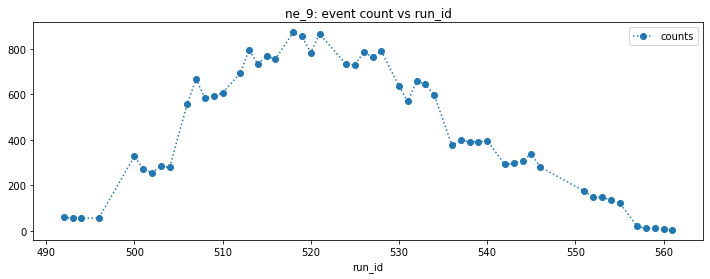

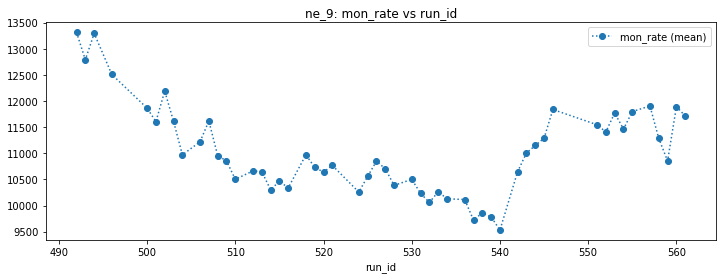

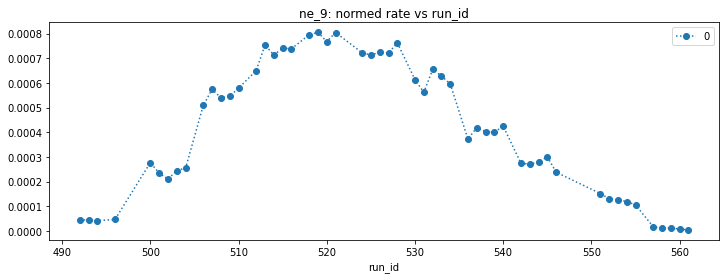


 he_9: List of run_ids vs set_field in events df
    set_field                          run_id
0        0.75       [436, 437, 438, 439, 440]
1        1.00       [430, 431, 432, 433, 434]
2        1.25       [424, 425, 426, 427, 428]
3        1.50       [418, 419, 420, 421, 422]
4        1.75  [411, 412, 413, 414, 415, 416]
5        2.00       [405, 406, 407, 408, 409]
6        2.25       [399, 400, 401, 402, 403]
7        2.50       [393, 394, 395, 396, 397]
8        2.75       [387, 388, 389, 390, 391]
9        3.00                 [382, 383, 384]
10       3.25            [373, 374, 375, 376]



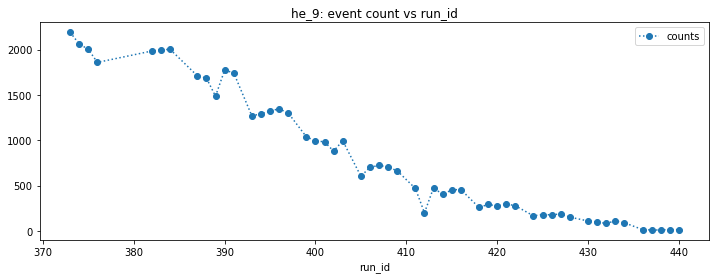

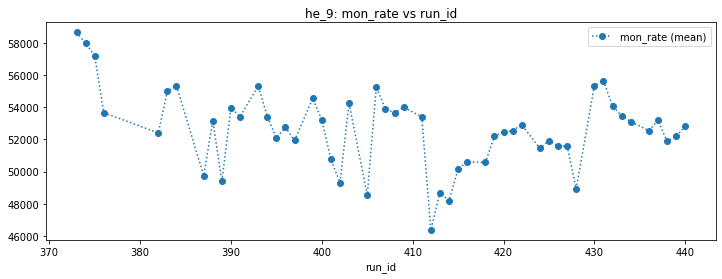

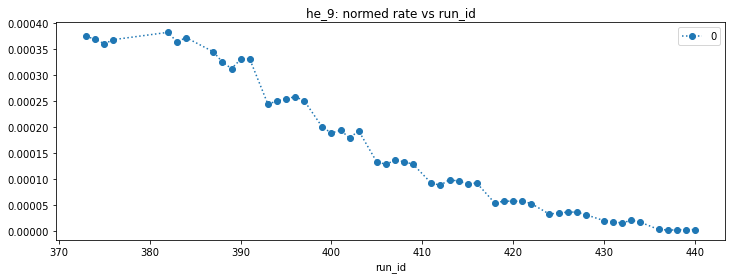

In [9]:
%matplotlib inline
for isotope in snr_study.keys(): 
    for cut in snr_cuts: 
        qc.events_summary(snr_study[isotope][cut].events,
                          snr_study[isotope][cut].root_files,
                          title = f"{isotope}_{cut}")
        # Uncomment the below to look at the normalization used for building spectra
        # display(re.build_normalization(snr_study[isotope][cut].root_files))

### QC Test 1: Histogram event attributes.

Notes: Keep an eye out for outliers. 

In [10]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            }

additional_cuts = {
                "EventStartFreq": (200e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}

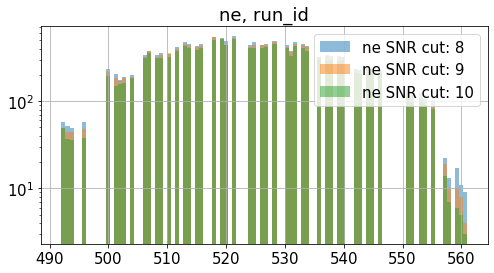

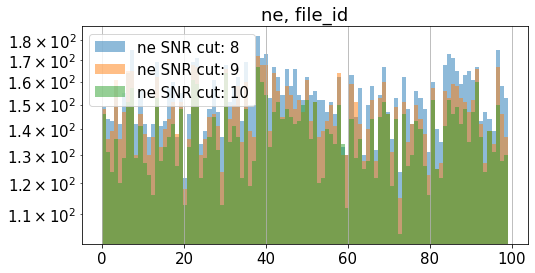

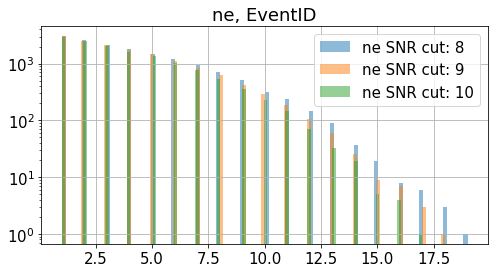

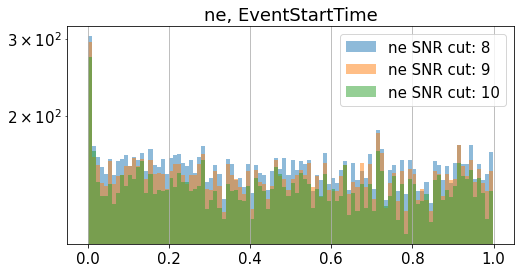

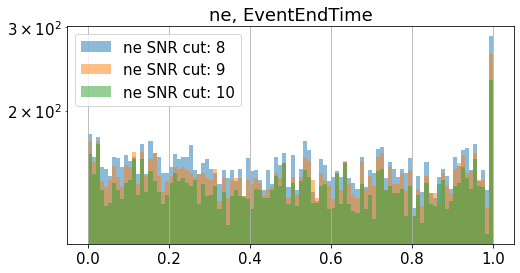

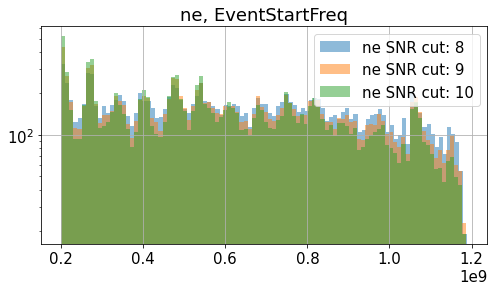

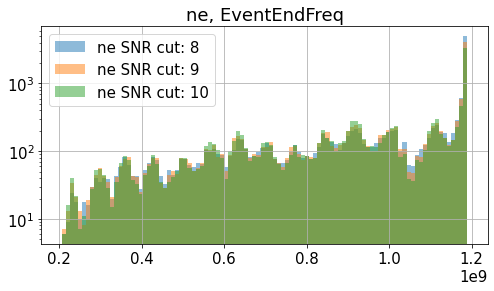

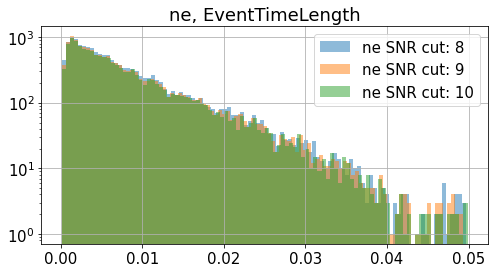

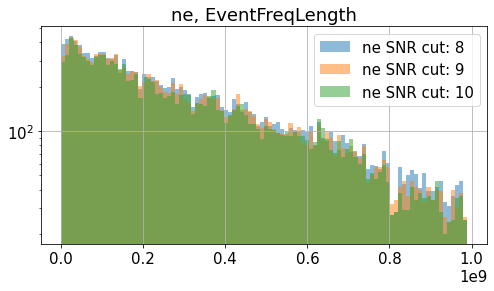

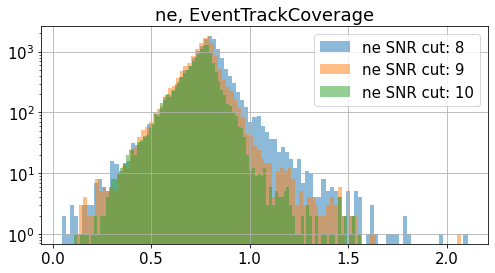

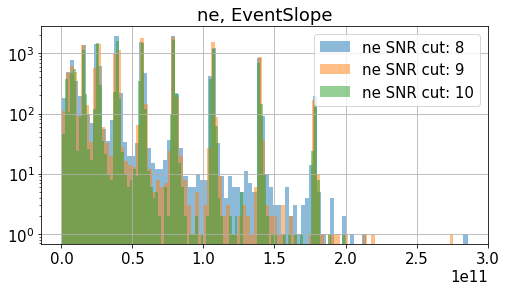

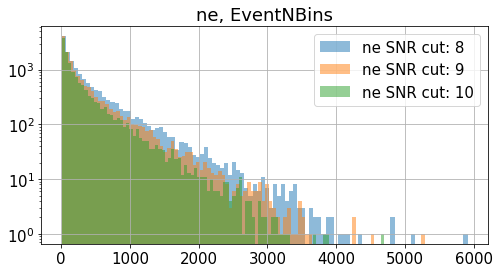

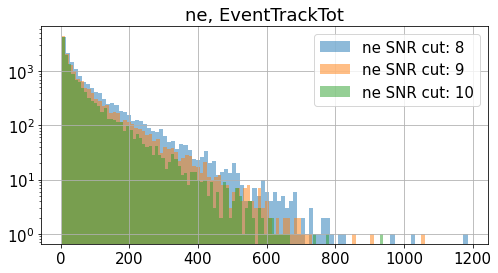

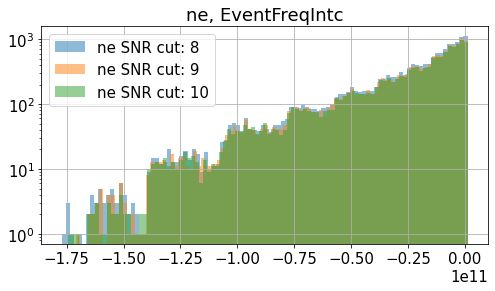

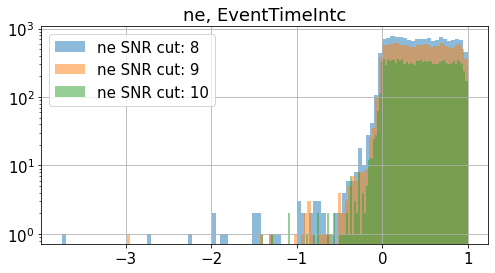

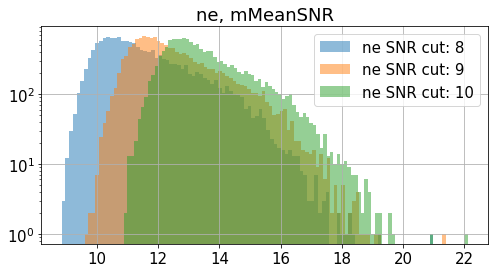

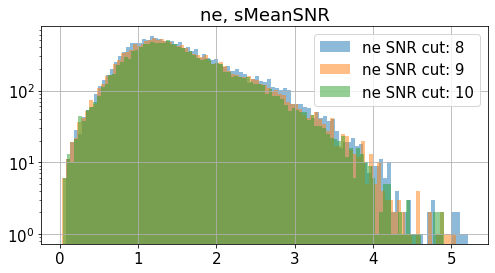

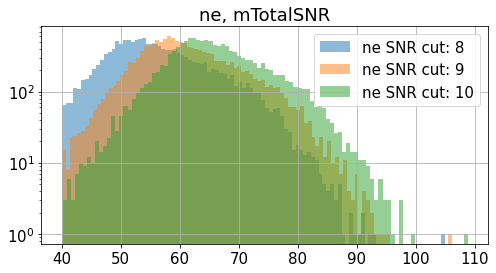

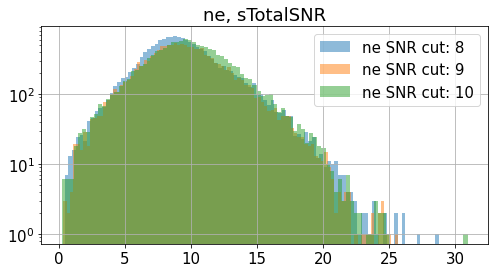

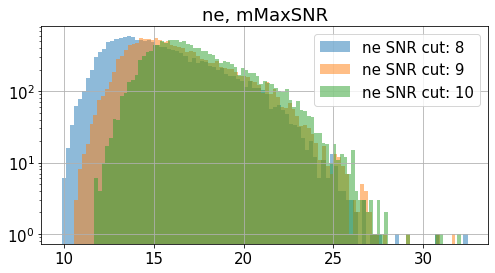

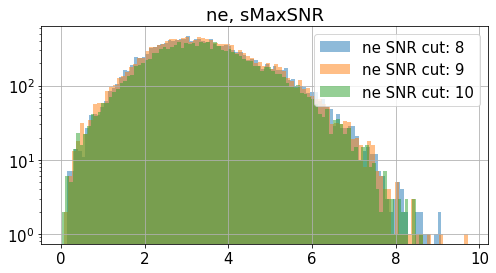

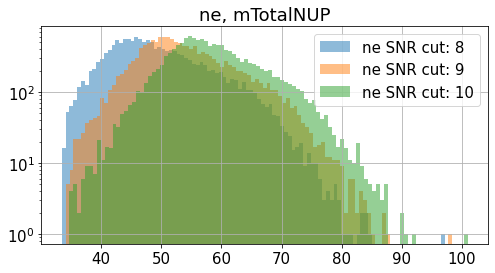

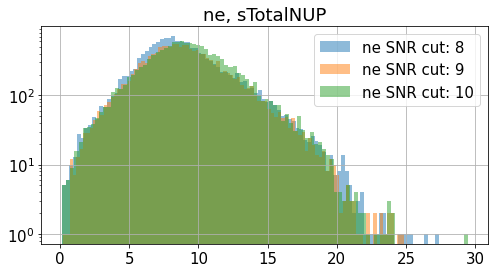

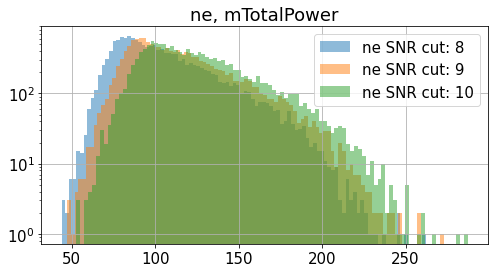

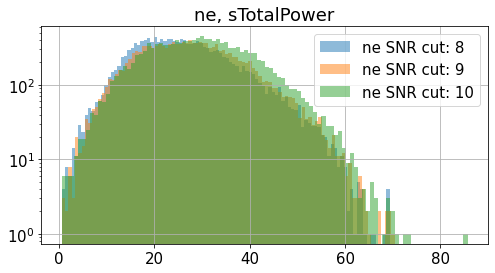

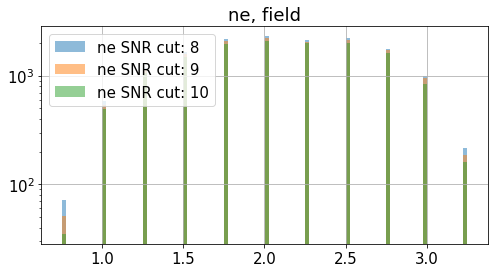

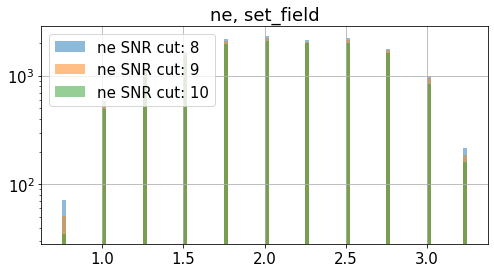

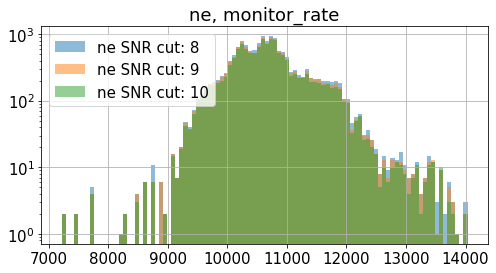

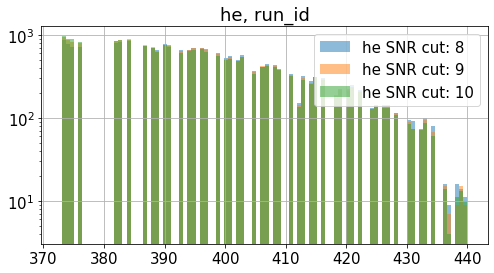

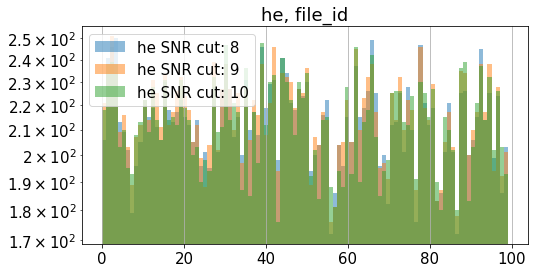

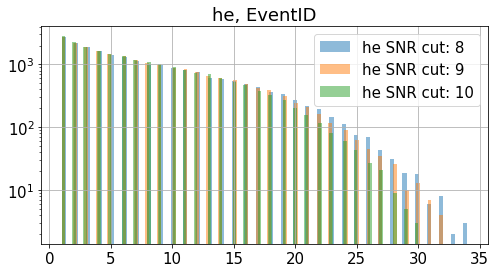

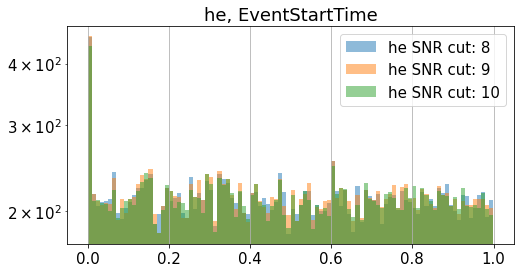

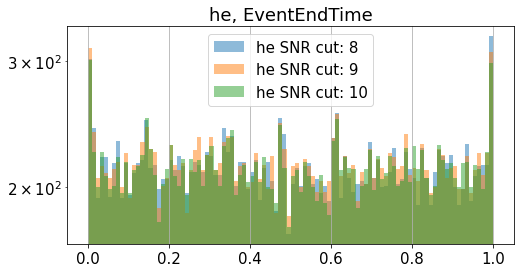

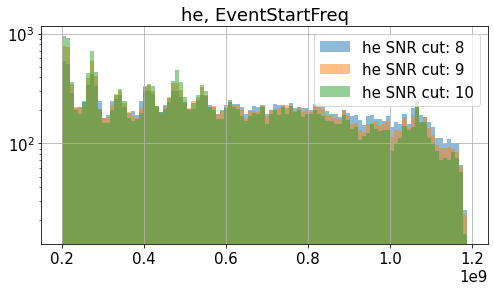

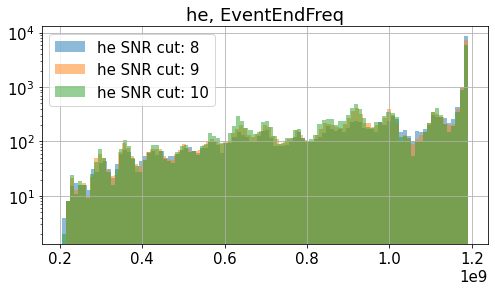

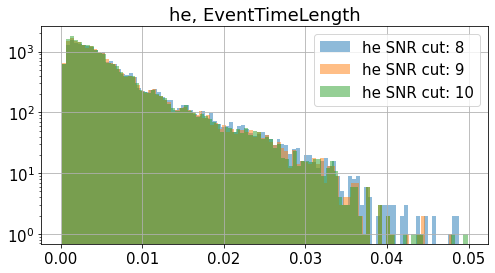

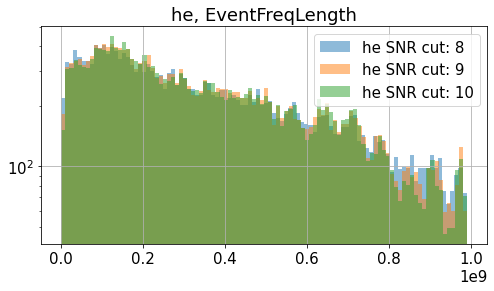

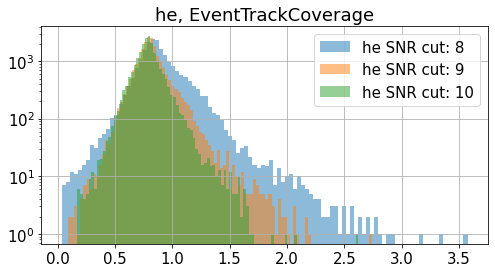

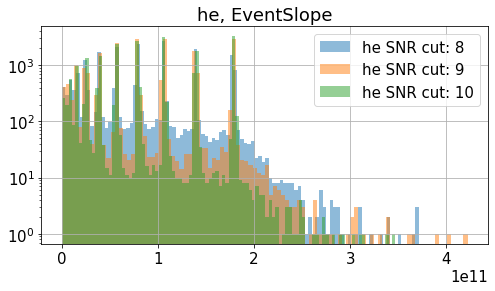

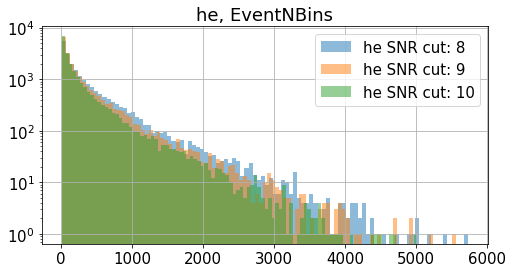

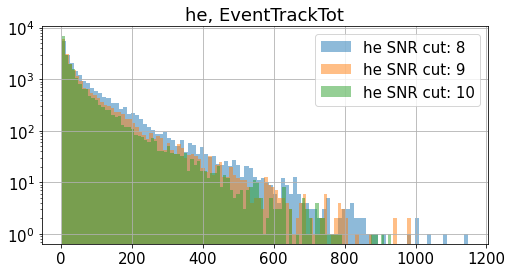

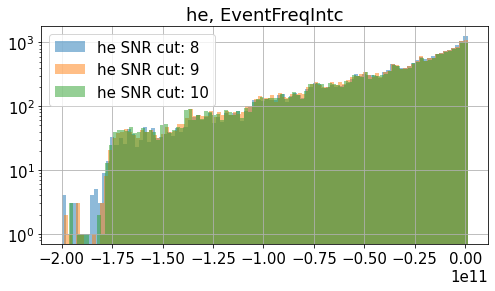

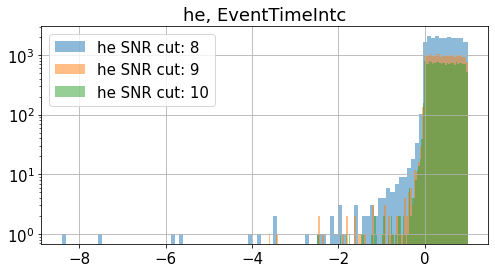

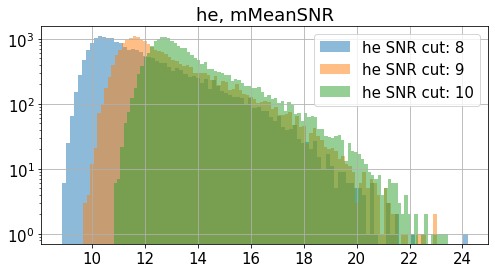

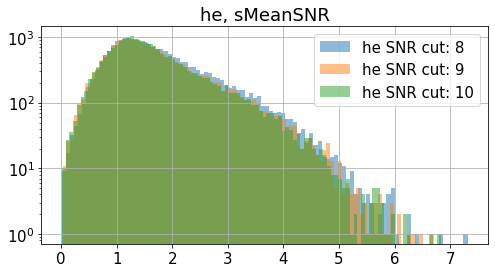

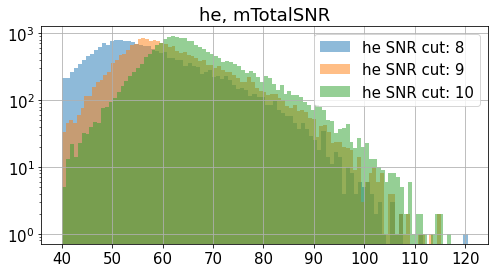

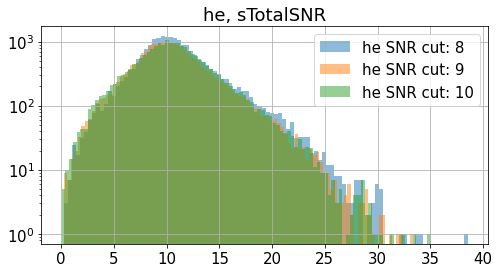

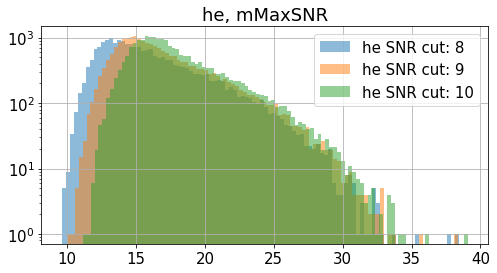

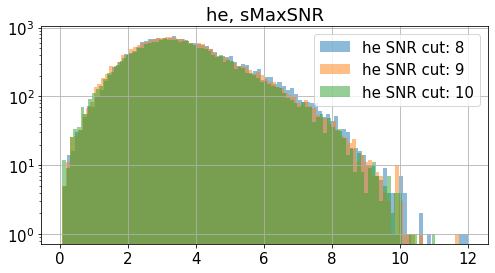

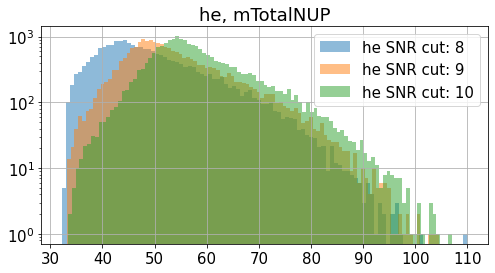

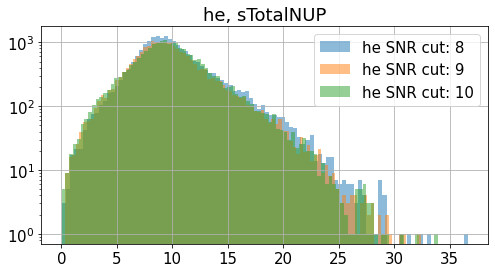

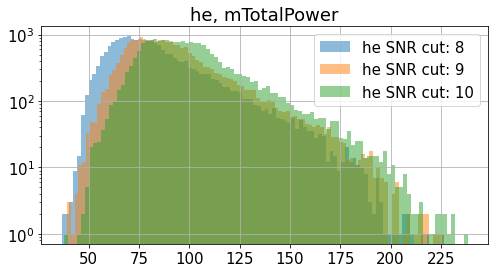

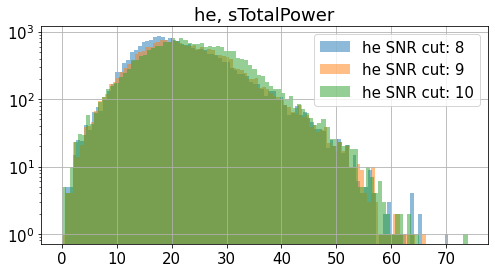

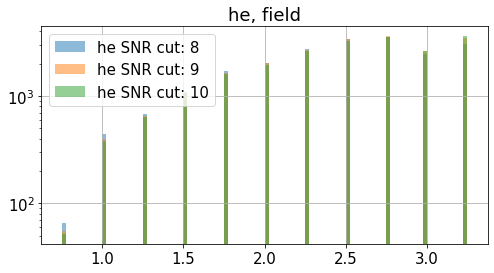

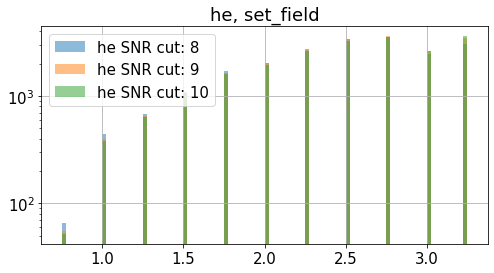

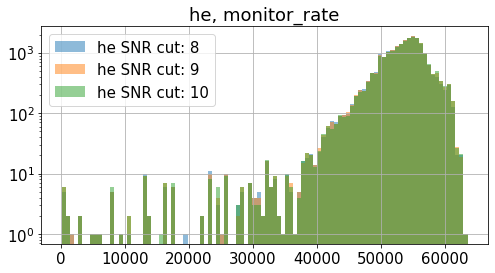

In [28]:
%matplotlib inline
# %matplotlib widget
plt.rcParams.update({'font.size': 15})

for isotope in snr_study.keys(): 
    
    for column in snr_study[isotope][cut].events.columns:

        fig, ax = plt.subplots(figsize=(8,4))
        for cut in snr_cuts: 
            
            events = snr_study[isotope][cut].events

            if isotope == "ne": 
                events_cut = re.cut_df(events, ne_cuts)
            
            if isotope == "he": 
                events_cut = re.cut_df(events, he_cuts)
      
            # Go through each field and make sure things look ok. 
            condition = (events_cut.set_field != 100)
         
            events_cut = events_cut[condition]

            density = False

            events_cut.hist(column = column, bins = 100, density = density,  alpha = .5, ax = ax, label = f"{isotope} SNR cut: {cut}")

        plt.title(f"{isotope}, {column}")
        ax.set_yscale("log")
        plt.legend()

        plt.show()

### QC Test 2: Look at the 10,50,90 quartiles of all feature distributions. 

Notes: Keep an eye out for outliers.

In [32]:
# 10th Percentile
def q10(x):
    return x.quantile(0.1)

# 50th Percentile
def q50(x):
    return x.quantile(0.5)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

In [33]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            }

additional_cuts = {
                "EventStartFreq": (400e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}

cut = 9
events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events


events_ne = re.add_detectability(events_ne)
events_he = re.add_detectability(events_he)

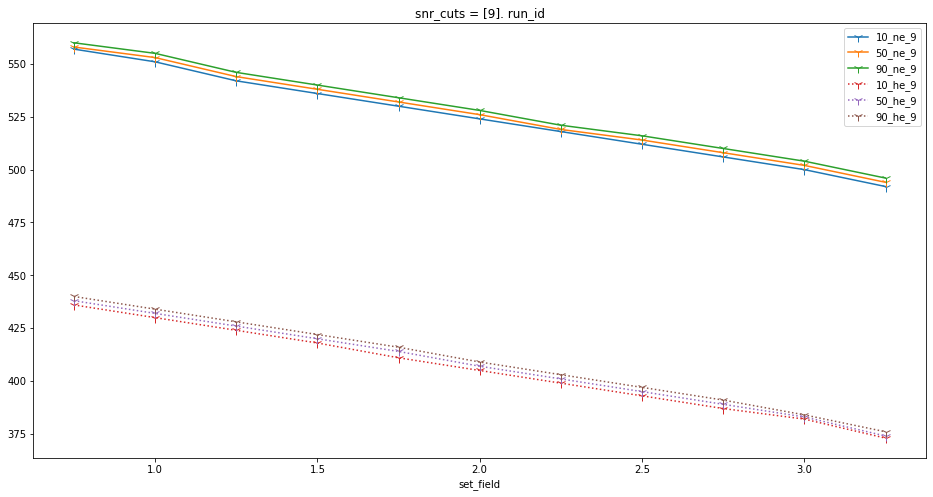

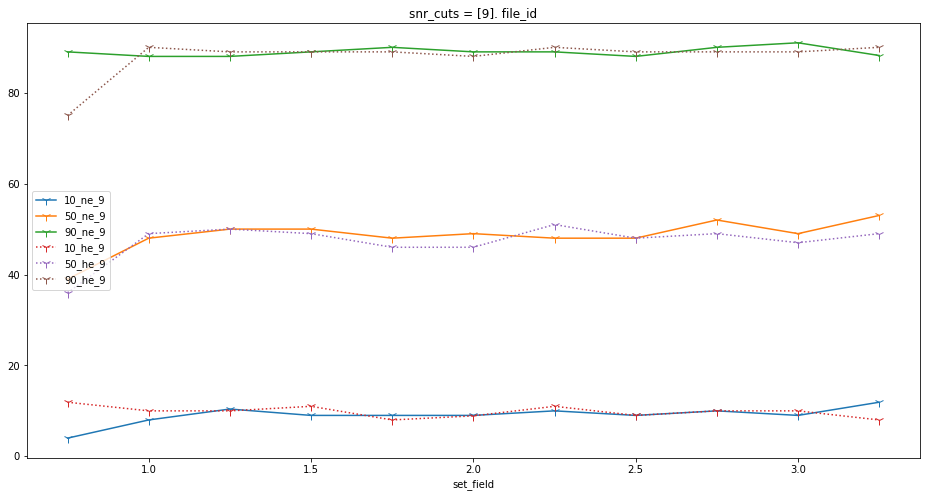

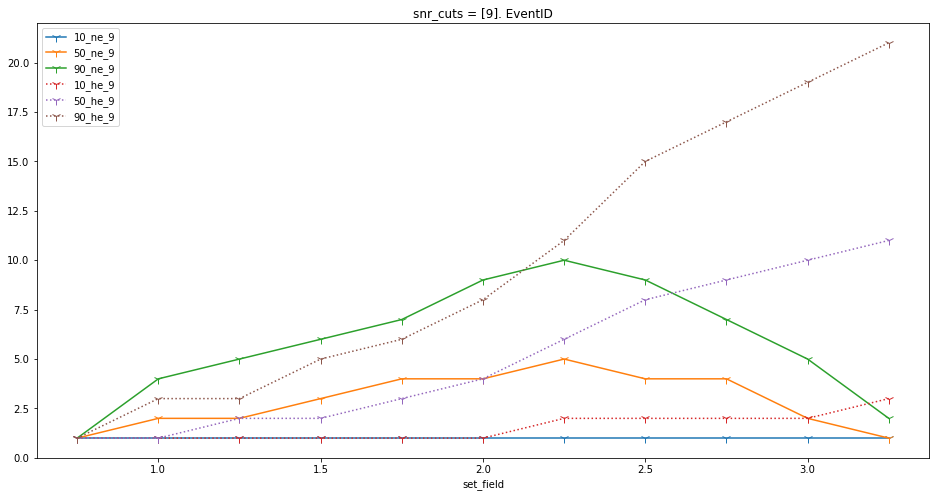

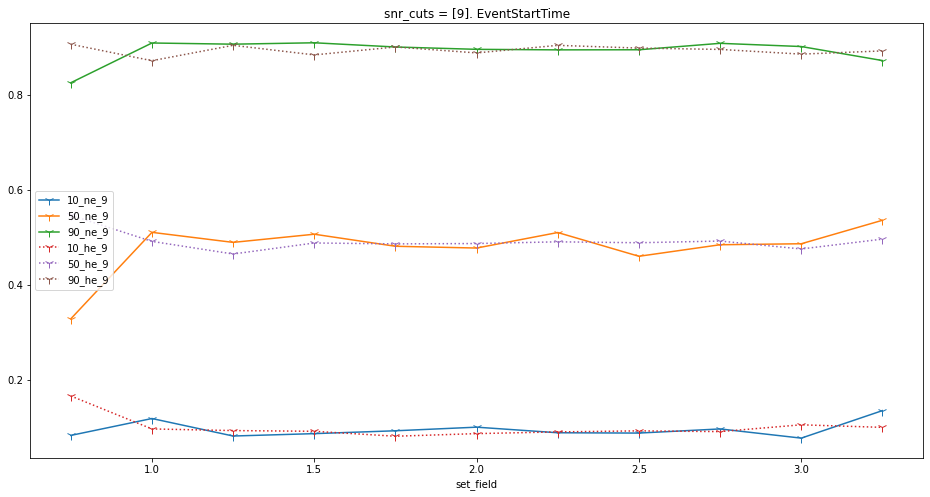

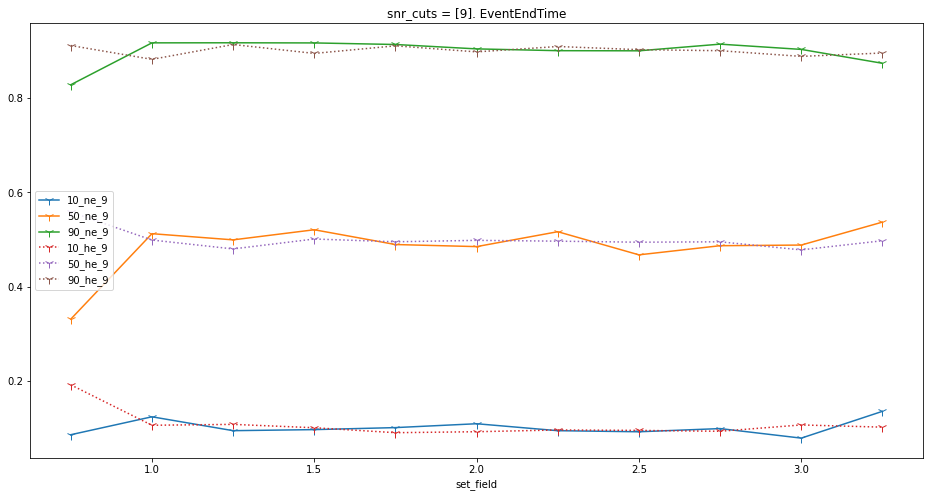

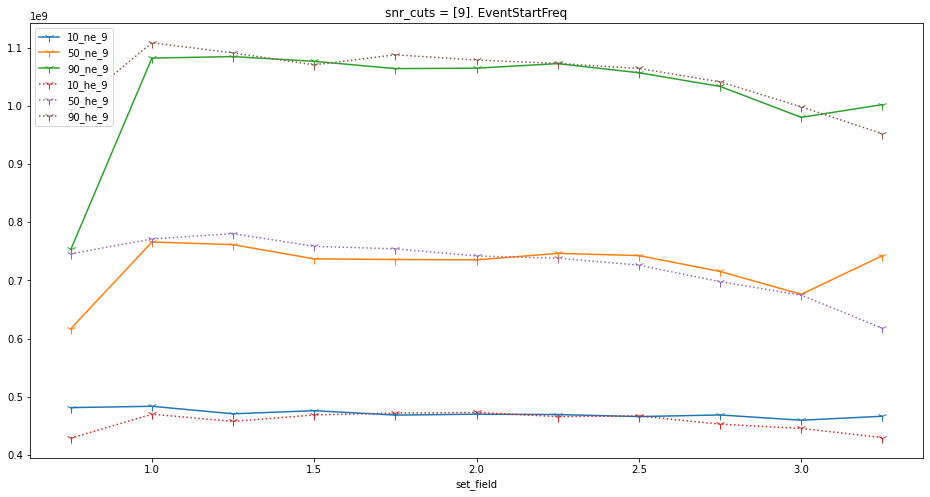

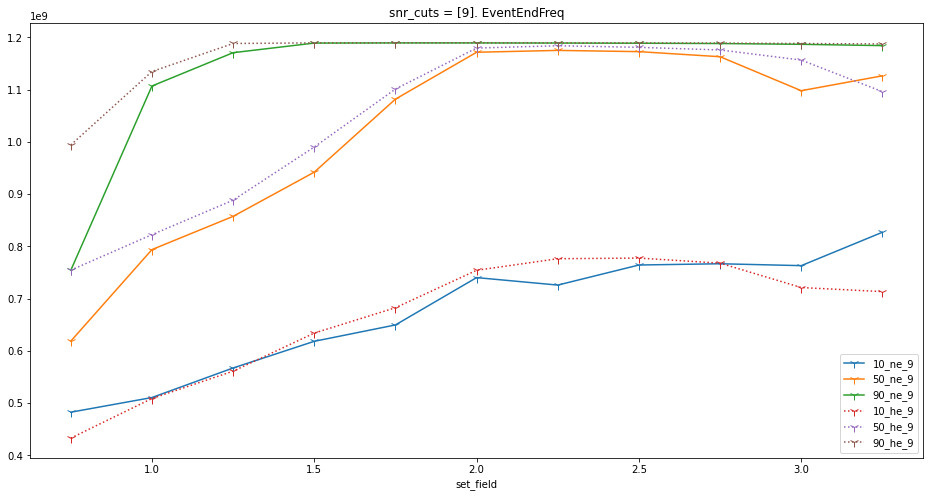

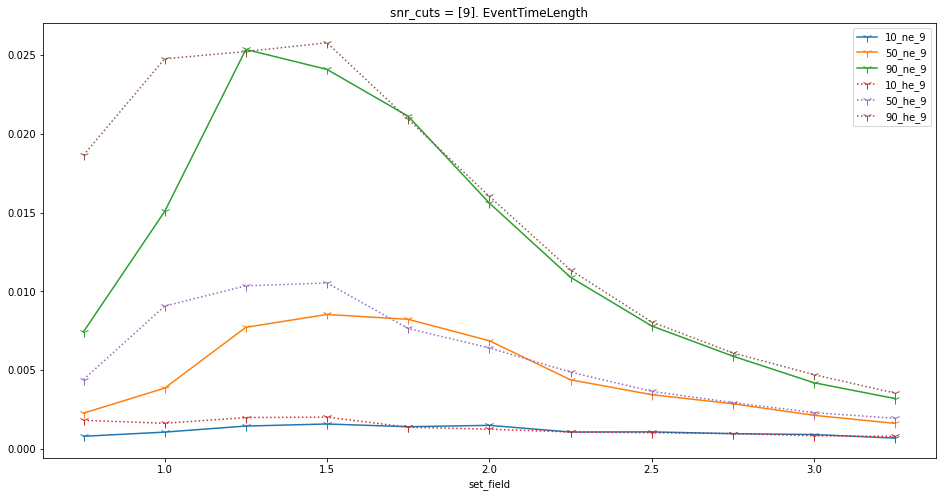

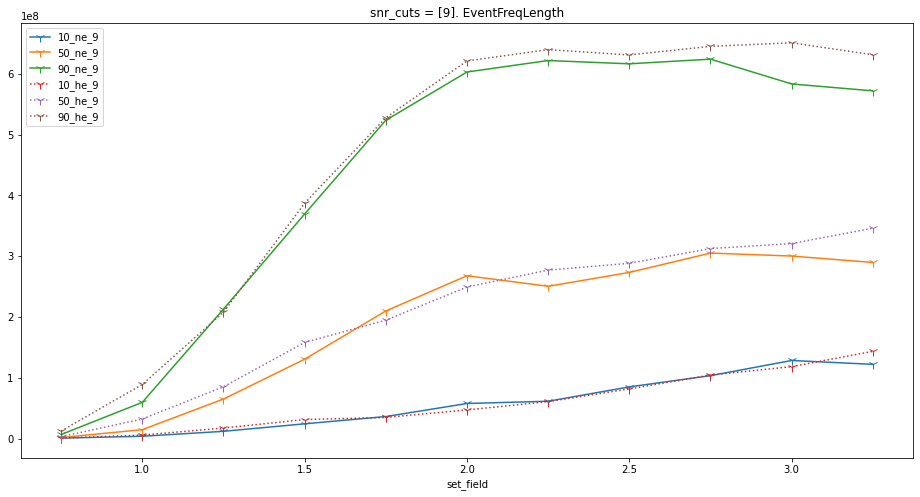

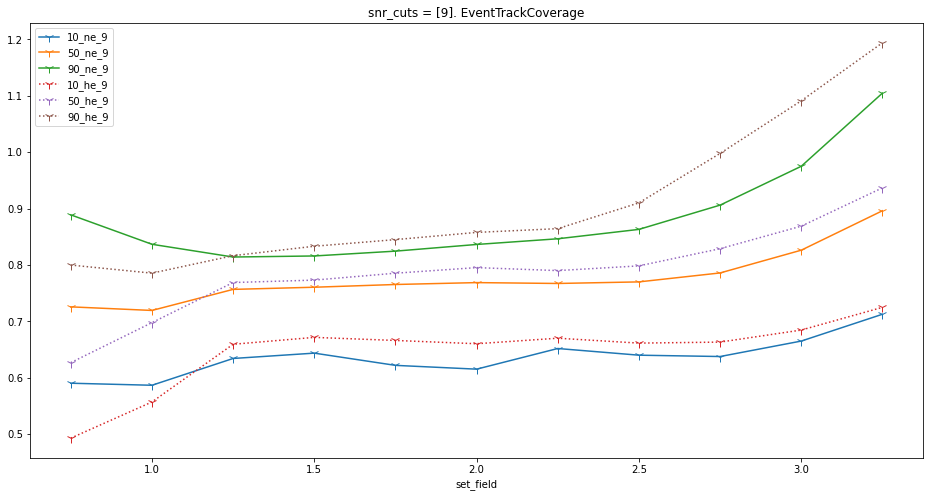

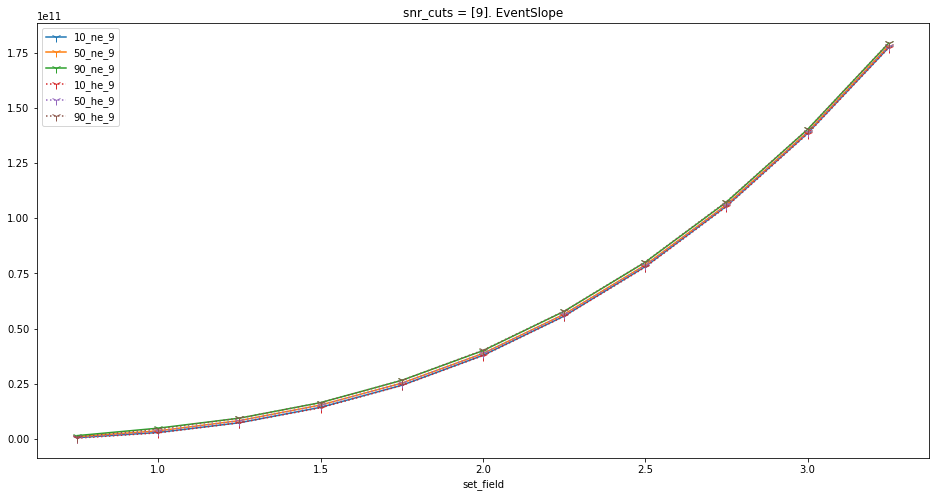

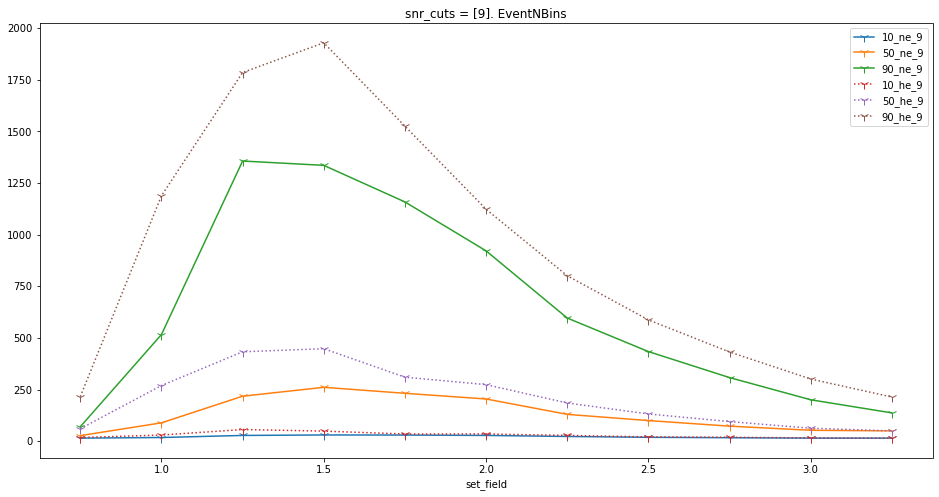

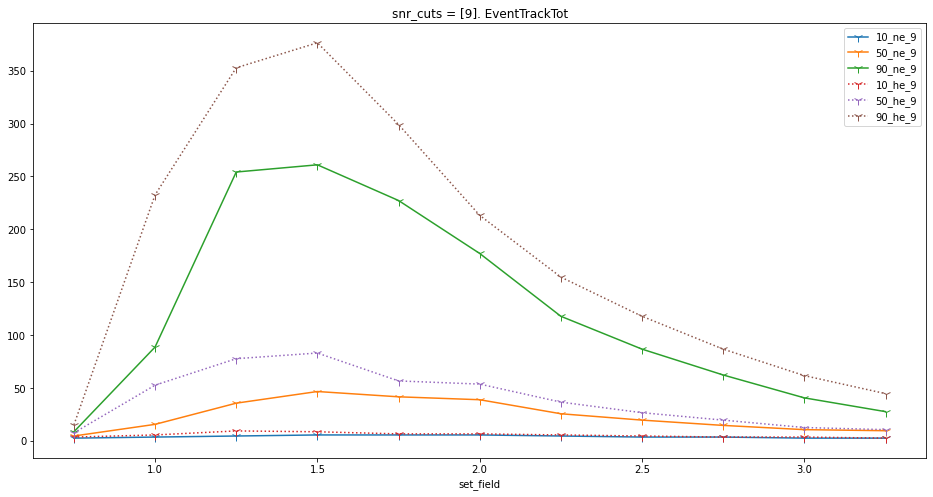

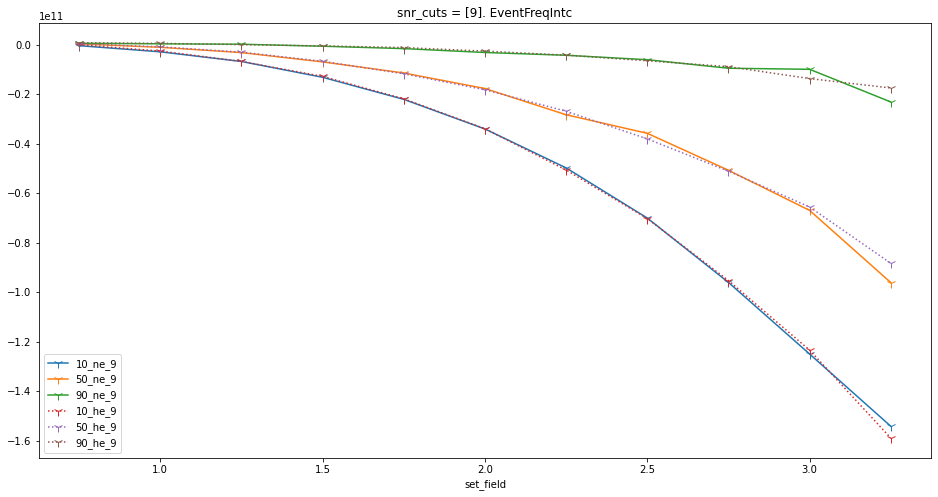

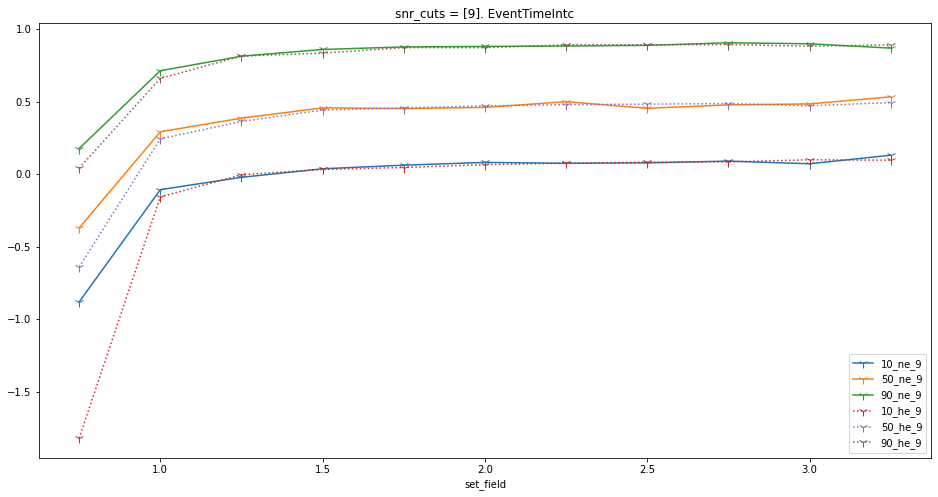

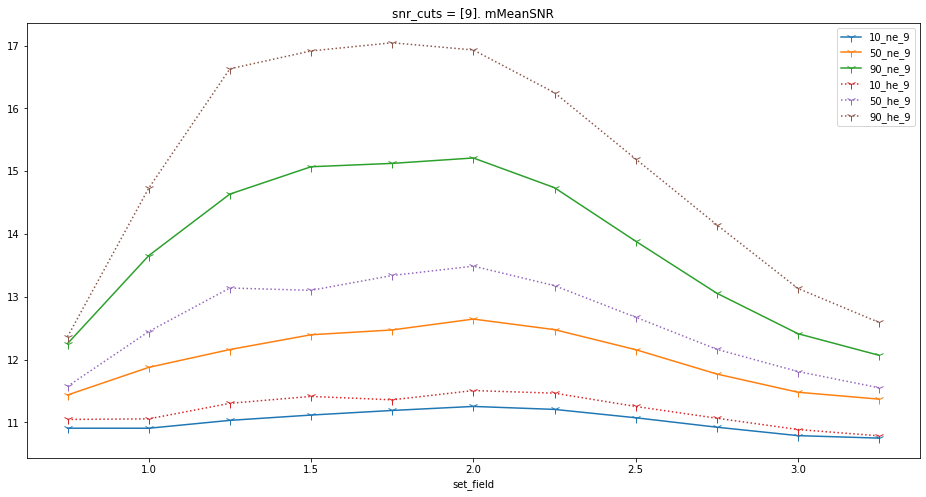

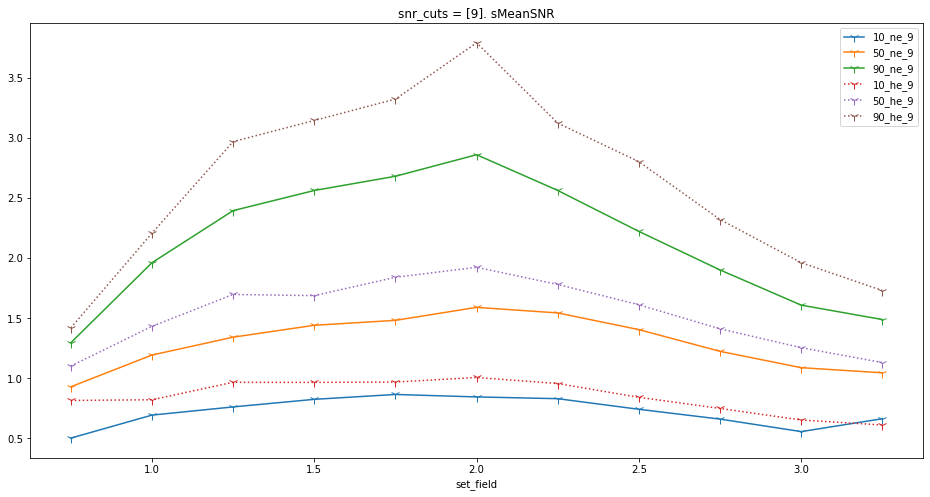

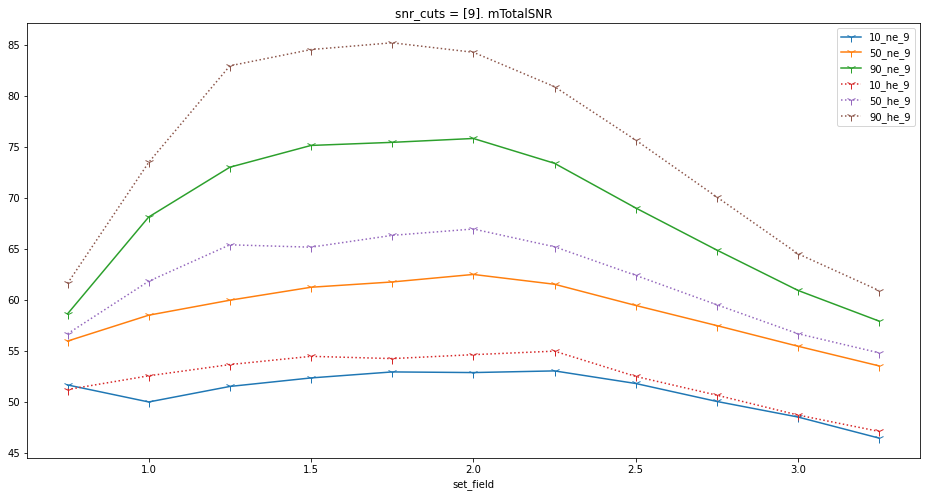

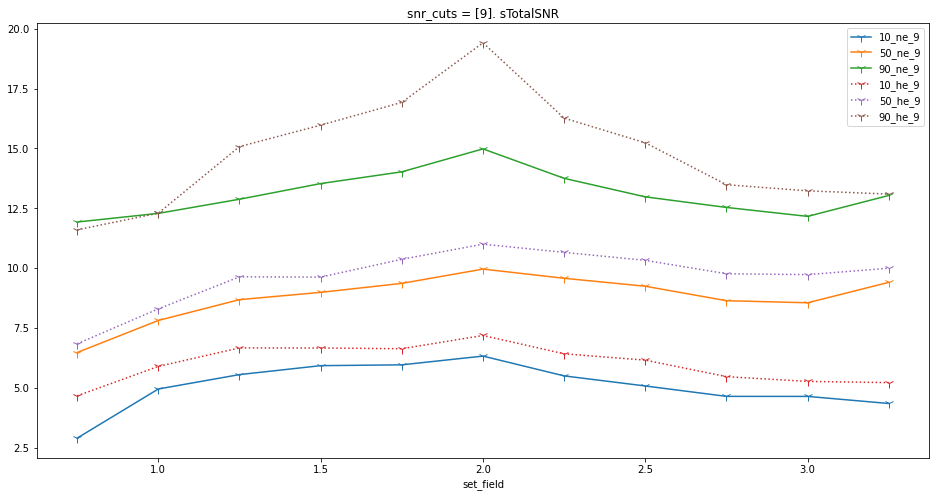

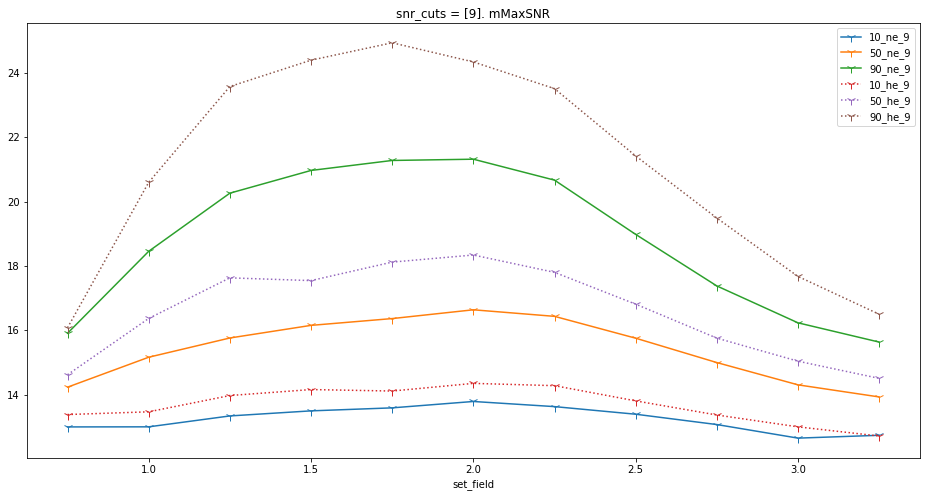

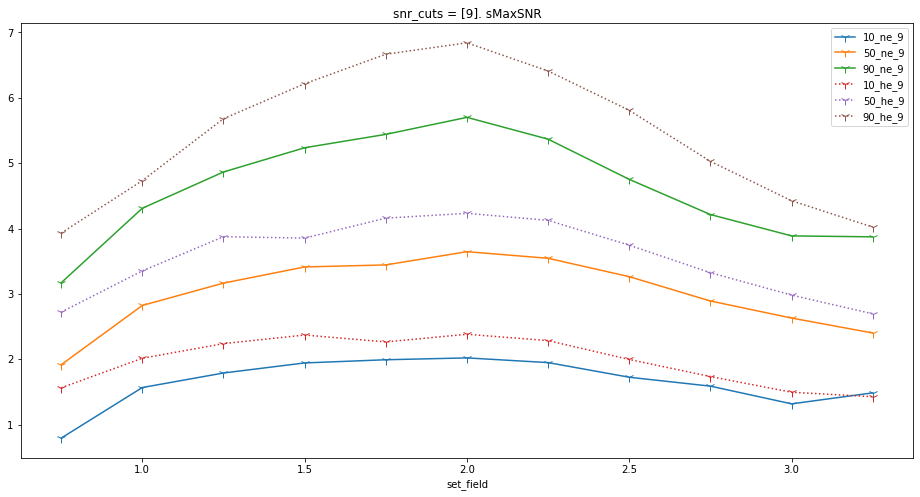

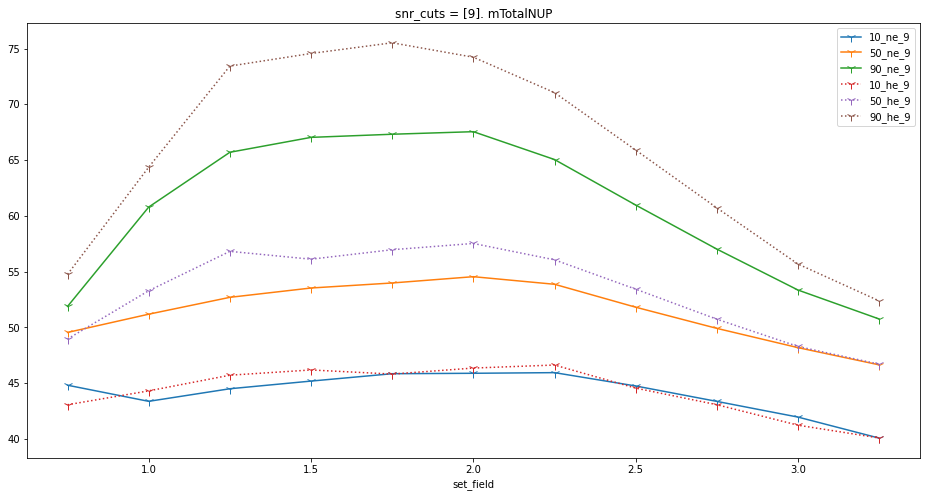

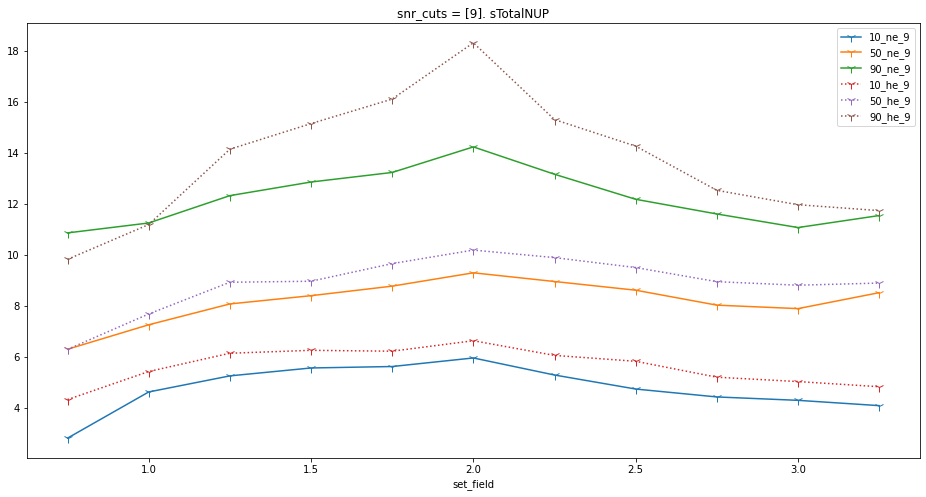

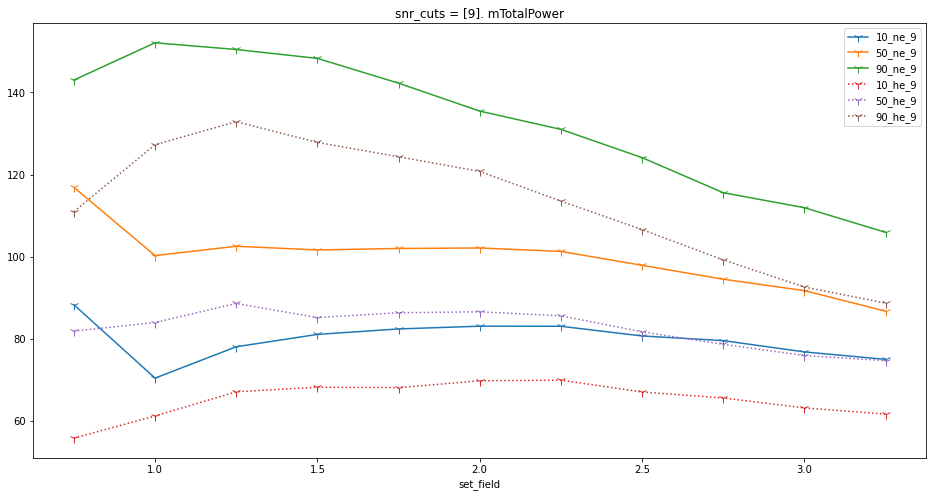

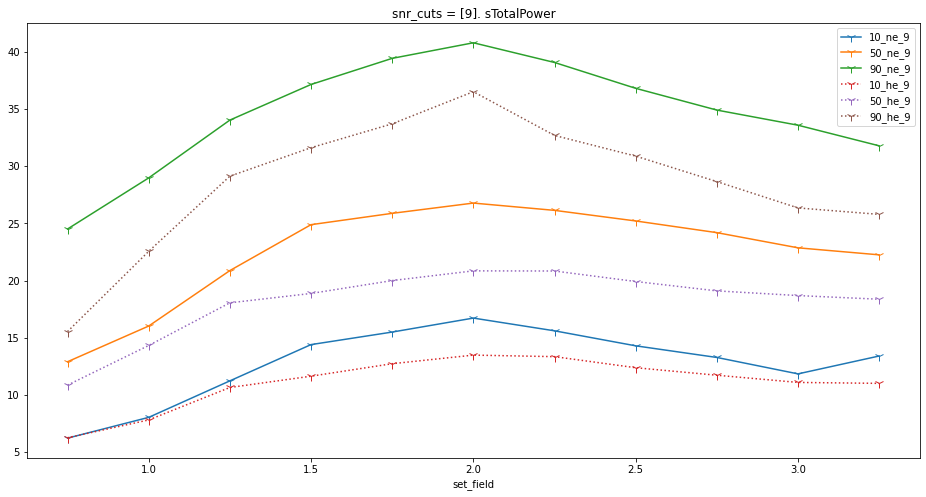

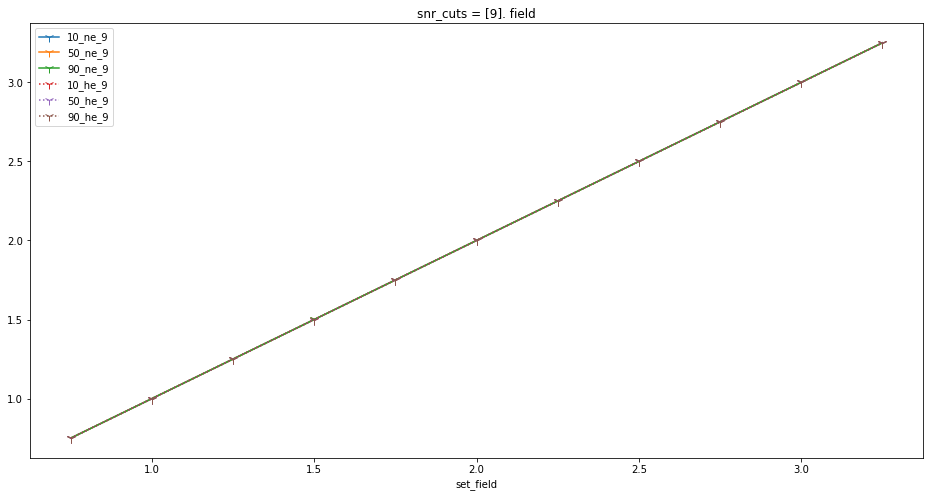

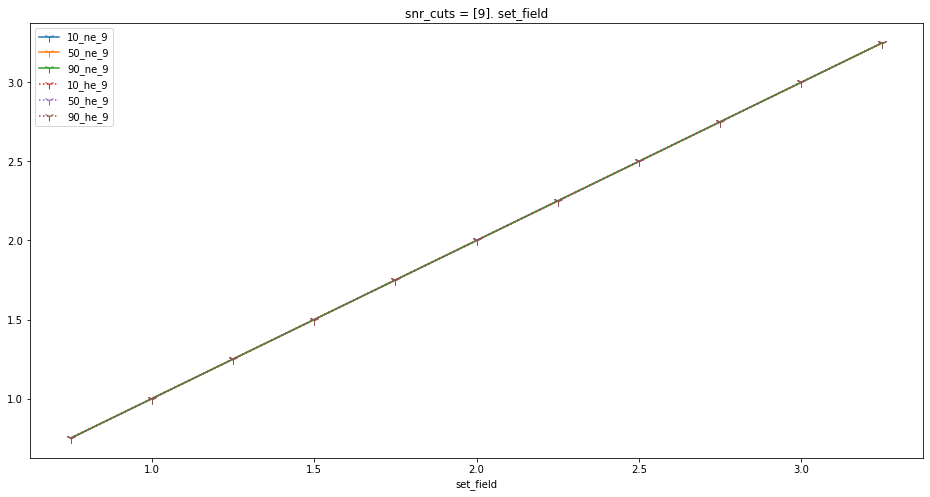

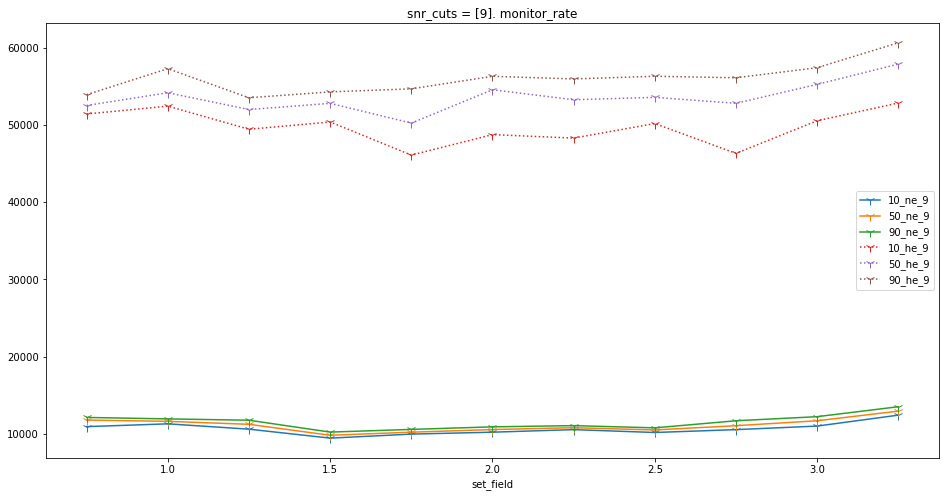

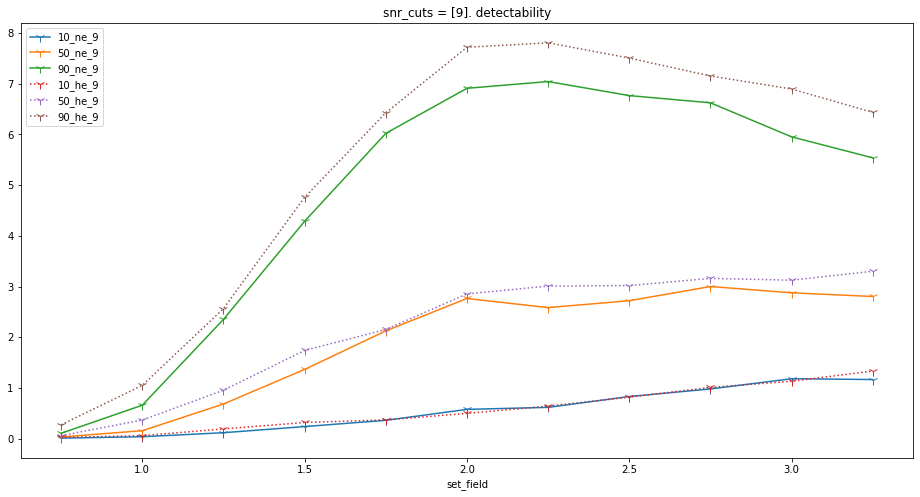

In [35]:
%matplotlib inline

aggs = [q10, q50, q90]
col_names = ["10", "50", "90"]

snr_cuts = [9]
for column in snr_study["ne"][9].events.columns: 
    
    fig0, ax0 = plt.subplots(figsize=(16,8))
    for i, cut in enumerate(snr_cuts):
        
        events_ne = snr_study["ne"][cut].events
        events_he = snr_study["he"][cut].events


        events_ne = re.add_detectability(events_ne)
        events_he = re.add_detectability(events_he)
        
        # print(events_ne.EventStartFreq.min())
        events_cut_ne = re.cut_df(events_ne, ne_cuts)
        events_cut_he = re.cut_df(events_he, he_cuts)
        # print(events_cut_ne.EventStartFreq.min())
        ne_col_names = [col_name + f"_ne_{cut}" for col_name in col_names]
        he_col_names = [col_name + f"_he_{cut}" for col_name in col_names]
        orig_col_names = ["q" + col_name for col_name in col_names]

        events_cut_ne.groupby("set_field")[column].agg(aggs).rename(columns = dict(zip(orig_col_names, ne_col_names))).plot(ax = ax0, marker =f"{i+1}", ms = 10 )
        events_cut_he.groupby("set_field")[column].agg(aggs).rename(columns = dict(zip(orig_col_names, he_col_names))).plot(ax = ax0, ls = "dotted",marker =f"{i+1}", ms = 10)
    plt.title(f"snr_cuts = {snr_cuts}. {column}")
    plt.legend()
    plt.show()
    

### QC Test 3: Visualize Events to gaurentee things look sensible. 

* Notes: 
    * I don't see anything too weird. Lots coming from below for he... 

In [49]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            }

additional_cuts = {
                "EventStartFreq": (0e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}




NEON


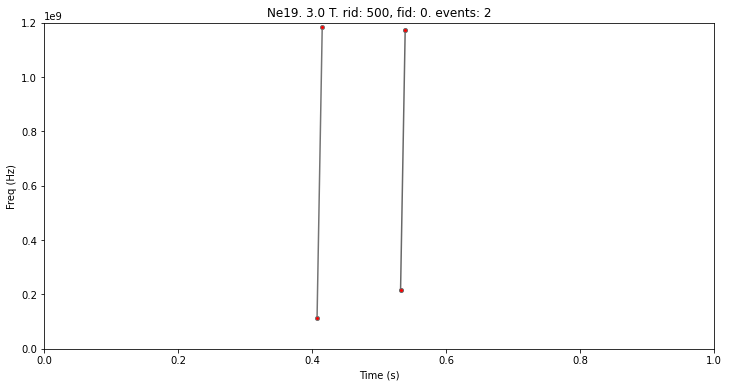

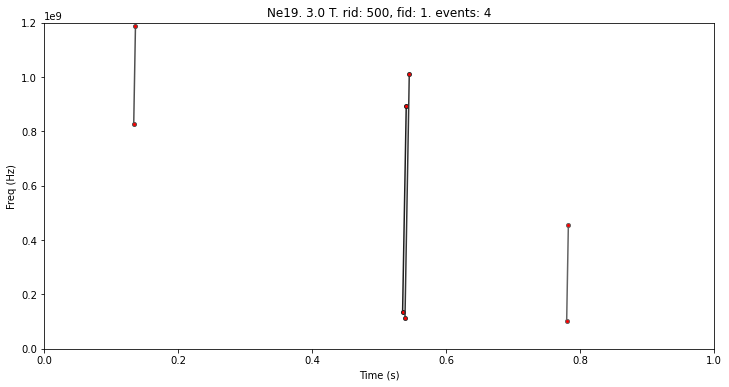

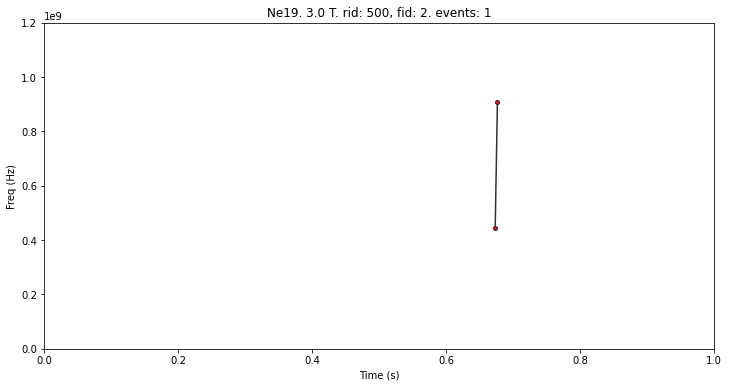

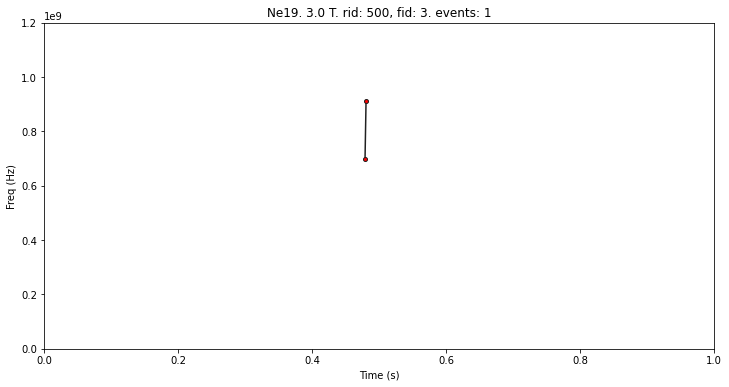

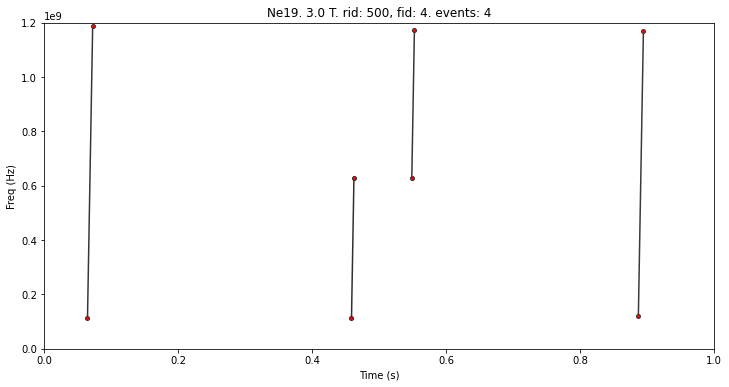

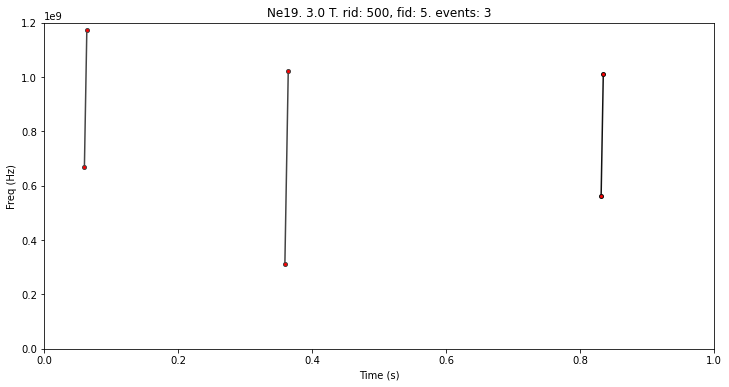

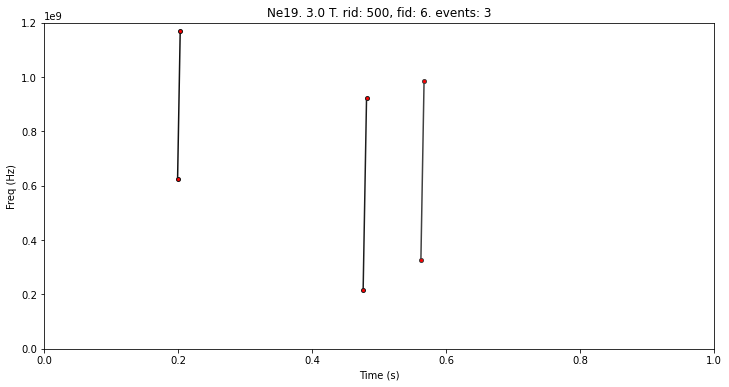

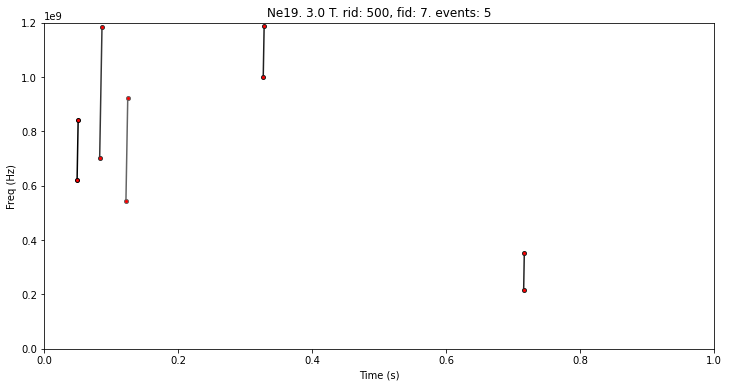

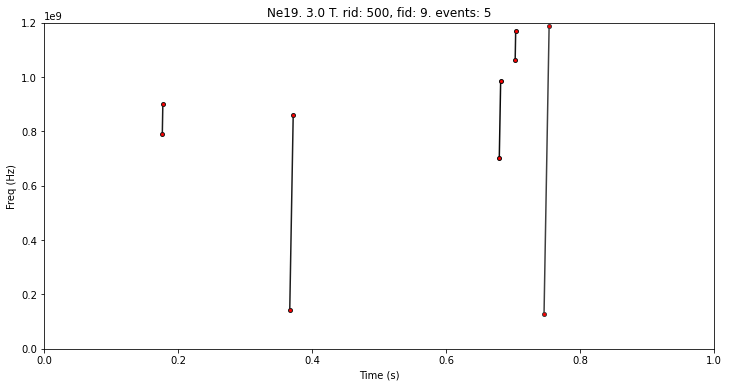

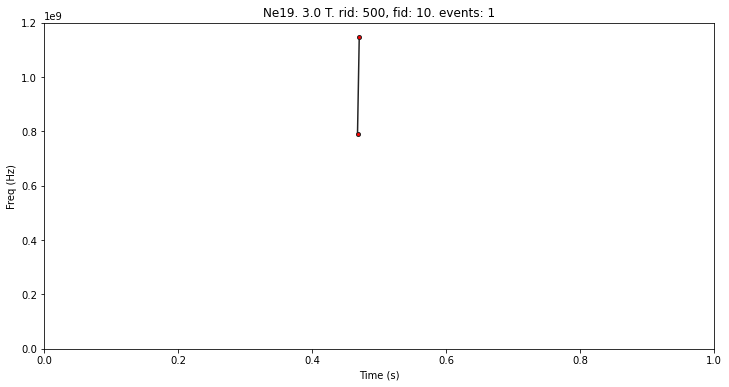

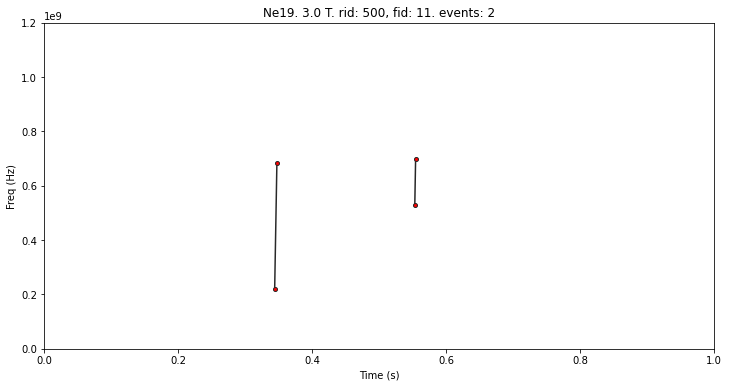

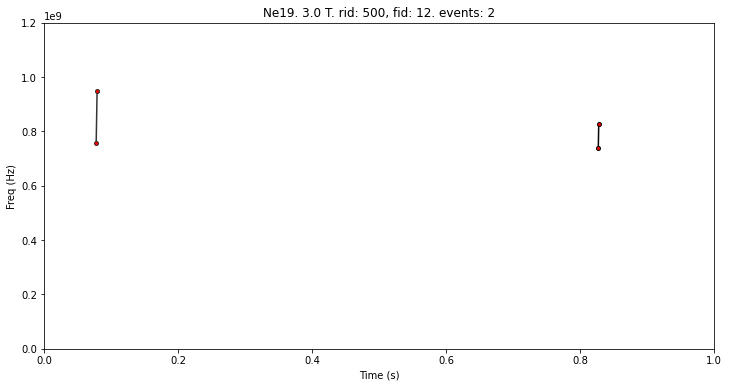

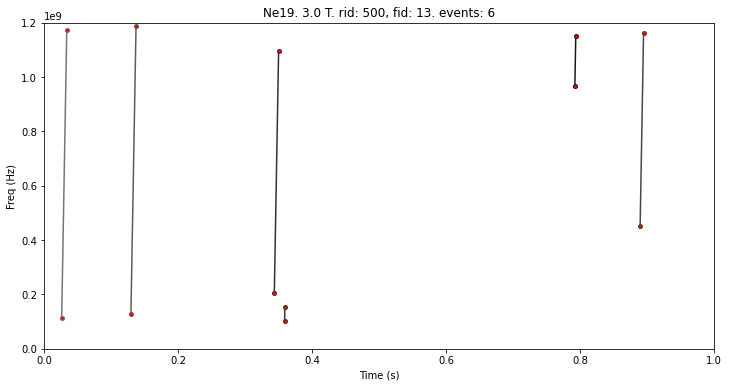

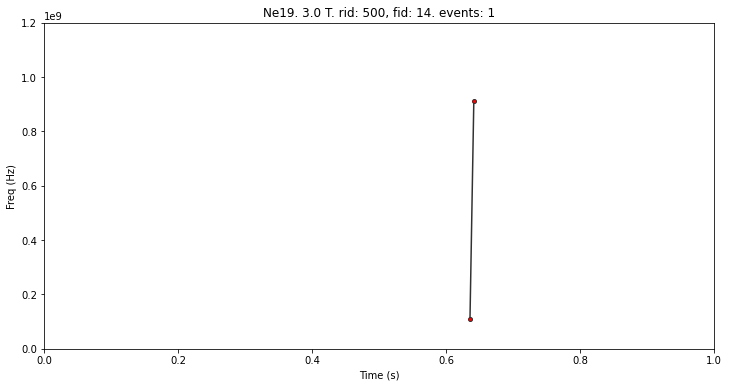

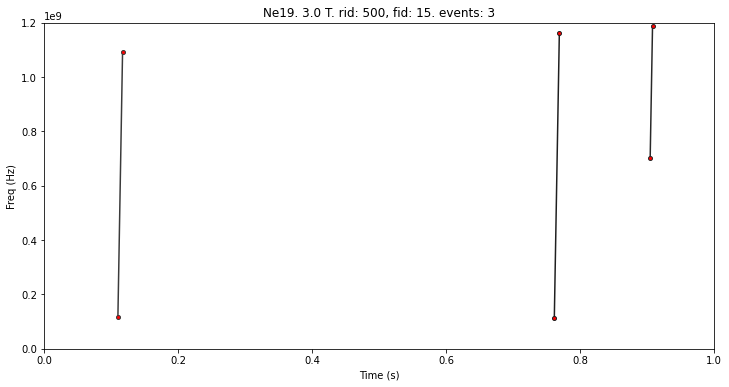

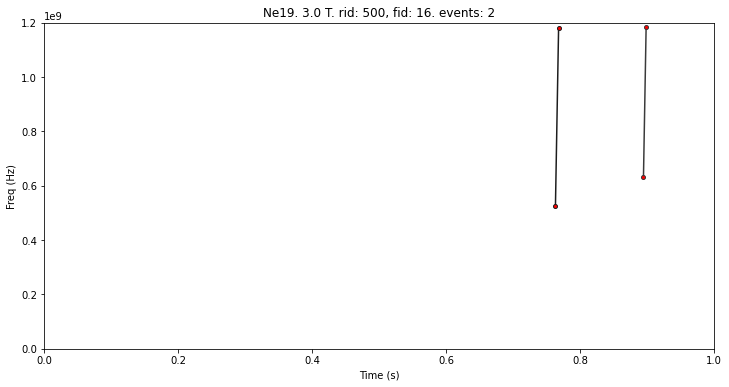

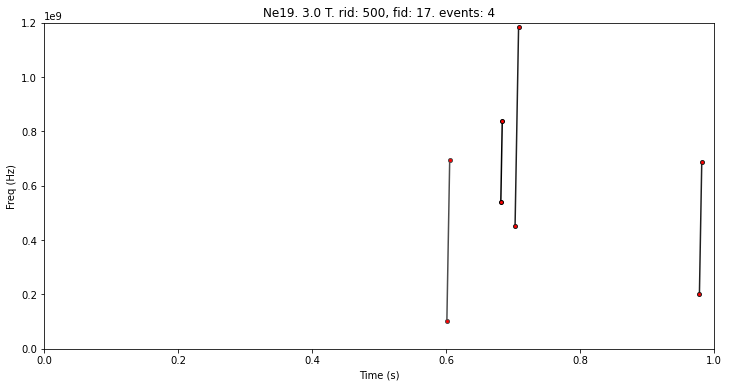

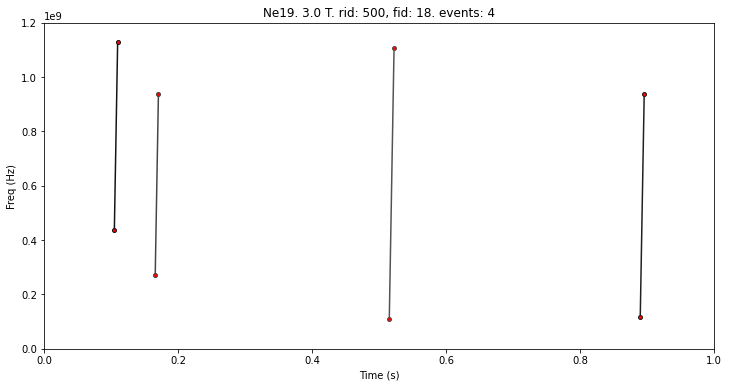

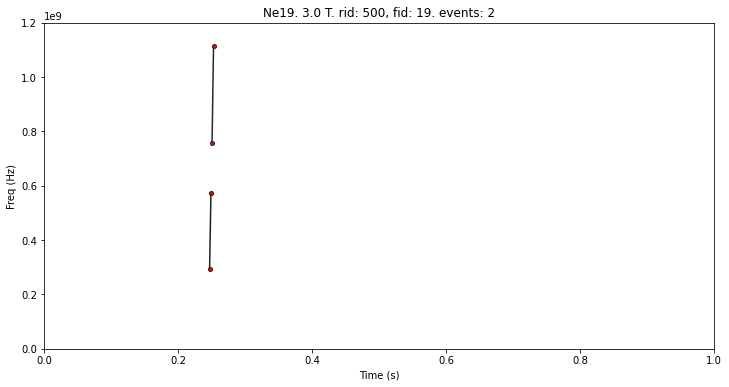

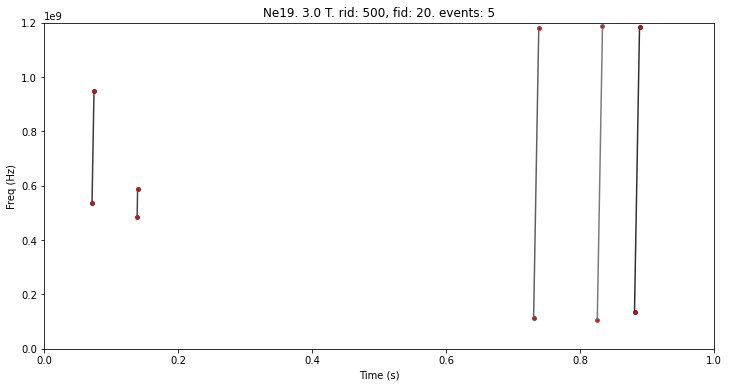

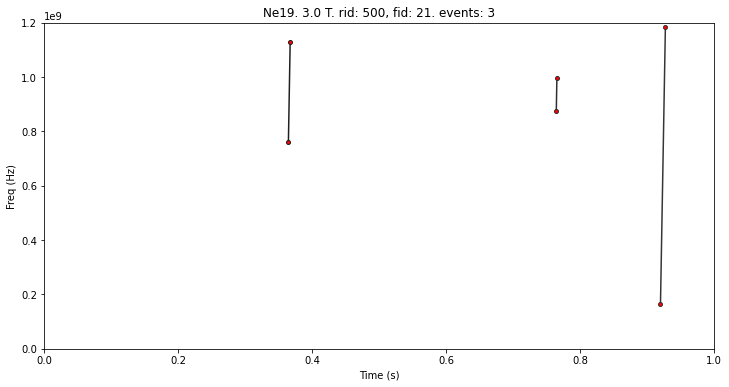

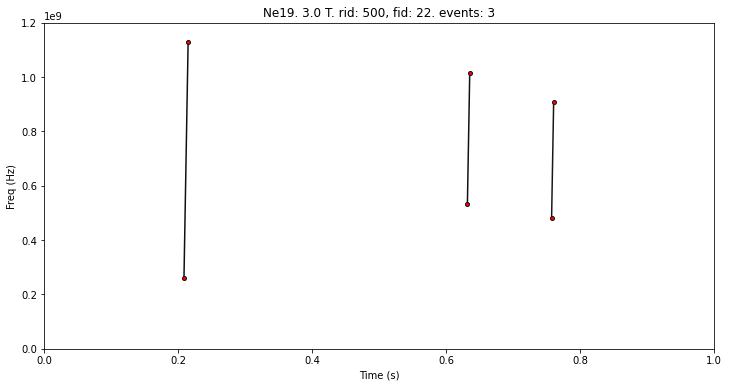

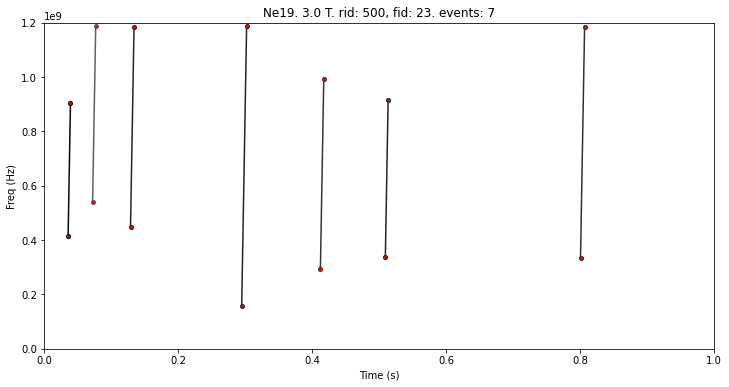

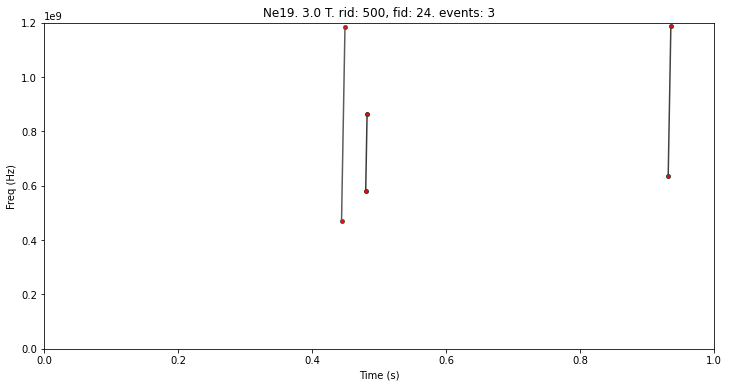

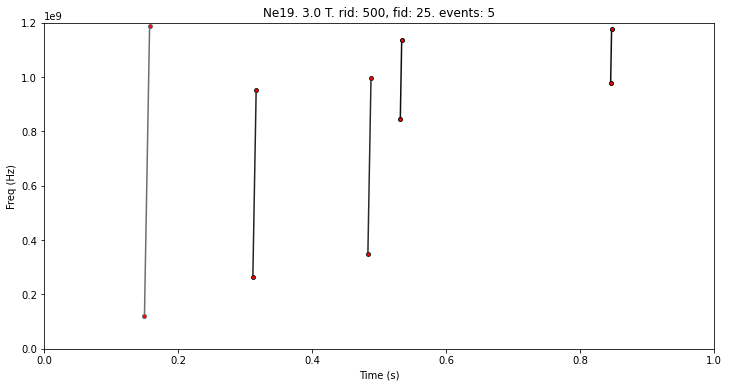

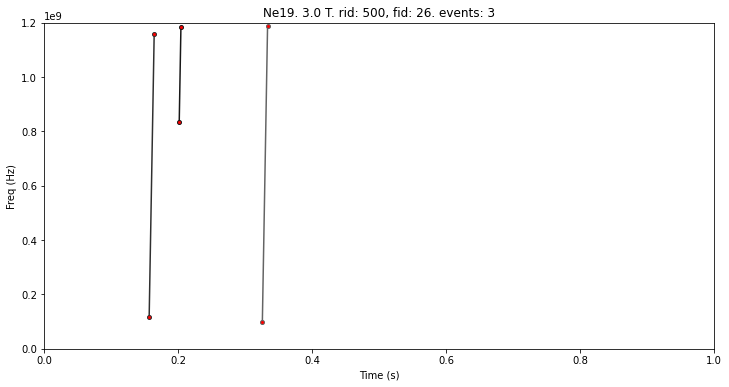

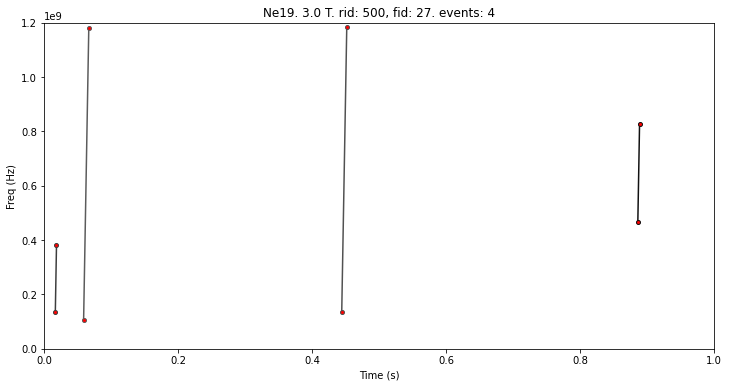

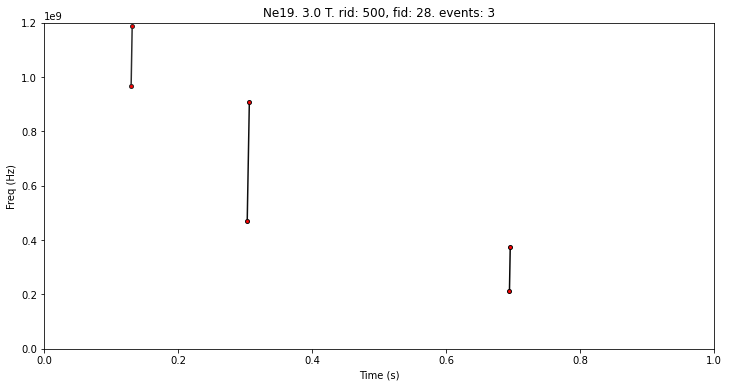

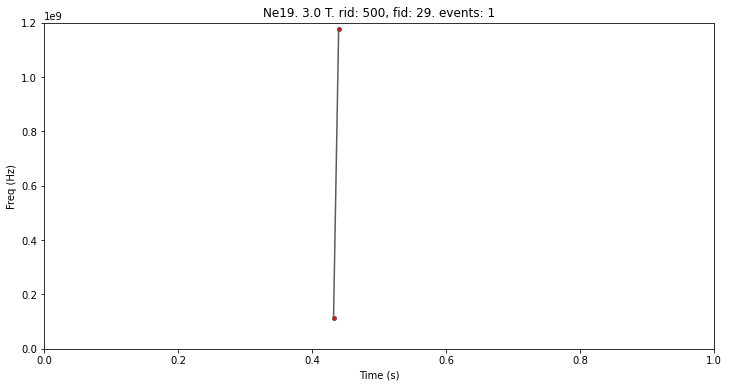

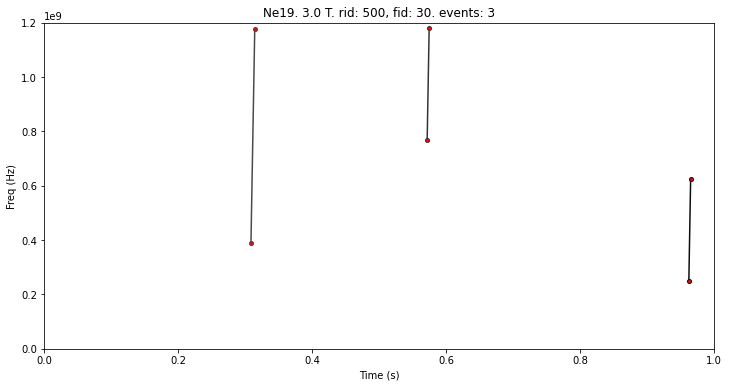

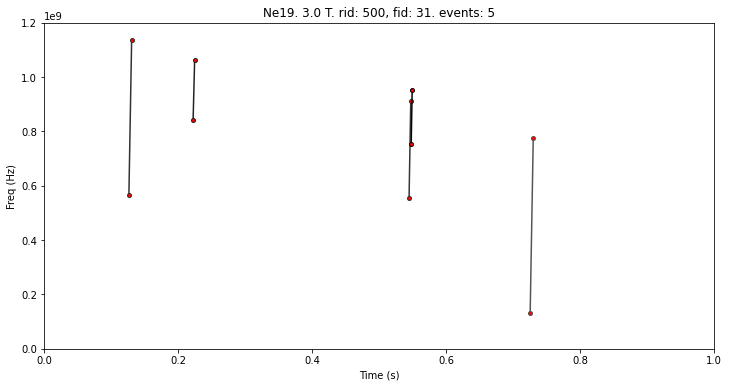

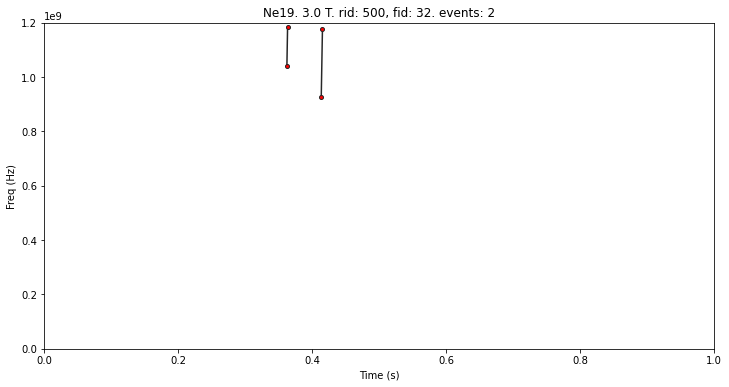

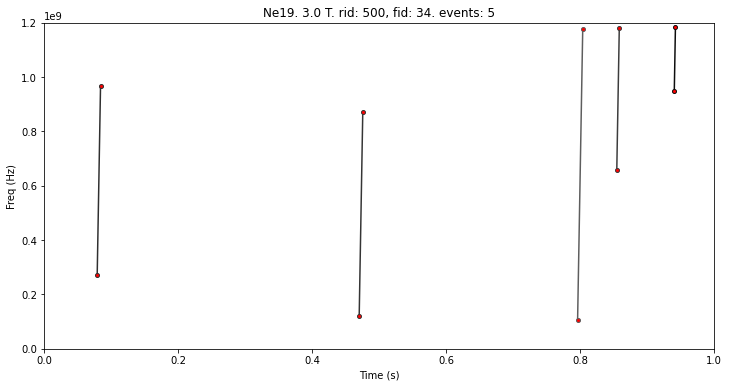

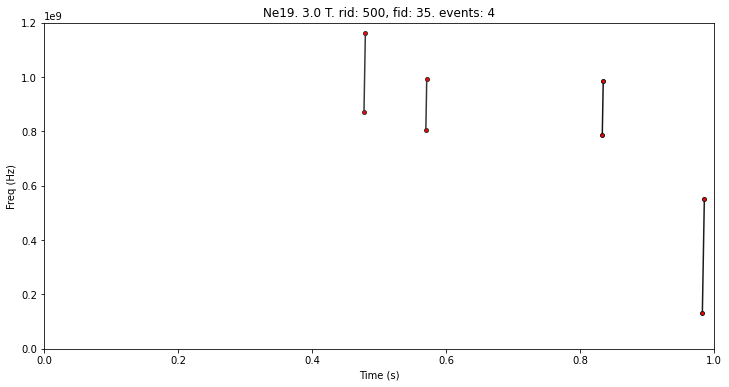

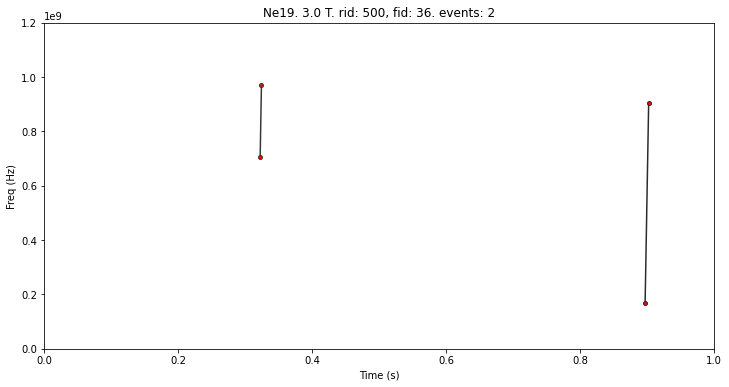

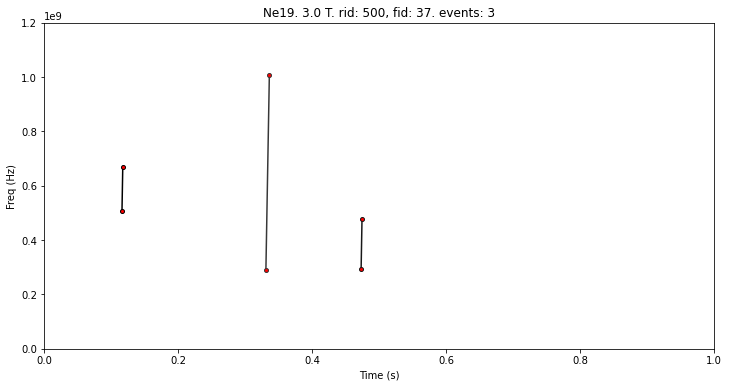

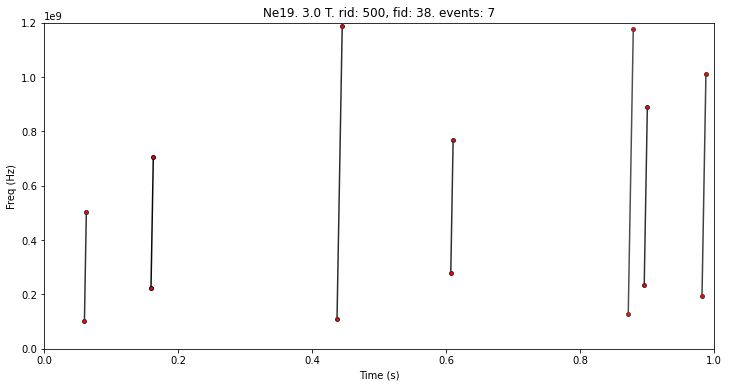

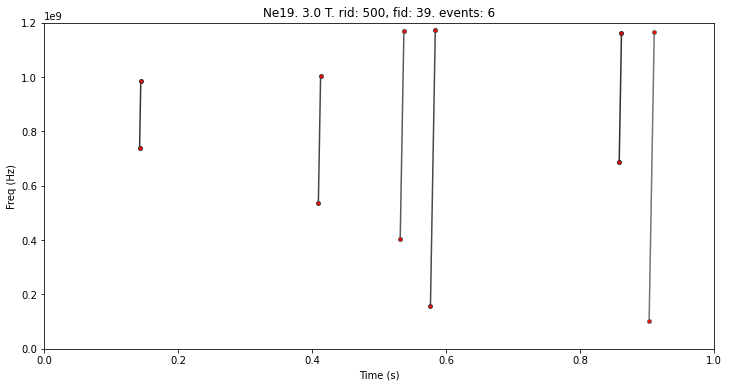

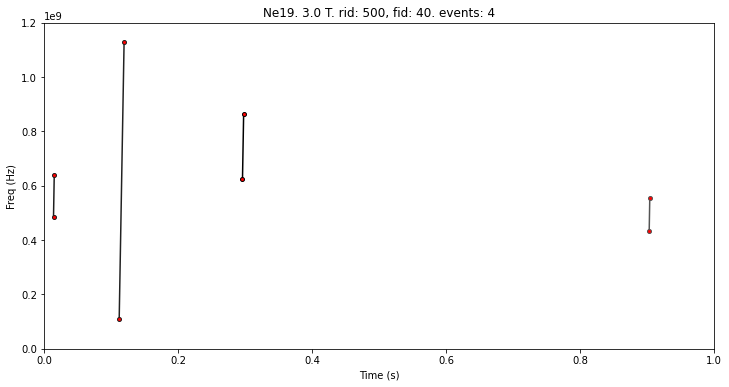

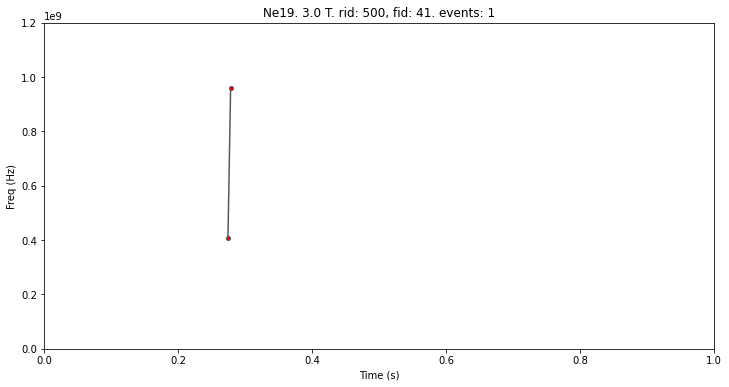

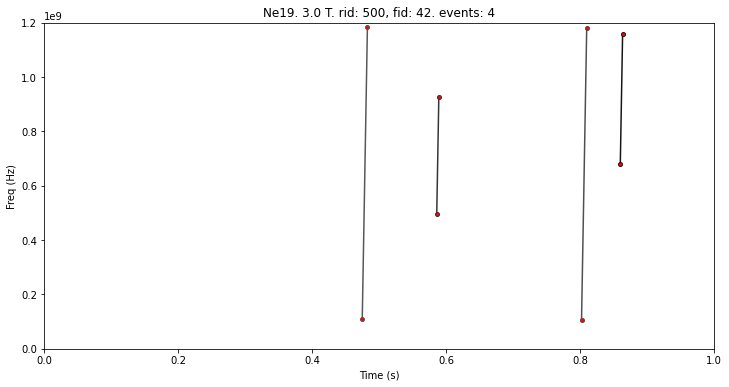

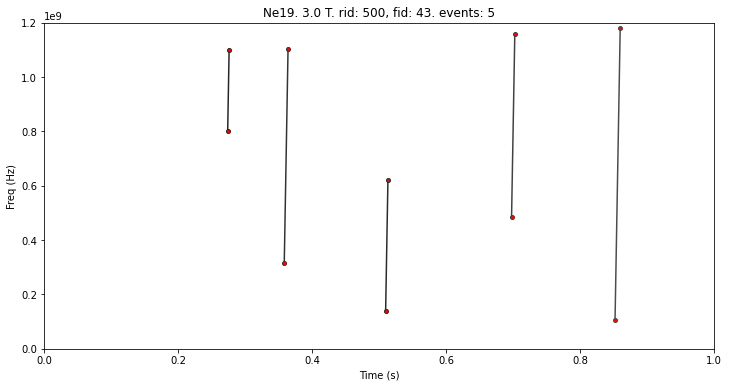

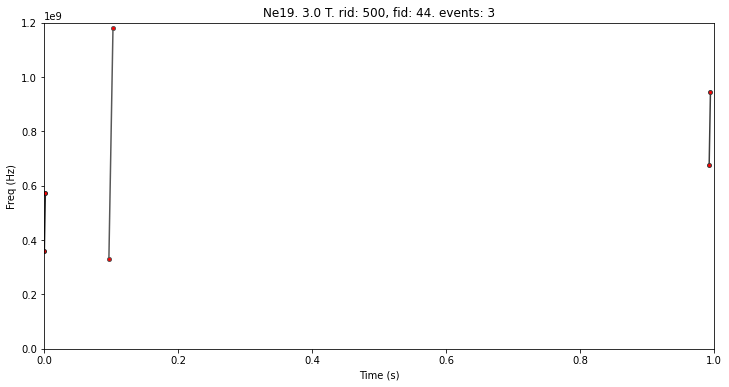

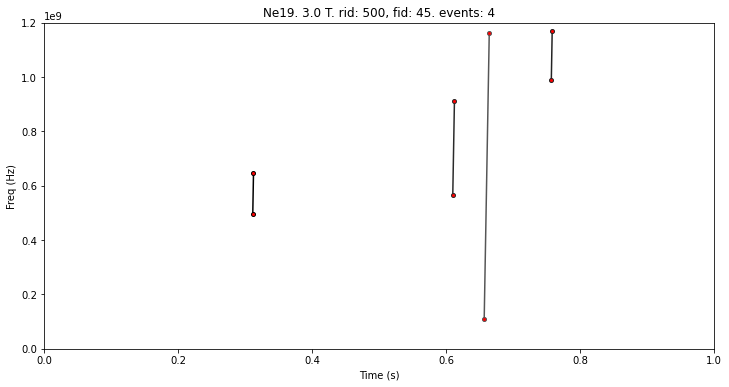

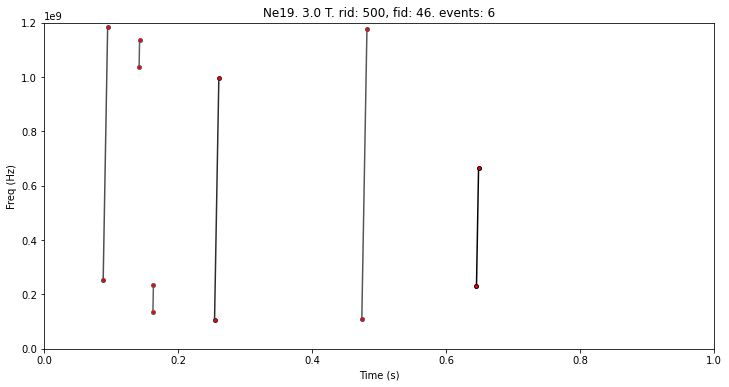

KeyboardInterrupt: 

<Figure size 864x432 with 0 Axes>

In [50]:
cut = 9
set_fields = [3.0]
fid_max = 50

events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events

events_cut_ne = re.cut_df(events_ne, ne_cuts)
events_cut_he = re.cut_df(events_he, he_cuts)

print("\n\n\nNEON")
qc.viz_events(events_cut_ne, file_id_max=fid_max, set_fields = set_fields, title = "Ne19")

print("\n\n\nHELIUM")
qc.viz_events(events_cut_he, file_id_max=fid_max, set_fields = set_fields, title = "He6")


### QC Test 4: Event property scatter plots.

* Notes: 
    * Use the scatter plot feature and make it work for he and ne. Use the following as a starting point. 

In [61]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
    
            }

additional_cuts = {
                "EventStartFreq": (200e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}

In [62]:
cut = 9

events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events

events_ne = re.add_detectability(events_ne)
events_he = re.add_detectability(events_he)

events_cut_ne = re.cut_df(events_ne, ne_cuts)
events_cut_he = re.cut_df(events_he, he_cuts)


In [63]:
%matplotlib widget

set_fields = sorted(events_cut_ne['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    field_value = widgets.Select(options = set_fields,  description='set_field: '),
    column_1 = widgets.Select(options = events_cut_ne.columns,value = 'EventStartFreq', description='x_col: '),
    column_2 = widgets.Select(options = events_cut_ne.columns,value = 'mMeanSNR', description='y_col: '),
    mrk_sz = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2),
    alpha = widgets.FloatSlider(value=.5, min=0.0,max=1.0,step=1e-2), 
    frac_pts = widgets.FloatSlider(value=0.02,min=0.0,max=1.0,step=1e-2), 
    bins = widgets.IntSlider(value=200,min=50,max=700,step=10),
    fix_field = widgets.Checkbox(
    value=False,
    description='fix field',
    disabled=False,
    indent=False),
    density_hist = widgets.Checkbox(
    value=False,
    description='density hist',
    disabled=False,
    indent=False),
    log_hist = widgets.Checkbox(
    value=False,
    description='log hist',
    disabled=False,
    indent=False
)
):
    
    cut = 9

    events_ne = snr_study["ne"][cut].events
    events_he = snr_study["he"][cut].events
    
    events_ne = re.add_detectability(events_ne)
    events_he = re.add_detectability(events_he)

    events_cut_ne = re.cut_df(events_ne, ne_cuts)
    events_cut_he = re.cut_df(events_he, he_cuts)
    


    
    plt.close("all")
    scatt_settings={
            "figsize": (10, 4),
            "colors": ["b", "r", "g", "c", "m", "k"],
            "hist_bins": 300,
            "markersize": mrk_sz,
            "alpha": .5,
        }
    
        
    if fix_field:
        condition_ne = events_cut_ne.set_field == field_value
        condition_he = events_cut_he.set_field == field_value

        events_cut_ne = events_cut_ne[condition_ne]
        events_cut_he = events_cut_he[condition_he]

    plt.close("all")
    fig0, ax0 = plt.subplots(figsize=scatt_settings["figsize"])

    ax0.set_title("Scatter: {} vs {}".format(column_1, column_2))
    ax0.set_xlabel("{}".format(column_1))
    ax0.set_ylabel("{}".format(column_2))

    # Scatter Plots
    ax0.plot(
        events_cut_ne[column_1],
        events_cut_ne[column_2],
        "o",
        markersize=scatt_settings["markersize"],
        alpha=scatt_settings["alpha"],
        color=scatt_settings["colors"][0],
        label = "Ne19"
    )

    # Scatter Plots
    ax0.plot(
        events_cut_he[column_1],
        events_cut_he[column_2],
        "o",
        markersize=scatt_settings["markersize"],
        alpha=scatt_settings["alpha"],
        color=scatt_settings["colors"][1],
        label = "He6"
        )
    ax0.legend()
    plt.show()

    # Now we want projections into the first attribute. 
    fig1, ax1 = plt.subplots(figsize=scatt_settings["figsize"])

    ax1.set_title("Histogram. x_col: {}".format(column_1))
    ax1.set_xlabel("{}".format(column_1))

    # Histogram.
    ax1.hist(
        events_cut_ne[column_1],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][0],
        histtype="step", density=density_hist,
        label = "Ne19"
    )
    ax1.hist(
        events_cut_he[column_1],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][1],
        histtype="step", density=density_hist,
        label = "He6"
    )
    if log_hist: 
        ax1.set_yscale("log")
        
    ax1.legend()
    plt.show()
    
    # Now we want projections into the second attribute. 
    fig2, ax2 = plt.subplots(figsize=scatt_settings["figsize"])

    ax2.set_title("Histogram. x_col: {}".format(column_2))
    ax2.set_xlabel("{}".format(column_2))

    # Histogram.
    ax2.hist(
        events_cut_ne[column_2],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][0],
        histtype="step", density=density_hist,
        label = "Ne19"
    )
    ax2.hist(
        events_cut_he[column_2],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][1],
        histtype="step", density=density_hist,
        label = "He6"
    )
    if log_hist: 
        ax2.set_yscale("log")
    ax2.legend()
    plt.show()

interactive(children=(Select(description='set_field: ', options=(0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2…

## **Step 3: No cuts of "from-below" events**

* MC work used here can be found here:  http://localhost:8888/lab/tree/He6CRES/rocks_analysis_notebooks/MC_thesis_studies.ipynb

**Notes**: 
* We do see slightly different track lengths for 3.25 for ne and he don't we? Could that be a clue... 
 

#### Experimental spectrum

In [9]:
both_cuts = {
            "EventStartFreq": (95e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

In [10]:
%matplotlib inline

ne_spectra = []
he_spectra = []       

snr_cuts = [9]
for cut in snr_cuts:

    ne = snr_study["ne"][cut]
    ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

    he = snr_study["he"][cut]
    he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                      "he": dict(zip(snr_cuts,he_spectra))}



#### MC spectrum (including all from below)

In [11]:
isotopes = ["Ne19", "He6"]
n_tot = 1e6
seed = 12345

set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

events_ne = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[0], cut_events = True, fix_slopes = False,
                                slew_time = .035, n = n_tot, rng_seed=seed)

events_he = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[1], cut_events = True, fix_slopes = False,
                                slew_time = .035, n = n_tot, rng_seed=seed)

# Keep the events from below.
cuts = {"EventStartFreq": (17.9e9, 19.1e9),
        "set_field": (0,np.inf)}

spectra_ne_exp, spectra_he_exp = fb.build_MC_spectra(events_ne, events_he, cuts, monitor_rate = 10**8)

# Build the experimental ratio.
ratio_pred = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)

reduced chisq: 8.185298274853816


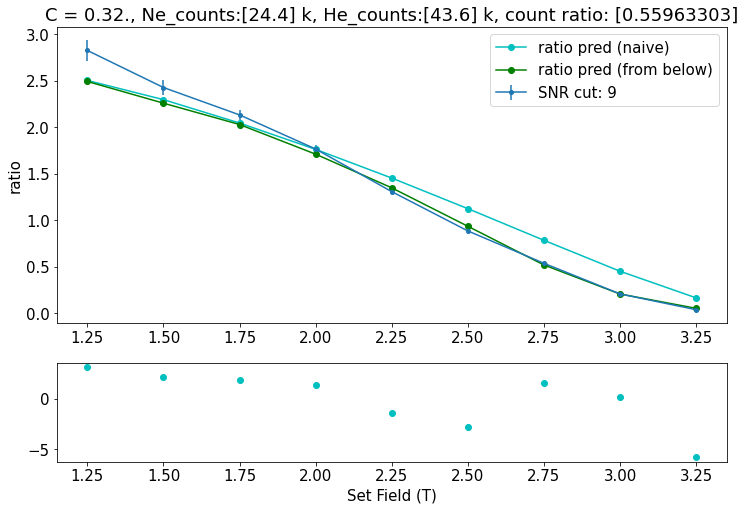

In [12]:
plt.rcParams.update({'font.size': 15})
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

ne_counts = []
he_counts = []

for cut in snr_cuts: 

    ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])
    freq_BW = np.array([18.0e9 ,  19.1e9])

    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    ratio_pred_naive = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

    ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

    # Fit to the free normalization parameter. 
    def objfunc_chisq(C, ratio_pred, ratio_exp ): 

        # I think the lmfit does the least squares on these values for you but double check. 
        chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
        return chisq_gauss

    my_pars = Parameters()
    my_pars.add('C', value=1, min=0, max = 10, vary =True)

    result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))
    print(f"reduced chisq: {result.redchi}")
    C = result.params["C"].value
    ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
    ratio_exp["sRatio"] = C*ratio_exp["sRatio"]

    pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")

    if cut == 9: 
        ax0.plot(ratio_pred_naive.index, ratio_pred_naive.Ratio, color = 'c',
                 label = "ratio pred (naive)",
                marker="o", ms=6,)
        ax0.plot(ratio_pred.index, ratio_pred.Ratio, color = 'g',
                 label = "ratio pred (from below)",
                marker="o", ms=6,)

    ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
    he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
    count_ratio = np.array(ne_counts)/np.array(he_counts)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax1.set_xlabel('Set Field (T)')
ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
ax0.legend()

ax1.plot(ratio_pred.index, (ratio_exp.Ratio - ratio_pred.Ratio)/ratio_exp.sRatio , 
         label= f"snr cut: {cut}", 
         marker="o", 
         ls = "None",
         ms=6, 
         color = "c")
plt.show()

## **Step 4: (In)Effectiveness of Veto (More Ratio Plots)**

* MC work used here can be found here:  http://localhost:8888/lab/tree/He6CRES/rocks_analysis_notebooks/MC_thesis_studies.ipynb

**Notes**:
* Here I want to show that the ratio fails but how well does it do if you make an assumption about what's failing to be vetoed. Fit to this number and show that it's consistent for differnet start freq cuts? That may not be possible. 

In [13]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

### Plot Ratio with different veto cuts. 
 

In [14]:
# Set start and stop freqs for cuts. 
freq1s = np.arange(100,1100,100)
# freq2s = np.arange(200,1200,100)
freq2s = np.ones_like(freq1s)*1200
print(f"veto start_freqs: {freq1s}\nveto end_freqs: {freq2s}")
set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

veto start_freqs: [ 100  200  300  400  500  600  700  800  900 1000]
veto end_freqs: [1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


Spectrum cut: [ 100. 1200.] MHz
BW used for predicted ratio:[1.80e+10 1.91e+10]
reduced chisq: 230.72030127514446



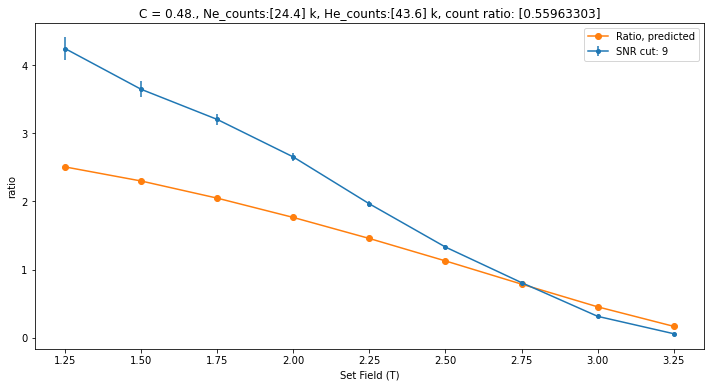

Spectrum cut: [ 200. 1200.] MHz
BW used for predicted ratio:[1.81e+10 1.91e+10]
reduced chisq: 44.67719428064991



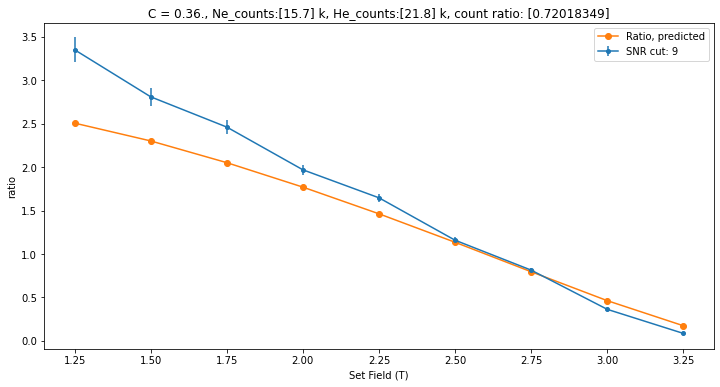

Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 21.125585279945383



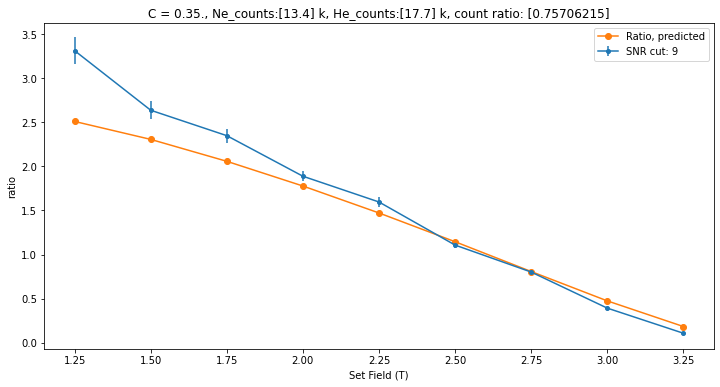

Spectrum cut: [ 400. 1200.] MHz
BW used for predicted ratio:[1.83e+10 1.91e+10]
reduced chisq: 18.31970855261268



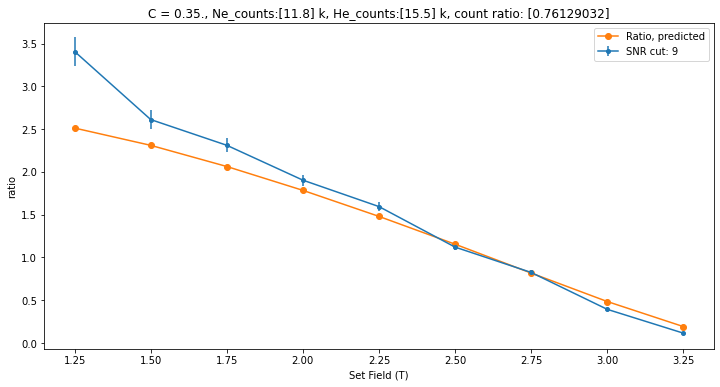

Spectrum cut: [ 500. 1200.] MHz
BW used for predicted ratio:[1.84e+10 1.91e+10]
reduced chisq: 11.556037697191679



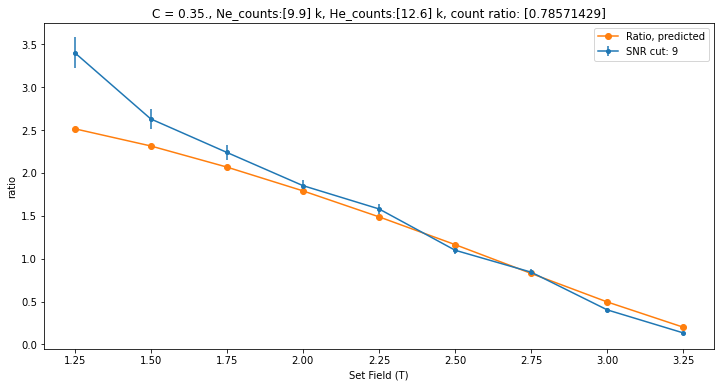

Spectrum cut: [ 600. 1200.] MHz
BW used for predicted ratio:[1.85e+10 1.91e+10]
reduced chisq: 8.103240247046289



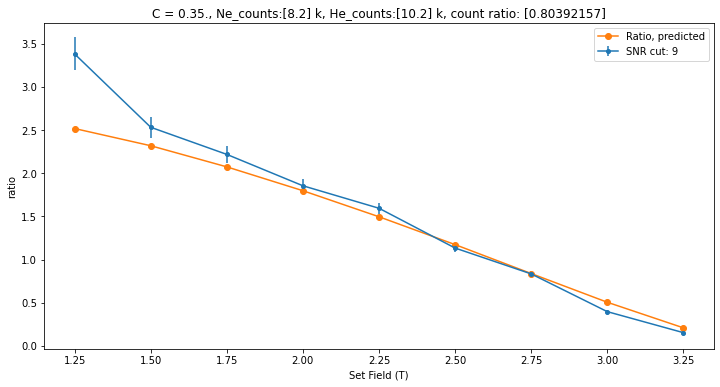

Spectrum cut: [ 700. 1200.] MHz
BW used for predicted ratio:[1.86e+10 1.91e+10]
reduced chisq: 7.265869848746039



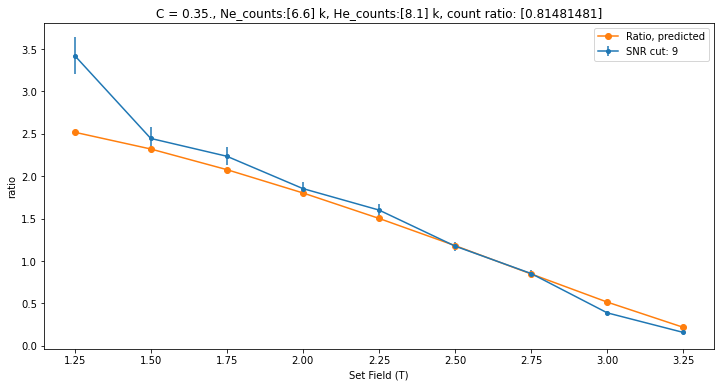

Spectrum cut: [ 800. 1200.] MHz
BW used for predicted ratio:[1.87e+10 1.91e+10]
reduced chisq: 5.405214053314144



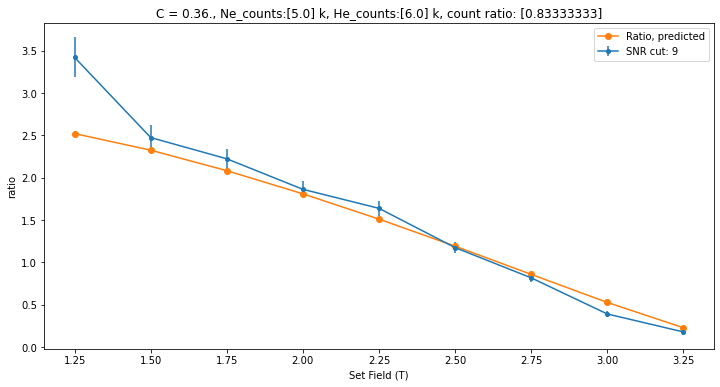

Spectrum cut: [ 900. 1200.] MHz
BW used for predicted ratio:[1.88e+10 1.91e+10]
reduced chisq: 5.113566302480025



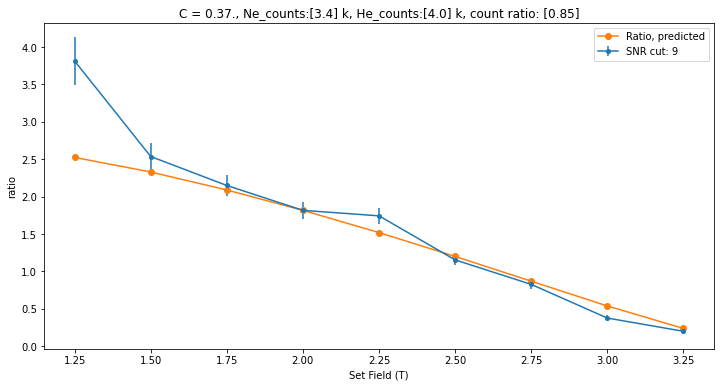

Spectrum cut: [1000. 1200.] MHz
BW used for predicted ratio:[1.89e+10 1.91e+10]
reduced chisq: 3.9111905966440608



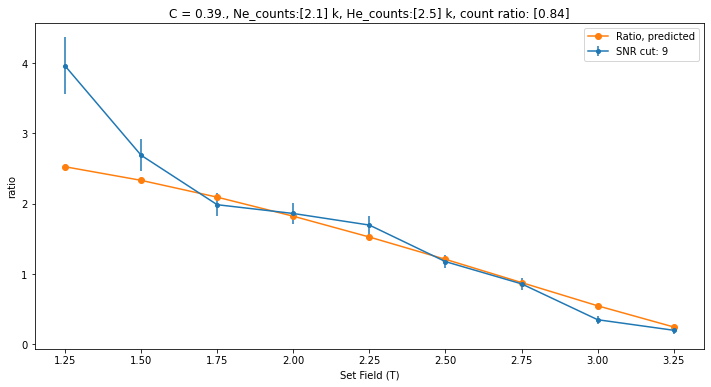

In [15]:
%matplotlib inline

plot_spectrum = False

for freq1, freq2 in zip(freq1s, freq2s):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:

        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)
        
        # Only take the fields you want: 
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=0, min=0, max = 10, vary =False)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))
        print(f"reduced chisq: {result.redchi}\n")
        C = result.params["C"].value
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")
        
        # Plot predicted ratio
        pm.plot_predicted_ratio(ratio_pred, ax0)

        ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
        he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
        count_ratio = np.array(ne_counts)/np.array(he_counts)
    
    # ax0.set_yscale("log")
    ax0.set_ylabel('ratio')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
    ax0.legend()
    plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

## **Step 5: Do events from below (failing to be vetoed) explain this behaviour?**

**Notes**:
* Here I want to show the energy domain plot. You basically have this but make it work again here and make the plot nice with the pdf.

#### Experimental spectrum

In [10]:
both_cuts = {
            "EventStartFreq": (300e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

In [11]:
%matplotlib inline

ne_spectra = []
he_spectra = []       

snr_cuts = [9]
for cut in snr_cuts:

    ne = snr_study["ne"][cut]
    ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

    he = snr_study["he"][cut]
    he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                      "he": dict(zip(snr_cuts,he_spectra))}



In [16]:
for isotope in snr_study_spectra.keys():
    efficiency_ratio = snr_study_spectra[isotope][9].tot_monitor_rate.sum() / snr_study_spectra[isotope][9].event_count.sum()
    display(efficiency_ratio)
    
18105 / 70374

4455.197861952862

15503.51343138377

0.25726830931878253

#### MC spectrum (including all from below)

In [18]:
def detection_prob(events, freq_cut = 18.2e9, start_freq = 18.0e9, end_freq = 19.0e9, p_max = .3):
    
    detection_prob = np.zeros(len(events["EventStartFreq"]))
    
    # Everything above the cut is detected w/ prob = 1.
    detection_prob[events["EventStartFreq"] >freq_cut] = 1
    
    # Veto length
    veto_len = freq_cut - start_freq
    
    # Everything 
    below_cut_events = (events["EventStartFreq"] <= freq_cut)
    
    detection_prob[below_cut_events & (events["EventEndFreq"] <=freq_cut)] = 0
    
    detection_prob[below_cut_events & (events["EventEndFreq"] >freq_cut)] = p_max* (events[below_cut_events & (events["EventEndFreq"] >freq_cut)]["EventEndFreq"]- freq_cut)/(end_freq - freq_cut)
    
    return np.clip(detection_prob,0,1)

In [19]:
isotopes = ["Ne19", "He6"]
n_tot = 1e6
seed = 12345

set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

events_ne = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[0], cut_events = True, fix_slopes = False,
                                slew_time = .035, n = n_tot, rng_seed=seed)

events_he = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[1], cut_events = True, fix_slopes = False,
                                slew_time = .035, n = n_tot, rng_seed=seed)

within_cut = {"EventStartFreq": (17.99e9, 19.1e9)}

events_ne = fb.cut_df(events_ne, within_cut)
events_he = fb.cut_df(events_he, within_cut)

(721332, 15)


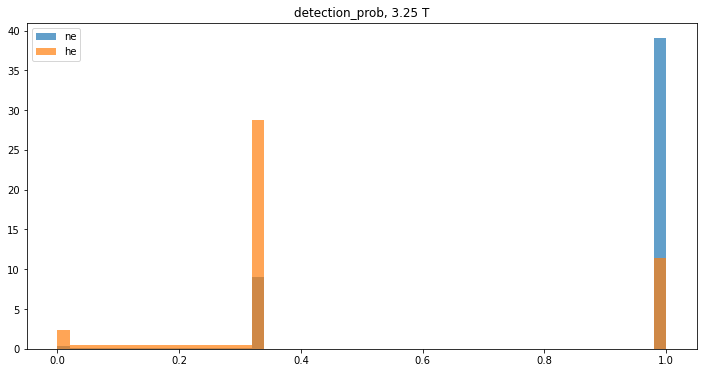

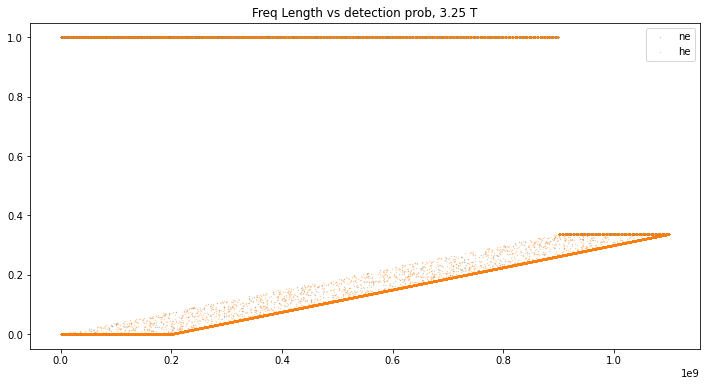

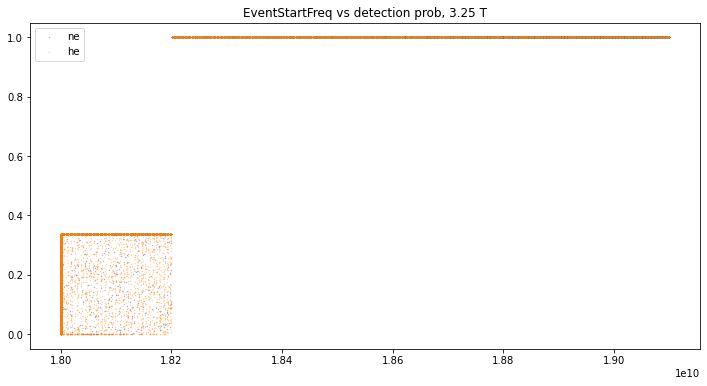

In [20]:
print(events_ne.shape)
events_ne["detection_prob"] = detection_prob(events_ne, p_max = .3)
events_he["detection_prob"] = detection_prob(events_he, p_max = .3)

for set_field in events_ne.set_field.unique(): 
    if set_field!= 3.25: continue
    
    
    condition_ne = (events_ne.set_field == set_field)
    condition_he = (events_he.set_field == set_field)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    

    plt.hist(events_ne[condition_ne].detection_prob, bins = 50, label = "ne", alpha = .7, density = True)
    plt.hist(events_he[condition_he].detection_prob, bins = 50, label = "he", alpha = .7, density = True)
    plt.title(f"detection_prob, {set_field} T")
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    plt.scatter(events_ne[condition_ne].FreqLength, events_ne[condition_ne].detection_prob,  
                label = "ne", alpha = .5, s= .1)
    plt.scatter(events_he[condition_he].FreqLength, events_he[condition_he].detection_prob,  
                label = "he", alpha = .5, s= .1)
    plt.title(f"Freq Length vs detection prob, {set_field} T")
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.scatter(events_ne[condition_ne].EventStartFreq, events_ne[condition_ne].detection_prob,  
                label = "ne", alpha = .7, s= .1)
    plt.scatter(events_he[condition_he].EventStartFreq, events_he[condition_he].detection_prob,  
                label = "he", alpha = .5, s= .1)

    plt.title(f"EventStartFreq vs detection prob, {set_field} T")
    plt.legend()
    plt.show()

# Keep the events from below.
cuts = {"EventStartFreq": (17.9e9, 19.1e9),
        "set_field": (0,np.inf)}

spectra_ne_exp, spectra_he_exp = fb.build_MC_spectra_alt(events_ne, events_he, cuts, monitor_rate = 10**8)

# Build the experimental ratio.
ratio_pred = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)

In [21]:
def objfunc_pmax_chisq(my_pars, events_ne, events_he, ratio_exp): 

    C =my_pars["C"].value
    p_max =my_pars["p_max"].value
    print(C, p_max)
    
    events_ne["detection_prob"] = detection_prob(events_ne, p_max = p_max  )
    events_he["detection_prob"] = detection_prob(events_he, p_max = p_max )
    spectra_ne_exp, spectra_he_exp = fb.build_MC_spectra_alt(events_ne, events_he, cuts, monitor_rate = 10**9)
    ratio_pred = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)
    # print(ratio_pred.max())
    chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])

    return chisq_gauss

0.3400000000000003 1.9
0.3400000000000003 1.9
0.3400000000000003 1.9
0.36208047571061774 1.9
0.3400000000000003 1.926303959564653
0.3018996325545631 3.701847526171952
0.32315097698611017 3.701847526171952
0.3018996325545631 3.5633932629590612
0.3079923823584063 3.201628762360783
0.29792010633906185 5.495819424534741
0.3190788023362462 5.495819424534741
0.29792010633906185 5.500761057000561
0.286493962690631 9.030898869321417
0.30737972068619723 9.030898869321417
0.286493962690631 9.058460757009401
0.2875754911200157 6.984778041620706
0.3084875344606408 6.984778041620706
0.2875754911200157 7.003494410746457
0.28874662183178745 5.5675308566313095
0.309687020258812 5.5675308566313095
0.28874662183178745 5.573181297368964
0.28869701917109913 5.887016795765664
0.28869701917109913 5.887016795765664
0.28870766465788955 5.709165964165537
0.28873495310958175 5.601282850209138
0.2887433138109946 5.576678557654486
0.3096836323026092 5.576678557654486
0.2887433138109946 5.582419249024112
0.2887421

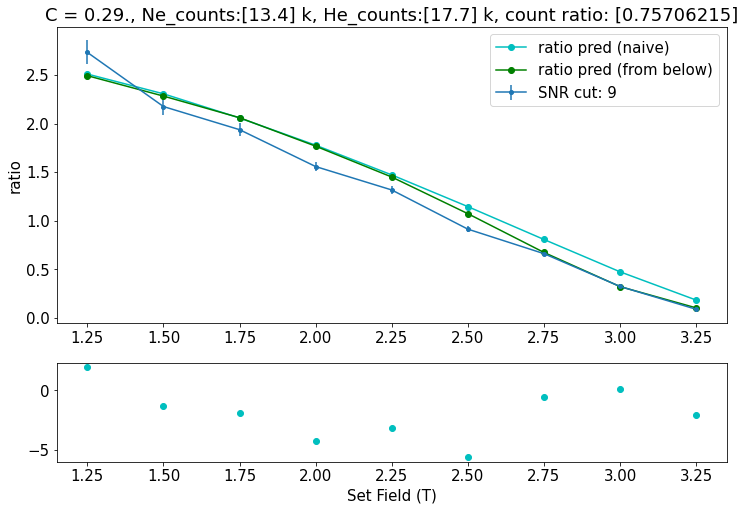

In [22]:
plt.rcParams.update({'font.size': 15})
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

ne_counts = []
he_counts = []

for cut in snr_cuts: 

    ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])
    freq_BW = np.array([18.2e9 ,  19.1e9])

    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    ratio_pred_naive = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

    ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

#     # Fit to the free normalization parameter. 
#     def objfunc_chisq(C, ratio_pred, ratio_exp ): 

#         # I think the lmfit does the least squares on these values for you but double check. 
#         chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
#         return chisq_gauss

    my_pars = Parameters()
    my_pars.add('C', value=.34, min=0, max = 10, vary =True)
    my_pars.add('p_max', value=1.9, min=0, max = 10, vary =True)
    
    # objfunc_pmax_chisq(my_pars, events_ne, events_he, ratio_exp)
    # result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))
    result = minimize(objfunc_pmax_chisq, my_pars, args = (events_ne, events_he, ratio_exp),epsfcn=1e-4)

    C = result.params["C"].value
    p_max = result.params["p_max"].value
    print(f"reduced chisq: {result.redchi}")
    print(f"C: {C}")
    print(f"p_max: {p_max}")
    
    ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
    ratio_exp["sRatio"] = C*ratio_exp["sRatio"]

    pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")

    if cut == 9: 
        ax0.plot(ratio_pred_naive.index, ratio_pred_naive.Ratio, color = 'c',
                 label = "ratio pred (naive)",
                marker="o", ms=6,)
        ax0.plot(ratio_pred.index, ratio_pred.Ratio, color = 'g',
                 label = "ratio pred (from below)",
                marker="o", ms=6,)

    ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
    he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
    count_ratio = np.array(ne_counts)/np.array(he_counts)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax1.set_xlabel('Set Field (T)')
ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
ax0.legend()

ax1.plot(ratio_pred.index, (ratio_exp.Ratio - ratio_pred.Ratio)/ratio_exp.sRatio , 
         label= f"snr cut: {cut}", 
         marker="o", 
         ls = "None",
         ms=6, 
         color = "c")
plt.show()

## **Step 6: Why can't we successfully veto from below??**

* MC work used here can be found here:  http://localhost:8888/lab/tree/He6CRES/rocks_analysis_notebooks/MC_thesis_studies.ipynb

**Notes**:
* Here I want to try a field-wise SNR cut and a field-wise track length or "Fraction_covered". Maybe make this cut and then cut on start freq? Try it out. Be quick. Make it integrate into the cut_df method in a way that 
* See if it matters what order the cuts are applied (event-wise frist vs second)
* To visualize how many events are being cut vs field, add in the argument "diagnostics = True"  

**Thoughts**: 
* Why is a field-wise cut working here? The key is that you are applying an SNR cut and then a cut on start frequency. If you do it in the opposite order you leave the ratio unaffected (in the case of a median). Would like to understand the mechanism here better, but makes loose sense. 
* Looking into event track coverage as well. This seems to work ok as well? 

In [23]:
# Could also use a custom agg function in place of the aggregate str (like "median" for example). 
def quantile(x, q = .5 ):
    return x.quantile(q)

both_cuts = {"field_wise":{
                "mMeanSNR":[quantile, (-np.inf,np.inf)],
                "EventTrackCoverage":[quantile, (1, np.inf)],
                "EventTimeLength":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

### Plot Ratio with different veto cuts. 
 

In [24]:
# Set start and stop freqs for cuts. 
freq1s = np.arange(100,1100,100)
freq2s = np.arange(200,1200,100)
# freq2s = np.ones_like(freq1s)*1200
print(f"veto start_freqs: {freq1s}\nveto end_freqs: {freq2s}")
set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

veto start_freqs: [ 100  200  300  400  500  600  700  800  900 1000]
veto end_freqs: [ 200  300  400  500  600  700  800  900 1000 1100]


Spectrum cut: [100. 200.] MHz
BW used for predicted ratio:[1.80e+10 1.81e+10]
reduced chisq: 50.9404264086026

[[Variables]]
    C:  0.47954494 +/- 0.06995372 (14.59%) (init = 1)
    b: -1.47010007 +/- 0.31144774 (21.19%) (init = 0.05)


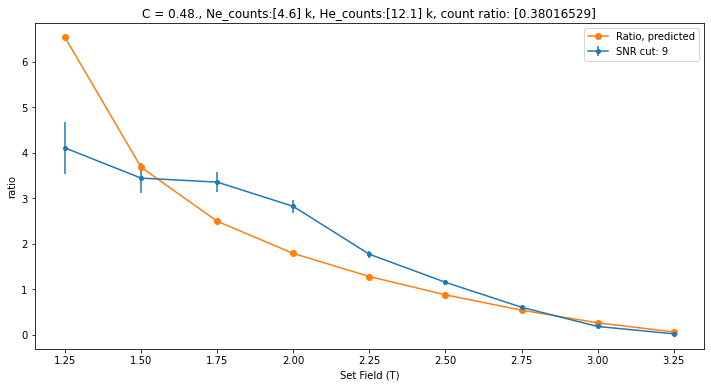

Spectrum cut: [200. 300.] MHz
BW used for predicted ratio:[1.81e+10 1.82e+10]
reduced chisq: 1.4524997466701406

[[Variables]]
    C:  0.34053068 +/- 0.01829835 (5.37%) (init = 1)
    b: -0.34982970 +/- 0.30171401 (86.25%) (init = 0.05)


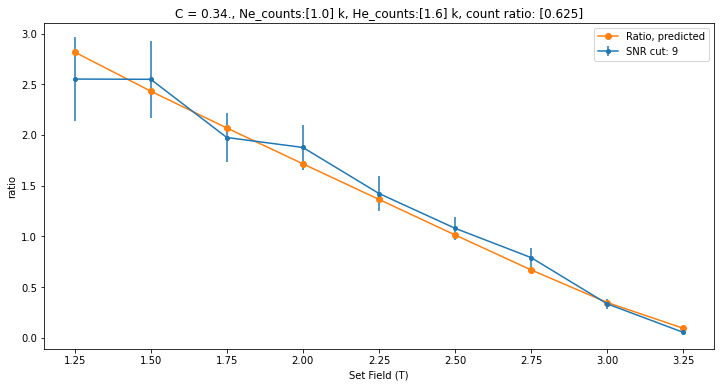

Spectrum cut: [300. 400.] MHz
BW used for predicted ratio:[1.82e+10 1.83e+10]
reduced chisq: 1.5018317886653327

[[Variables]]
    C:  0.35241067 +/- 0.02117531 (6.01%) (init = 1)
    b: -0.47919261 +/- 0.31812359 (66.39%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = -0.105


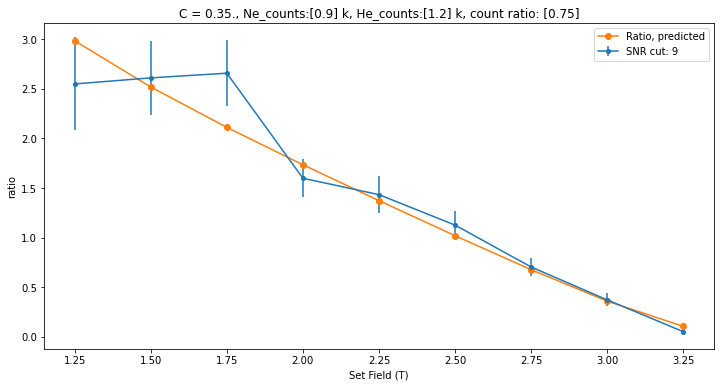

Spectrum cut: [400. 500.] MHz
BW used for predicted ratio:[1.83e+10 1.84e+10]
reduced chisq: 0.6575576217165217

[[Variables]]
    C:  0.35171948 +/- 0.01291436 (3.67%) (init = 1)
    b: -0.16318849 +/- 0.22592849 (138.45%) (init = 0.05)


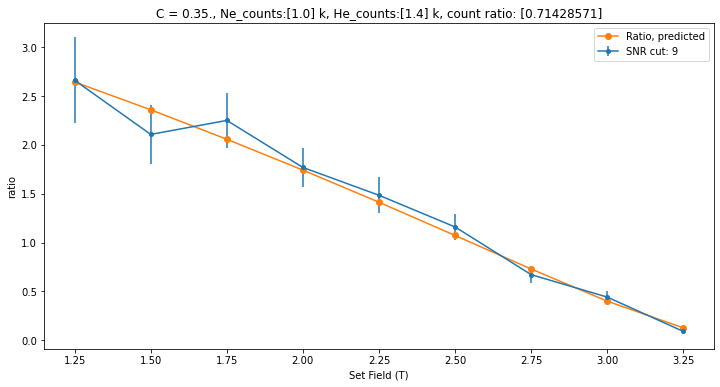

Spectrum cut: [500. 600.] MHz
BW used for predicted ratio:[1.84e+10 1.85e+10]
reduced chisq: 1.3806991577803036

[[Variables]]
    C:  0.34884038 +/- 0.02017442 (5.78%) (init = 1)
    b: -0.90727317 +/- 0.21310507 (23.49%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = -0.282


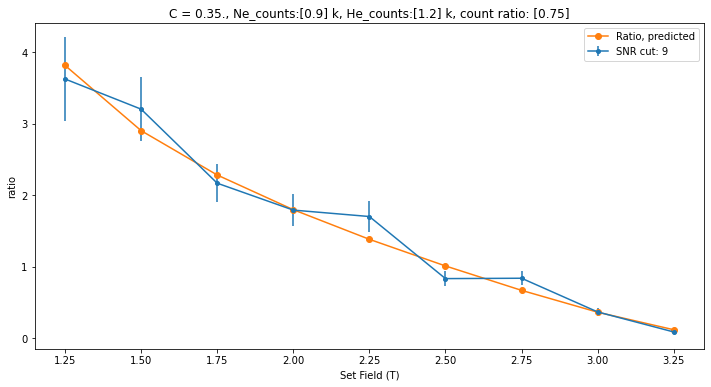

Spectrum cut: [600. 700.] MHz
BW used for predicted ratio:[1.85e+10 1.86e+10]
reduced chisq: 0.7475268431717155

[[Variables]]
    C:  0.35689780 +/- 0.01621361 (4.54%) (init = 1)
    b: -0.79388647 +/- 0.19859143 (25.02%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = -0.251


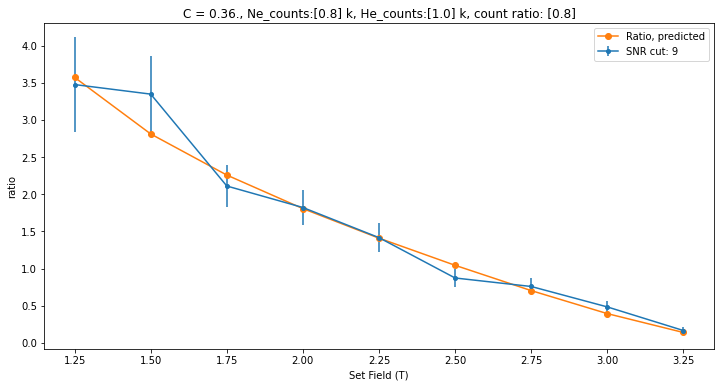

Spectrum cut: [700. 800.] MHz
BW used for predicted ratio:[1.86e+10 1.87e+10]
reduced chisq: 1.71506070361127

[[Variables]]
    C:  0.31727604 +/- 0.02169330 (6.84%) (init = 1)
    b: -0.08441017 +/- 0.41020855 (485.97%) (init = 0.05)


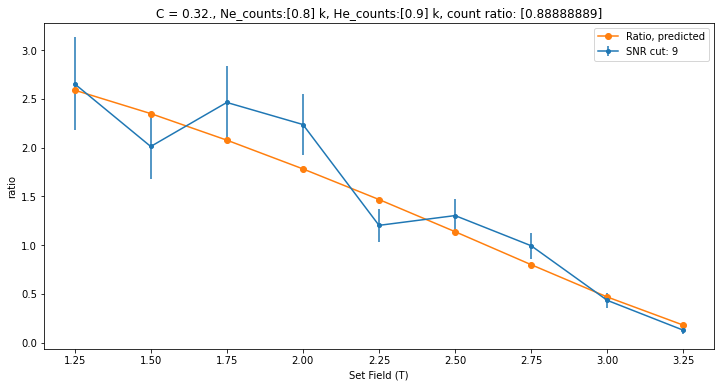

Spectrum cut: [800. 900.] MHz
BW used for predicted ratio:[1.87e+10 1.88e+10]
reduced chisq: 1.5158624917545147

[[Variables]]
    C:  0.30526107 +/- 0.02102423 (6.89%) (init = 1)
    b:  0.02631595 +/- 0.37650182 (1430.70%) (init = 0.05)


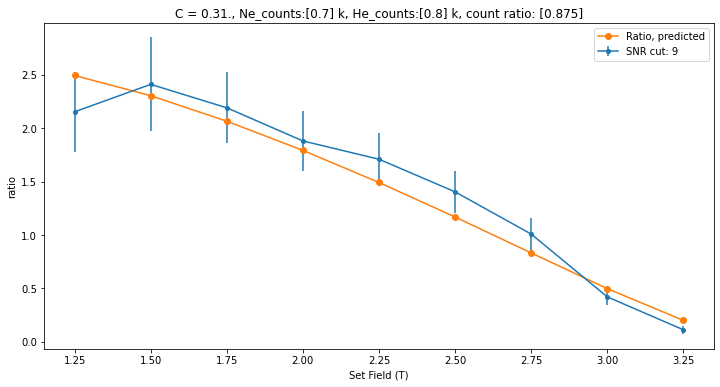

Spectrum cut: [ 900. 1000.] MHz
BW used for predicted ratio:[1.88e+10 1.89e+10]
reduced chisq: 1.277729581725726

[[Variables]]
    C:  0.29586834 +/- 0.02198778 (7.43%) (init = 1)
    b: -0.40804548 +/- 0.42731462 (104.72%) (init = 0.05)


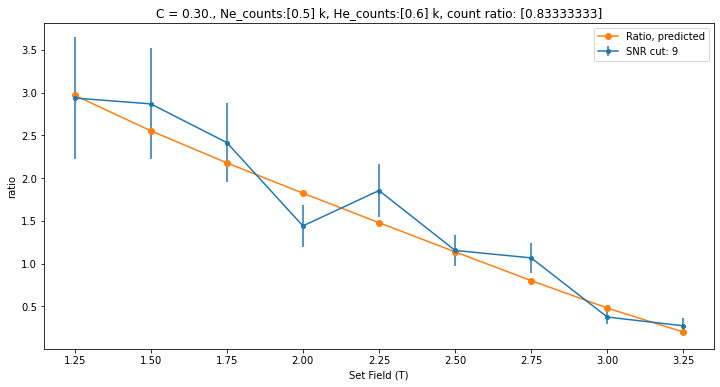

Spectrum cut: [1000. 1100.] MHz
BW used for predicted ratio:[1.89e+10 1.90e+10]
reduced chisq: 1.1916092593897336

[[Variables]]
    C:  0.31690752 +/- 0.02057632 (6.49%) (init = 1)
    b: -0.07555724 +/- 0.49433567 (654.25%) (init = 0.05)


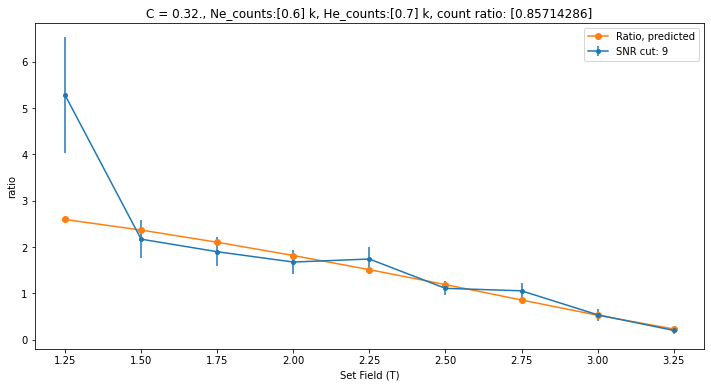

In [25]:
%matplotlib inline

plot_spectrum = False

for freq1, freq2 in zip(freq1s, freq2s):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:
        diagnostics = False
        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts, diagnostics = diagnostics))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts, diagnostics = diagnostics))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        # Only take the fields you want: 
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=.050, min=-10, max = 10, vary =True)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp), method = 'least_squares')
        # report(out)
        # Fit report.
        print(f"reduced chisq: {result.redchi}\n")
        print(fit_report(result.params))
        
        C = result.params["C"].value
        b = result.params["b"].value
        
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
        
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        
        pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")
        
        # Plot predicted ratio
        pm.plot_predicted_ratio(ratio_pred, ax0)

        ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
        he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
        count_ratio = np.array(ne_counts)/np.array(he_counts)
    
    # ax0.set_yscale("log")
    ax0.set_ylabel('ratio')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
    ax0.legend()
    plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

#### Verifying that this cut is getting rid of low SNR "from-below" tracks.

**Notes**: Here we want to apply an increasing snr cut to a 

In [26]:
# Could also use a custom agg function in place of the aggregate str (like "median" for example). 
def quantile(x, q = .5 ):
    return x.quantile(q)

both_cuts = {"field_wise":{
                "mMeanSNR":[quantile, (1,np.inf)],
                "EventTrackCoverage":[quantile, (1, np.inf)],
                "EventTimeLength":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

In [27]:
# Set start and stop freqs for cuts. 
freq1s = np.arange(100,1100,100)
# freq2s = np.arange(200,1200,100)
freq2s = np.ones_like(freq1s)*1200
print(f"veto start_freqs: {freq1s}\nveto end_freqs: {freq2s}")
set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

veto start_freqs: [ 100  200  300  400  500  600  700  800  900 1000]
veto end_freqs: [1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 21.12558527994539

[[Variables]]
    C:  0.35006095 +/- 0.01998737 (5.71%) (init = 1)
    b:  0 (fixed)
Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 17.507222313078145

[[Variables]]
    C:  0.34523077 +/- 0.01895601 (5.49%) (init = 1)
    b:  0 (fixed)
Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 13.251128495443828

[[Variables]]
    C:  0.34017950 +/- 0.01727047 (5.08%) (init = 1)
    b:  0 (fixed)
Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 9.673077981647001

[[Variables]]
    C:  0.33804865 +/- 0.01574750 (4.66%) (init = 1)
    b:  0 (fixed)
Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 7.735116226770127

[[Variables]]
    C:  0.33718274 +/- 0.01522237 (4.51%) (init = 1)
    b:  0 (fixed)
Spe

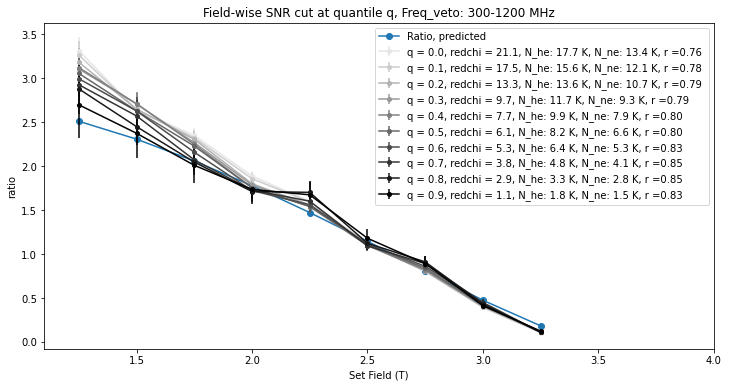

In [28]:
%matplotlib inline

plot_spectrum = False

freq1 = 300
freq2 = 1200

qs = np.arange(0, 1,.1)
fig0, ax0 = plt.subplots(figsize=(12,6))
for i,q in enumerate(qs):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }
    def quantile(x, q = q ):
        return x.quantile(q)

    both_cuts = {"field_wise":{
                    "mMeanSNR":[quantile, (-np.inf,np.inf)],
                    "EventTrackCoverage":[quantile, (1, np.inf)],
                    "EventTimeLength":["median", (-np.inf,np.inf)]},
                "EventStartFreq": (0e6, 1200e6),
                "EventNBins": (0, np.inf), 
                "EventStartTime": (.0001,np.inf),
                "EventTimeLength": (0,.05),
                "EventTimeIntc": (-.5e7,np.inf),
                "EventFreqIntc": (-2e11,np.inf),
                "EventSlope": (.01e10, np.inf),
                "EventTrackCoverage": (0, np.inf),
                "mTotalSNR": (40,  np.inf),
                "mTotalPower": (0, np.inf), 
                "mTotalNUP": (0,np.inf),
                "mMaxSNR": (0,np.inf),
                "detectability": (0,np.inf), 
                "mMeanSNR": (0,np.inf),
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:
        diagnostics = False
        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts, diagnostics = diagnostics))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts, diagnostics = diagnostics))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        # Only take the fields you want: 
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=0, min=-10, max = 10, vary =False)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp), method = 'least_squares')
        # report(out)
        # Fit report.
        print(f"reduced chisq: {result.redchi}\n")
        print(fit_report(result.params))
        
        C = result.params["C"].value
        b = result.params["b"].value
        b_err = result.params["b"].stderr
        
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
        
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        
        ne_counts = snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000
        he_counts= snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000
        
        ax0.errorbar(ratio_exp.index, ratio_exp.Ratio, yerr = ratio_exp.sRatio, color = f"{.9-q}",
                label = f"q = {q:.1f}, redchi = {result.redchi:.1f}, N_he: {he_counts:.1f} K, N_ne: {ne_counts:.1f} K, r ={ne_counts/he_counts:.2f} ",
                marker="o", ms=4,)
        # ax0.errorbar(ratio_exp.index, ratio_exp.Ratio, yerr = ratio_exp.sRatio, color = f"{.9-q}",
        #         label = f"q = {q:.1f}, redchi = {result.redchi:.1f}, N_ne/N_he = r ={ne_counts/he_counts:.2f}, b = {b:.2f} +- {b_err:.2f}  ",
        #         marker="o", ms=4,)
        # Plot predicted ratio
        if i ==0:
            pm.plot_predicted_ratio(ratio_pred, ax0)

        ne_counts = snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000
        he_counts= snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000

    
    # ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title(f"Field-wise SNR cut at quantile q, Freq_veto: {freq1}-{freq2} MHz")
ax0.legend()
ax0.set_xlim(1.1,4)
plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

#### Plot for Alejandro.

**Notes**:
* This can make it into the 

Spectrum cut: [ 400. 1200.] MHz
BW used for predicted ratio:[1.83e+10 1.91e+10]
reduced chisq: 2.0863157522183355

[[Variables]]
    C:  0.33310655 +/- 0.01134971 (3.41%) (init = 1)
    b:  0 (fixed)


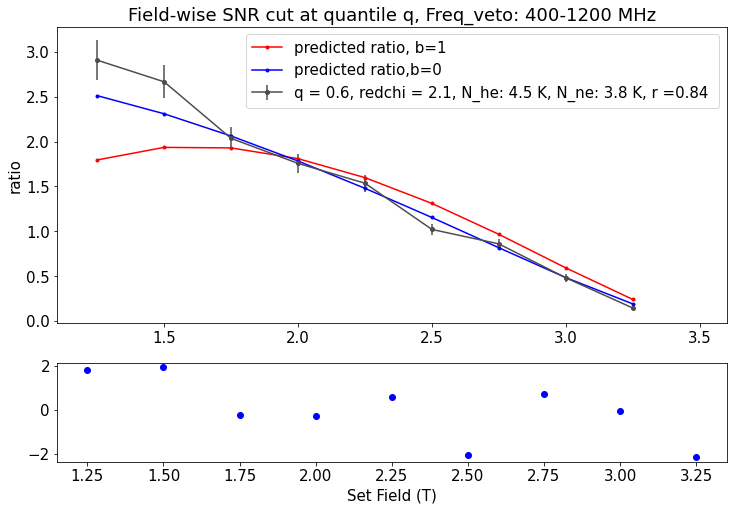

In [29]:
%matplotlib inline

plot_spectrum = False

freq1 = 400
freq2 = 1200

qs = np.array([.6])
# fig0, ax0 = plt.subplots(figsize=(12,6))
plt.rcParams.update({'font.size': 15})
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

for i,q in enumerate(qs):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }
    def quantile(x, q = q ):
        return x.quantile(q)

    both_cuts = {"field_wise":{
                    "mMeanSNR":[quantile, (1,np.inf)],
                    "EventTimeLength":["median", (-np.inf,np.inf)]},
                "EventStartFreq": (0e6, 1200e6),
                "EventNBins": (0, np.inf), 
                "EventStartTime": (.0001,np.inf),
                "EventTimeLength": (0,.05),
                "EventTimeIntc": (-.5e7,np.inf),
                "EventFreqIntc": (-2e11,np.inf),
                "EventSlope": (.01e10, np.inf),
                "EventTrackCoverage": (0, np.inf),
                "mTotalSNR": (40,  np.inf),
                "mTotalPower": (0, np.inf), 
                "mTotalNUP": (0,np.inf),
                "mMaxSNR": (0,np.inf),
                "detectability": (0,np.inf), 
                "mMeanSNR": (0,np.inf),
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:
        diagnostics = False
        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts, diagnostics = diagnostics))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts, diagnostics = diagnostics))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        # Only take the fields you want: 
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=0, min=-10, max = 10, vary =False)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp), method = 'least_squares')
        # report(out)
        # Fit report.
        print(f"reduced chisq: {result.redchi}\n")
        print(fit_report(result.params))
        
        C = result.params["C"].value
        b = result.params["b"].value
        b_err = result.params["b"].stderr
        
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
        ratio_pred_b = rp.AUC_expectation(set_fields, freq_BWs, b = 1.0, plot = False)[ratio_pred.index.isin(set_fields)]
        
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        
        ne_counts = snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000
        he_counts= snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000
        
        ax0.errorbar(ratio_exp.index, ratio_exp.Ratio, yerr = ratio_exp.sRatio, color = f"{.9-q}",
                label = f"q = {q:.1f}, redchi = {result.redchi:.1f}, N_he: {he_counts:.1f} K, N_ne: {ne_counts:.1f} K, r ={ne_counts/he_counts:.2f} ",
                marker="o", ms=4,)
        ax0.plot(ratio_pred_b.index, ratio_pred_b.Ratio, color = f"r",
                label = f"predicted ratio, b=1",
                marker="o", ms=3,)
        ax0.plot(ratio_pred.index, ratio_pred.Ratio, color = f"b",
                label = f"predicted ratio,b=0",
                marker="o", ms=3,)
        # ax0.errorbar(ratio_exp.index, ratio_exp.Ratio, yerr = ratio_exp.sRatio, color = f"{.9-q}",
        #         label = f"q = {q:.1f}, redchi = {result.redchi:.1f}, N_ne/N_he = r ={ne_counts/he_counts:.2f}, b = {b:.2f} +- {b_err:.2f}  ",
        #         marker="o", ms=4,)
        # Plot predicted ratio
        # if i ==0:
        #     pm.plot_predicted_ratio(ratio_pred, ax0)
            

        ne_counts = snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000
        he_counts= snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000

    
    # ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax1.set_xlabel('Set Field (T)')
ax0.set_title(f"Field-wise SNR cut at quantile q, Freq_veto: {freq1}-{freq2} MHz")
ax0.legend()
ax0.set_xlim(1.1,3.6)

ax1.plot(ratio_pred.index, (ratio_exp.Ratio - ratio_pred.Ratio)/ratio_exp.sRatio , 
         label= f"snr cut: {cut}", 
         marker="o", 
         ls = "None",
         ms=6, 
         color = "b")

plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

0.3400000000000003 1.9
0.3400000000000003 1.9
0.3400000000000003 1.9
0.36208047571061774 1.9
0.3400000000000003 1.926303959564653
0.31226996758577596 8.636091222912167
0.33375713758951375 8.636091222912167
0.31226996758577596 8.818256634069279
0.2977189447161388 8.463770605399363
0.31887292495747177 8.463770605399363
0.2977189447161388 7.825557439361372
0.2987005367606488 8.42214121086598
0.29650886096952433 9.979104269928273
0.295544690184123 0.24595844843369907
0.3166474987641932 0.24595844843369907
0.295544690184123 0.5047109446956283
0.3250900463314471 0.03831068564044915
0.3468580182268399 0.03831068564044915
0.3250900463314471 0.1732347937774631
0.32406194659659715 0.05353952328013334
0.3458078223795258 0.05353952328013334
0.32406194659659715 0.20363524568682345
0.3241837432851452 0.05511074467610566
0.3459322405235832 0.05511074467610566
0.3241837432851452 0.2066349795373973
0.32417262866760554 0.055203603575624816
0.32417262866760554 0.055203603575624816
0.3241836099416362 0.05

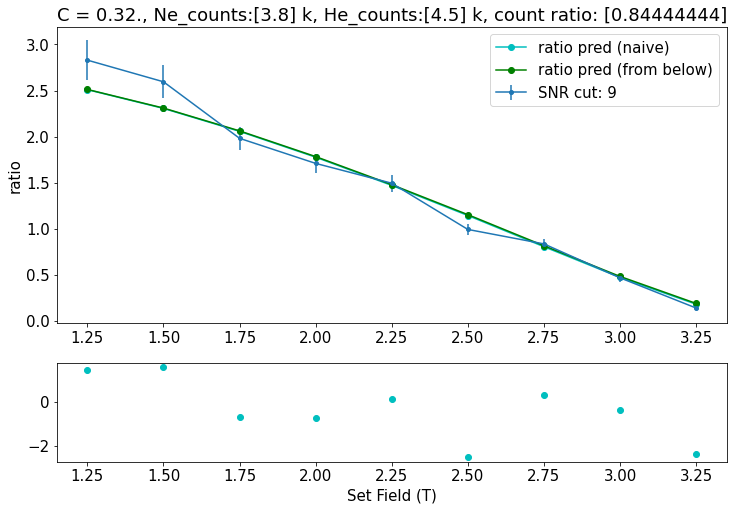

In [30]:
plt.rcParams.update({'font.size': 15})
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

ne_counts = []
he_counts = []

for cut in snr_cuts: 

    ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])
    freq_BW = np.array([18.2e9 ,  19.1e9])

    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    ratio_pred_naive = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

    ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

#     # Fit to the free normalization parameter. 
#     def objfunc_chisq(C, ratio_pred, ratio_exp ): 

#         # I think the lmfit does the least squares on these values for you but double check. 
#         chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
#         return chisq_gauss

    my_pars = Parameters()
    my_pars.add('C', value=.34, min=0, max = 10, vary =True)
    my_pars.add('p_max', value=1.9, min=0, max = 10, vary =True)
    
    # objfunc_pmax_chisq(my_pars, events_ne, events_he, ratio_exp)
    # result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))
    result = minimize(objfunc_pmax_chisq, my_pars, args = (events_ne, events_he, ratio_exp),epsfcn=1e-4)

    C = result.params["C"].value
    p_max = result.params["p_max"].value
    print(f"reduced chisq: {result.redchi}")
    print(f"C: {C}")
    print(f"p_max: {p_max}")
    
    ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
    ratio_exp["sRatio"] = C*ratio_exp["sRatio"]

    pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")

    if cut == 9: 
        ax0.plot(ratio_pred_naive.index, ratio_pred_naive.Ratio, color = 'c',
                 label = "ratio pred (naive)",
                marker="o", ms=6,)
        ax0.plot(ratio_pred.index, ratio_pred.Ratio, color = 'g',
                 label = "ratio pred (from below)",
                marker="o", ms=6,)

    ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
    he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
    count_ratio = np.array(ne_counts)/np.array(he_counts)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax1.set_xlabel('Set Field (T)')
ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
ax0.legend()

ax1.plot(ratio_pred.index, (ratio_exp.Ratio - ratio_pred.Ratio)/ratio_exp.sRatio , 
         label= f"snr cut: {cut}", 
         marker="o", 
         ls = "None",
         ms=6, 
         color = "c")
plt.show()

## **Step 7: Energy domain plot**

**Notes**:
* Here I want to show the energy domain plot. You basically have this but make it work again here and make the plot nice with the pdf.    

In [74]:
def quantile(x, q = .4 ):
        return x.quantile(q)

both_cuts = {
            "field_wise":{
                    "mMeanSNR":[quantile, (1,np.inf)],
                    "EventTimeLength":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
            }

In [30]:

both_cuts = {"field_wise":{
                "mMeanSNR":["median", (1,np.inf)],
                "EventTrackCoverage":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

1
[300000000.0, 1300000000.0]
[1.82e+10 1.92e+10]
[[Variables]]
    C:  0.33689583 +/- 0.00819061 (2.43%) (init = 1)
    b: -0.60064721 +/- 0.21599021 (35.96%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = 0.243


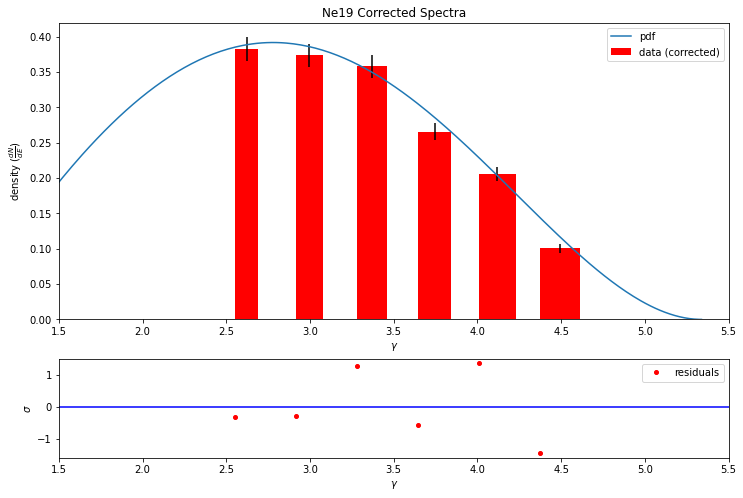

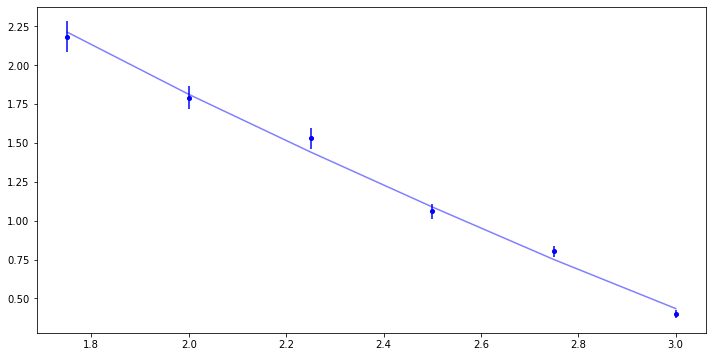

In [78]:
%matplotlib inline

# Plot results.
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

set_fields = np.arange(1.75,3.25,.25)
snr_cuts = [9]
mixer_freq = 17.9e9
b=0

b_fits = []
b_errs = []

# Feed the info dict to the BetaSpectrum class.
isotopes = {"Ne19": {"b": -0.7204 * b}, "He6": {"b": b}}
bspec = bs.BetaSpectrum("Ne19", b = 0)


Ws = np.linspace(1.001, bspec.W0-.001, 300)
pdf = bspec.dNdE(Ws)

# for (freq1, freq2) in zip(np.arange(100,1100, 100),np.arange(300,1300, 100)):

freq_BW_full = np.array([18.2e9 ,  19.2e9])
freq_BW_tot = freq_BW_full[1] - freq_BW_full[0]
freq_chunk = 1000e6
n_chunks = int(np.ceil((freq_BW_tot / freq_chunk)))
print(n_chunks)

b_fits = []
b_errs = []

for i,chunk in enumerate(range(n_chunks)):
    
    freq_BW = np.clip(np.array([freq_BW_full[0]+ freq_chunk*chunk, freq_BW_full[0]+ freq_chunk*(chunk+1)]), 
                      0,freq_BW_full.max())
        
    spectrum_cuts = {
                "EventStartFreq": (freq_BW[0]- mixer_freq, freq_BW[1]-mixer_freq)
                }
    print([spectrum_cuts["EventStartFreq"][0] ,  spectrum_cuts["EventStartFreq"][1]])
    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:
        
        ne = snr_study["ne"][cut]
        
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}


    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([mixer_freq+ spectrum_cuts["EventStartFreq"][0] ,  mixer_freq + spectrum_cuts["EventStartFreq"][1]])
        print(freq_BW)
        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))
        # print(freq_BWs)

        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]


            # Conduct fit. 
        my_pars = Parameters()
        my_pars.add('C', value=1, min=-100, max = 100, vary =True)
        my_pars.add('b', value=0, min=-10, max = 10, vary =True)

        result = minimize(we.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))

        # Fit report.
        print(fit_report(result.params))

        C = result.params["C"].value
        b = result.params["b"].value

        # Get the SM prediction.
        ratio_pred = we.AUC_expectation_we(set_fields, freq_BWs, b = b, plot = False, wall_effect = False)

        ratio_corr = ratio_exp.copy()
        ratio_corr["Ne19_corr"] = C*ratio_pred["He6"]*ratio_exp["Ratio"]
        ratio_corr["sNe19_corr"] = C*ratio_pred["He6"]*ratio_exp["sRatio"]

        gamma_acceptances, gamma_widths, gamma_heights, gamma_height_errs, SM_heights = ed.freq_to_energy_domain(
        set_fields, freq_BWs, ratio_corr, ratio_pred)

        label_bool = i==0
        ed.energy_domain_plot(ax0,ax1, gamma_acceptances, gamma_widths, 
                              gamma_heights, gamma_height_errs, SM_heights, 
                              ratio_corr, ratio_pred, label = label_bool) 

        # Now add to the list of b_normed

        b_fits.append(result.params["b"].value)
        b_errs.append(result.params["b"].stderr)
        
        fig, ax = plt.subplots(figsize=(12,6))
            # Plot the experimental ratio. 
        ax.errorbar(
        ratio_corr.index,
        C*ratio_corr.Ratio,
        yerr=C*ratio_corr.sRatio,
        label=f"snr cut: {cut}",
        marker="o",
        ls = "None",
        ms=4, 
        alpha = 1, 
        color = "b")
        
        ax.plot(ratio_pred.index, ratio_pred.Ratio, label= "predicted", color = "b", alpha = .5 )

ax0.plot(Ws, pdf, label = "pdf")


ax0.legend()
ax1.legend()

ax0.set_xlim(1.5,5.5); ax1.set_xlim(1.5,5.5)
plt.show()

## **Step 8: Justifying the Cuts we're Making**

**Notes**:
* Step one is to look at the correlation between the mMeanSNR and the track length (frequency and time). 
* Also look at the correlation plots after the cut. 
* 

**Ideas for Justifying the cuts**: 
* Start Frequency distributions are statistically aligned (ks test). 
* 

### Step 8a: Correlation between mMeanSNR and EventTrackLength


**Notes**: 

* This needs to be done field-wise.
* This is interesting. The correlation vs q is idential for Ne and He. This seems telling of something.... How does that work?

In [31]:
initial_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
            }

later_cuts = {
                "mMeanSNR_p": (.5,1),
                }


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


0        0.375000
1        0.224138
2        0.633621
3        0.258621
4        0.491379
           ...   
24701    0.333333
24702    0.277778
24703    0.944444
24704    0.388889
24705    0.537037
Name: mMeanSNR_p, Length: 24584, dtype: float64
0        0.046065
1        0.794310
2        0.072176
3        0.689740
4        0.747752
           ...   
43921    0.322034
43922    0.135593
43924    0.000000
43925    0.661017
43926    0.898305
Name: mMeanSNR_p, Length: 43878, dtype: float64


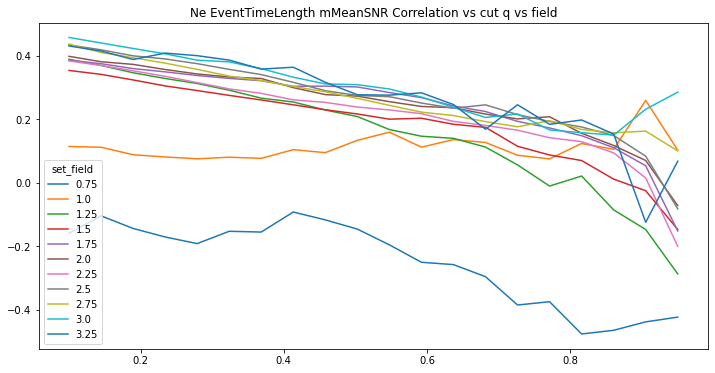

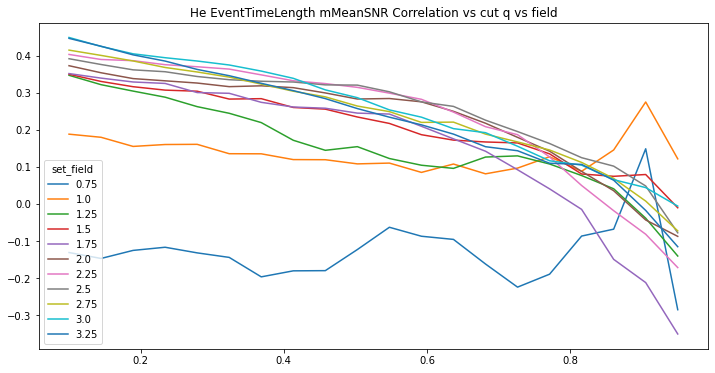

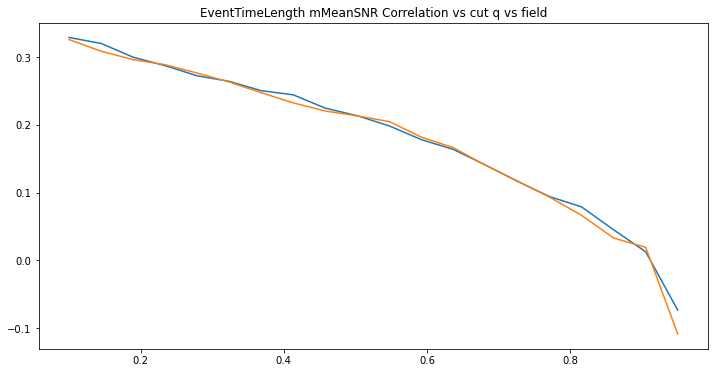

In [32]:
%matplotlib inline

cut = 9

events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events

events_ne = re.add_detectability(events_ne)
events_he = re.add_detectability(events_he)

events_cut_ne = re.cut_df(events_ne, initial_cuts)
events_cut_he = re.cut_df(events_he, initial_cuts)


events_cut_ne = re.add_field_wise_percentage(events_cut_ne, cols=["mMeanSNR"])
events_cut_he = re.add_field_wise_percentage(events_cut_he, cols=["mMeanSNR"])

q_cuts = np.linspace(.1,.95,20)
index = events_cut_ne.set_field.drop_duplicates().sort_values()
ne_corrs = pd.DataFrame(index=index, columns=q_cuts)
he_corrs = pd.DataFrame(index=index, columns=q_cuts)


for q_cut in q_cuts:
    later_cuts = {
                "mMeanSNR_p": (q_cut,1),
                }
    events_cut_ne = re.cut_df(events_cut_ne, later_cuts)
    events_cut_he = re.cut_df(events_cut_he, later_cuts)
    ne_corrs[q_cut] =events_cut_ne.groupby('set_field')[['EventTimeLength','mMeanSNR']].corr().unstack().iloc[:,1]
    he_corrs[q_cut] =events_cut_he.groupby('set_field')[['EventTimeLength','mMeanSNR']].corr().unstack().iloc[:,1]
    
fig0, ax0 = plt.subplots(figsize=(12,6))
ne_corrs.transpose().plot(ax = ax0)
plt.title("Ne EventTimeLength mMeanSNR Correlation vs cut q vs field")
plt.show()

fig0, ax0 = plt.subplots(figsize=(12,6))
he_corrs.transpose().plot(ax = ax0)
plt.title("He EventTimeLength mMeanSNR Correlation vs cut q vs field")
plt.show()

fig0, ax0 = plt.subplots(figsize=(12,6))
ne_corrs.mean().transpose().plot(ax = ax0)
plt.title("Ne EventTimeLength mMeanSNR Correlation vs cut q vs field")
# plt.show()

# fig0, ax0 = plt.subplots(figsize=(12,6))
he_corrs.mean().transpose().plot(ax = ax0)
plt.title("EventTimeLength mMeanSNR Correlation vs cut q vs field")
plt.show()

### Step 8b: Investigating all other features after this q cut. 


**Notes**: 

* Ok so the event frequency histogram agreement (KS p-val) could be a way to argue for this?
* It additionally helps with the broken tracks at the SNR blip at 950 MHz. 
* Another thought is that I could add in the detection efficiency roll-off with frequency we see here and the agreement may get even better...(into the MC). 

In [42]:
initial_cuts = {
            "EventStartFreq": (300e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
    
            }

later_cuts = {
                "mMeanSNR_p": (.5,1),
                }

In [36]:
%matplotlib widget

set_fields = sorted(events_cut_ne['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    field_value = widgets.Select(options = set_fields,  description='set_field: '),
    column_1 = widgets.Select(options = events_cut_ne.columns,value = 'EventStartFreq', description='x_col: '),
    column_2 = widgets.Select(options = events_cut_ne.columns,value = 'mMeanSNR', description='y_col: '),
    mrk_sz = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2),
    alpha = widgets.FloatSlider(value=.5, min=0.0,max=1.0,step=1e-2), 
    frac_pts = widgets.FloatSlider(value=0.02,min=0.0,max=1.0,step=1e-2), 
    bins = widgets.IntSlider(value=200,min=50,max=700,step=10),
    fix_field = widgets.Checkbox(
    value=False,
    description='fix field',
    disabled=False,
    indent=False),
    density_hist = widgets.Checkbox(
    value=False,
    description='density hist',
    disabled=False,
    indent=False),
    log_hist = widgets.Checkbox(
    value=False,
    description='log hist',
    disabled=False,
    indent=False
)
):
    
    cut = 9

    events_ne = snr_study["ne"][cut].events
    events_he = snr_study["he"][cut].events

    events_ne = re.add_detectability(events_ne)
    events_he = re.add_detectability(events_he)

    events_cut_ne = re.cut_df(events_ne, initial_cuts)
    events_cut_he = re.cut_df(events_he, initial_cuts)

    events_cut_ne = re.add_field_wise_percentage(events_cut_ne, cols=["mMeanSNR"])
    events_cut_he = re.add_field_wise_percentage(events_cut_he, cols=["mMeanSNR"])

    events_cut_ne = re.cut_df(events_cut_ne, later_cuts)
    events_cut_he = re.cut_df(events_cut_he, later_cuts)

    
    plt.close("all")
    scatt_settings={
            "figsize": (10, 4),
            "colors": ["b", "r", "g", "c", "m", "k"],
            "hist_bins": 300,
            "markersize": mrk_sz,
            "alpha": .5,
        }
    
        
    if fix_field:
        condition_ne = events_cut_ne.set_field == field_value
        condition_he = events_cut_he.set_field == field_value

        events_cut_ne = events_cut_ne[condition_ne]
        events_cut_he = events_cut_he[condition_he]

    plt.close("all")
    fig0, ax0 = plt.subplots(figsize=scatt_settings["figsize"])

    ax0.set_title("Scatter: {} vs {}".format(column_1, column_2))
    ax0.set_xlabel("{}".format(column_1))
    ax0.set_ylabel("{}".format(column_2))

    # Scatter Plots
    ax0.plot(
        events_cut_ne[column_1],
        events_cut_ne[column_2],
        "o",
        markersize=scatt_settings["markersize"],
        alpha=scatt_settings["alpha"],
        color=scatt_settings["colors"][0],
        label = "Ne19"
    )

    # Scatter Plots
    ax0.plot(
        events_cut_he[column_1],
        events_cut_he[column_2],
        "o",
        markersize=scatt_settings["markersize"],
        alpha=scatt_settings["alpha"],
        color=scatt_settings["colors"][1],
        label = "He6"
        )
    ax0.legend()
    plt.show()

    # Now we want projections into the first attribute. 
    fig1, ax1 = plt.subplots(figsize=scatt_settings["figsize"])

    ax1.set_title("Histogram. x_col: {}".format(column_1))
    ax1.set_xlabel("{}".format(column_1))

    # Histogram.
    ax1.hist(
        events_cut_ne[column_1],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][0],
        histtype="step", density=density_hist,
        label = "Ne19"
    )
    ax1.hist(
        events_cut_he[column_1],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][1],
        histtype="step", density=density_hist,
        label = "He6"
    )
    if log_hist: 
        ax1.set_yscale("log")
        
    ax1.legend()
    plt.show()
    
    # Now we want projections into the second attribute. 
    fig2, ax2 = plt.subplots(figsize=scatt_settings["figsize"])

    ax2.set_title("Histogram. x_col: {}".format(column_2))
    ax2.set_xlabel("{}".format(column_2))

    # Histogram.
    ax2.hist(
        events_cut_ne[column_2],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][0],
        histtype="step", density=density_hist,
        label = "Ne19"
    )
    ax2.hist(
        events_cut_he[column_2],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][1],
        histtype="step", density=density_hist,
        label = "He6"
    )
    if log_hist: 
        ax2.set_yscale("log")
    ax2.legend()
    plt.show()

interactive(children=(Select(description='set_field: ', options=(0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2…

### Step 8c: Time Length distributions vs expectation.  


**Notes**: 

* This needs to be done field-wise.
* This will take a bit more work. What we want is:
    * At each field we compare the expected track length pdf with the density plot we actually observe and obtain a ks p-value. Use the old scripts for ks p-values. 
    * Use newbing for help. Keep it rolling. 

In [128]:
initial_cuts = {
            "EventStartFreq": (300e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
            }

later_cuts = {
                "mMeanSNR_p": (.3,1),
                }

cut = 9

events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events

events_ne = re.add_detectability(events_ne)
events_he = re.add_detectability(events_he)

events_ne = re.cut_df(events_ne, initial_cuts)
events_he = re.cut_df(events_he, initial_cuts)

events_cut_ne = re.add_field_wise_percentage(events_ne, cols=["mMeanSNR"])
events_cut_he = re.add_field_wise_percentage(events_he, cols=["mMeanSNR"])

events_cut_ne = re.cut_df(events_cut_ne, later_cuts)
events_cut_he = re.cut_df(events_cut_he, later_cuts)

/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


Building hist for EventTimeLength. cut = 0.


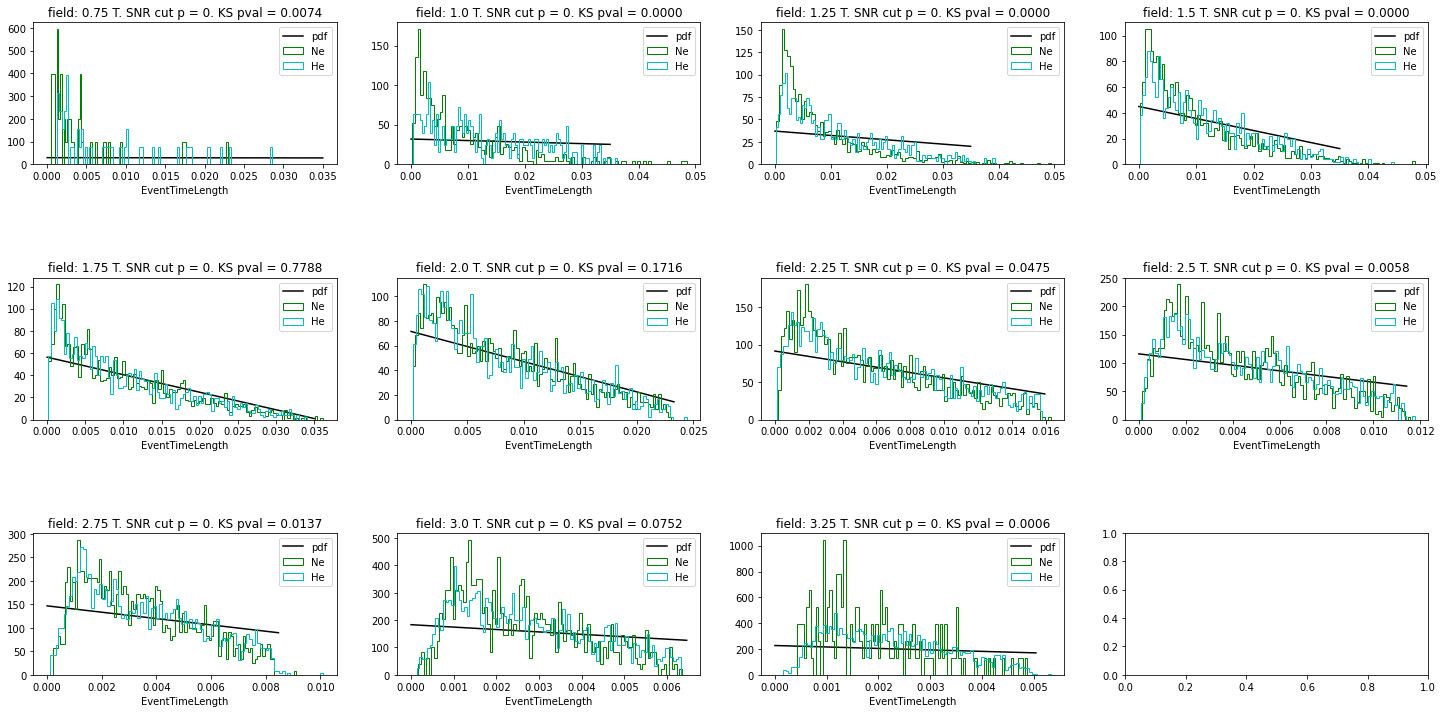

Building hist for EventTimeLength. cut = 0.4.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


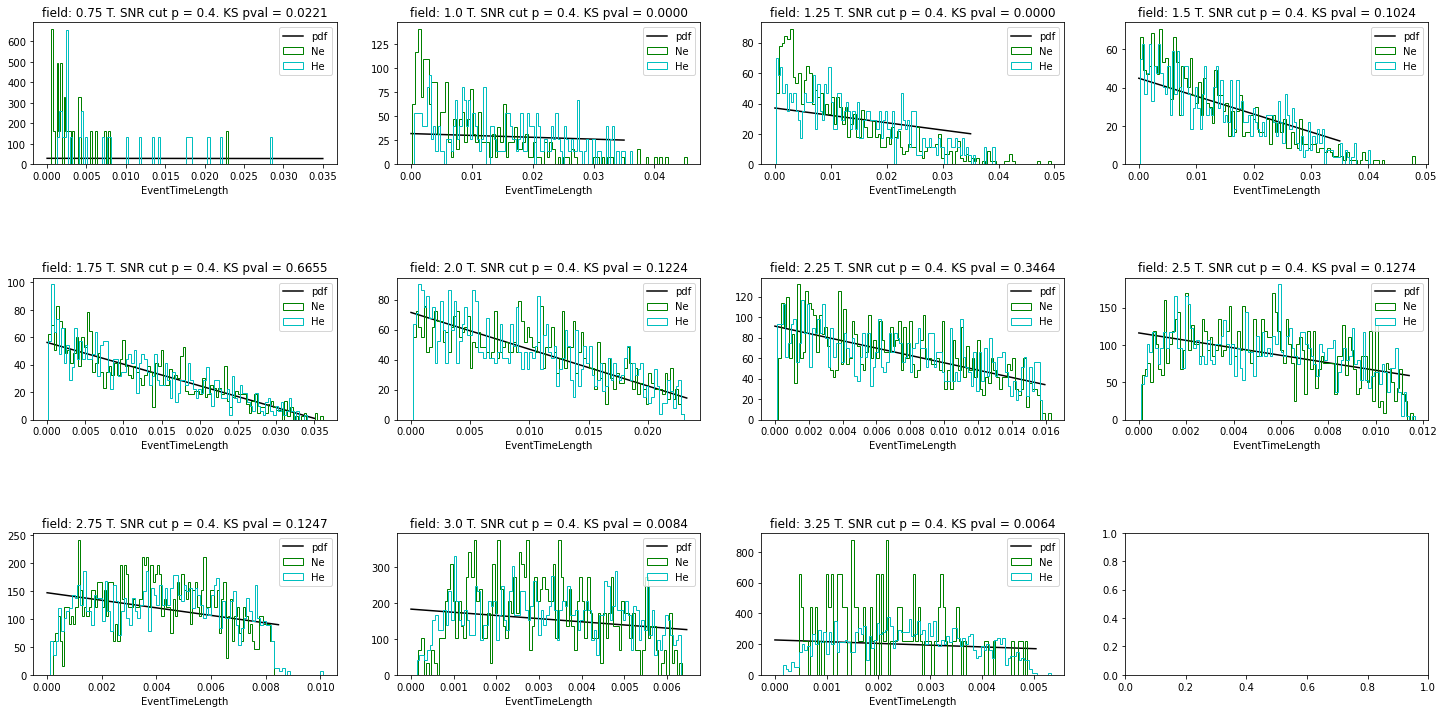

Building hist for EventTimeLength. cut = 0.6.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


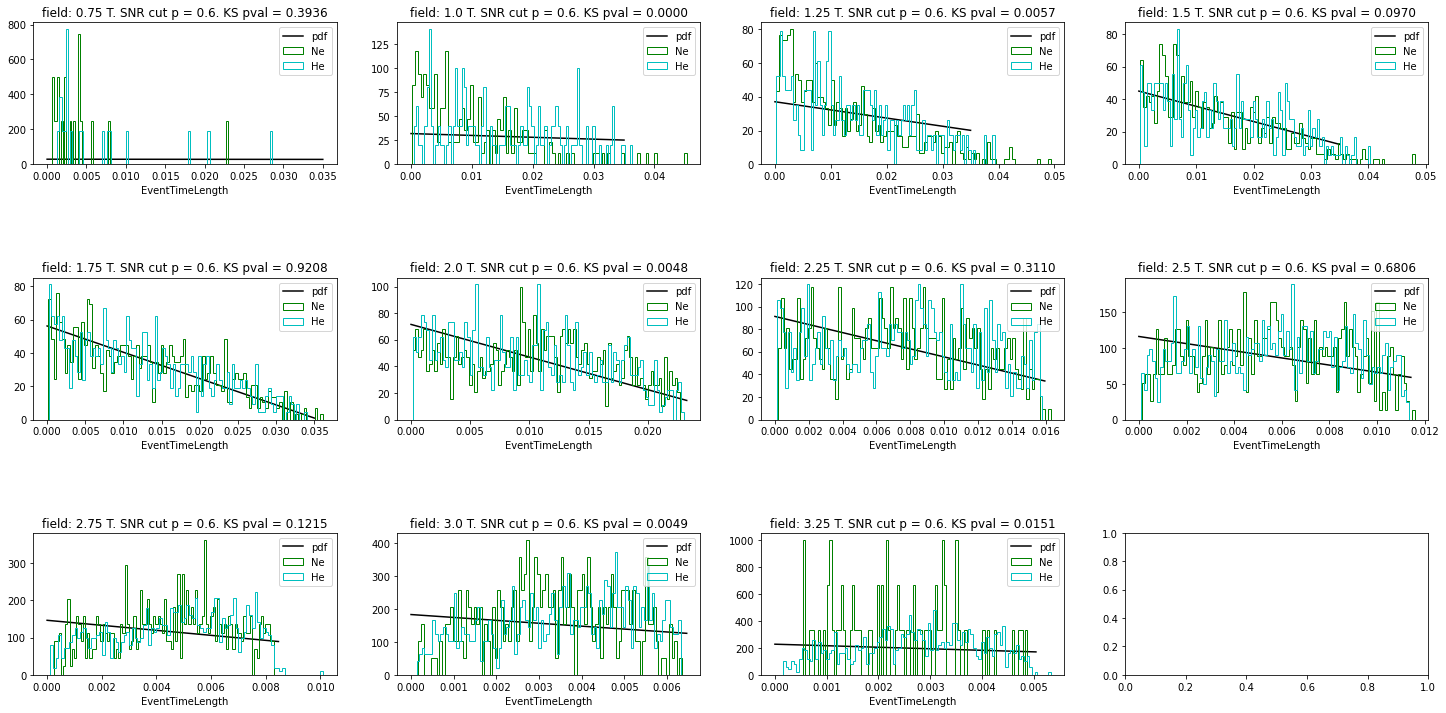

Building hist for EventStartFreq. cut = 0.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


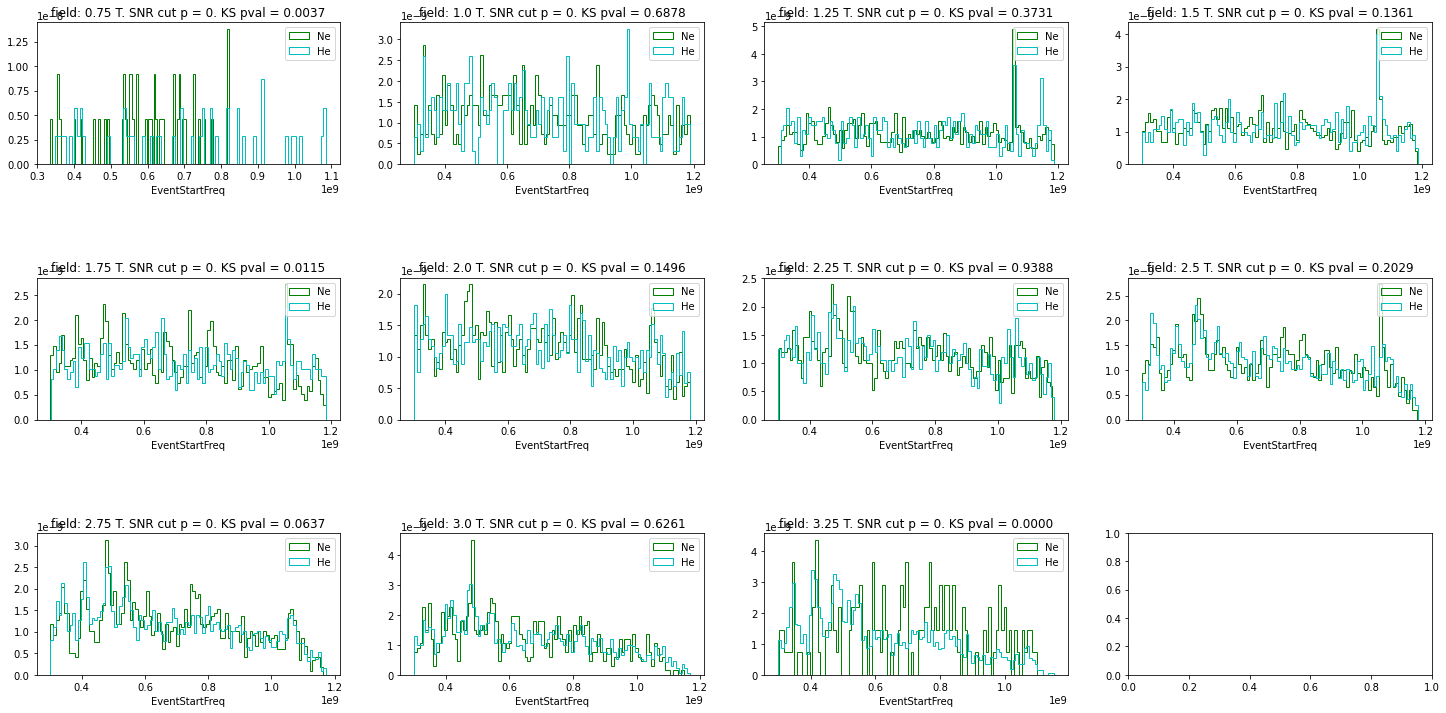

Building hist for EventStartFreq. cut = 0.4.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


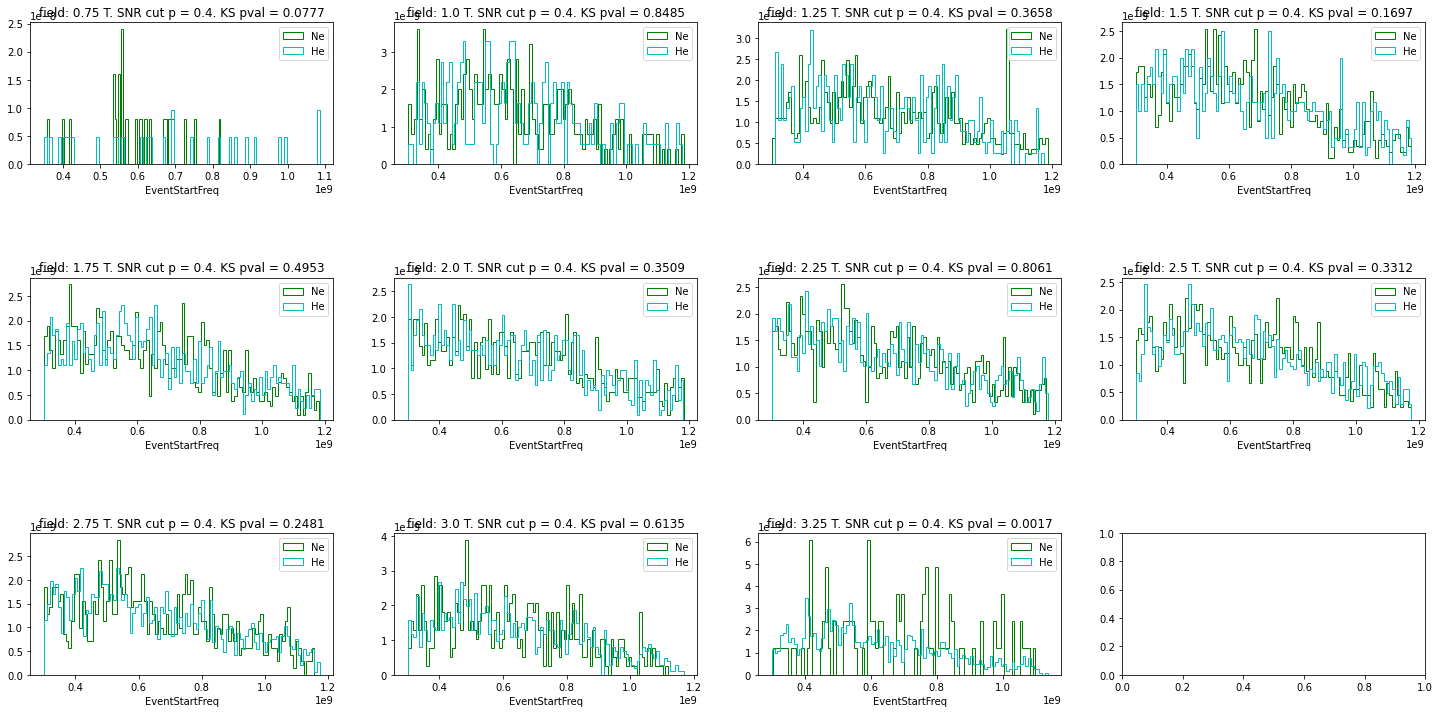

Building hist for EventStartFreq. cut = 0.6.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


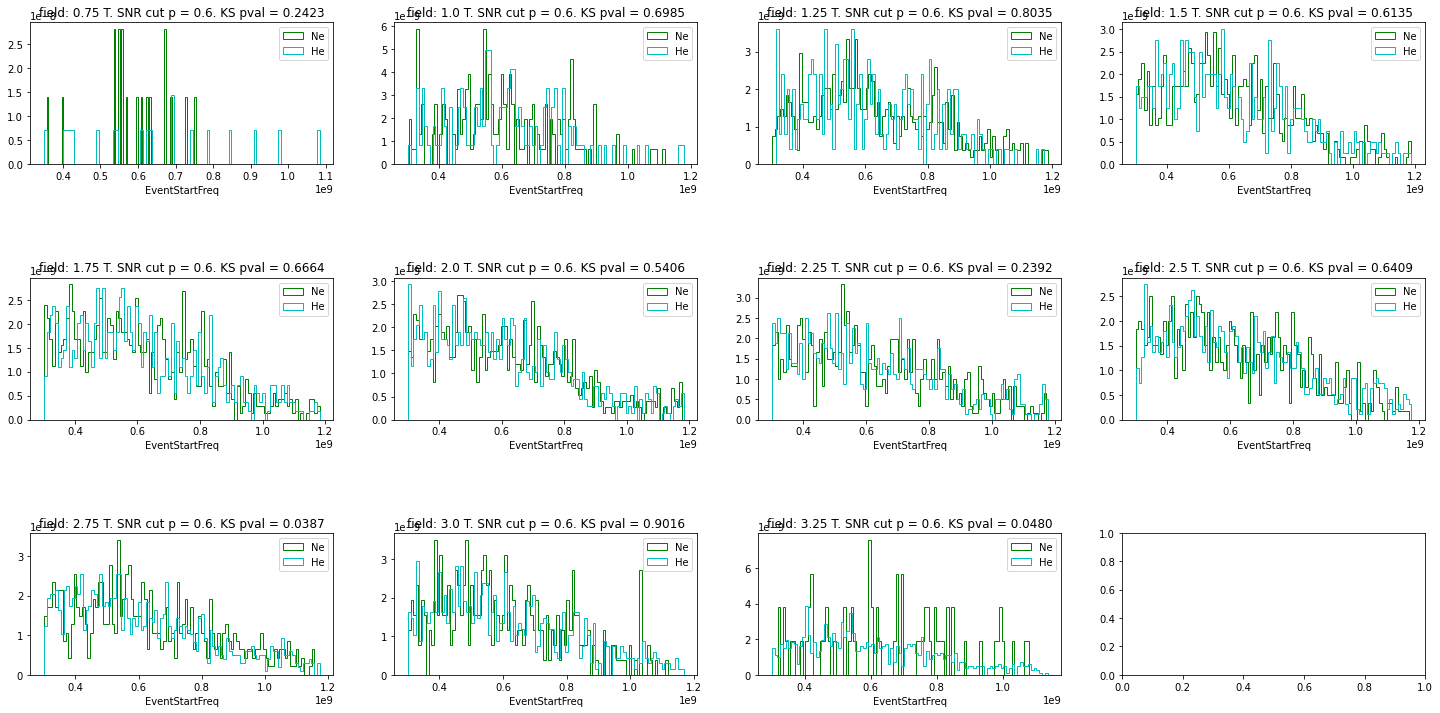

Building hist for mMeanSNR. cut = 0.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


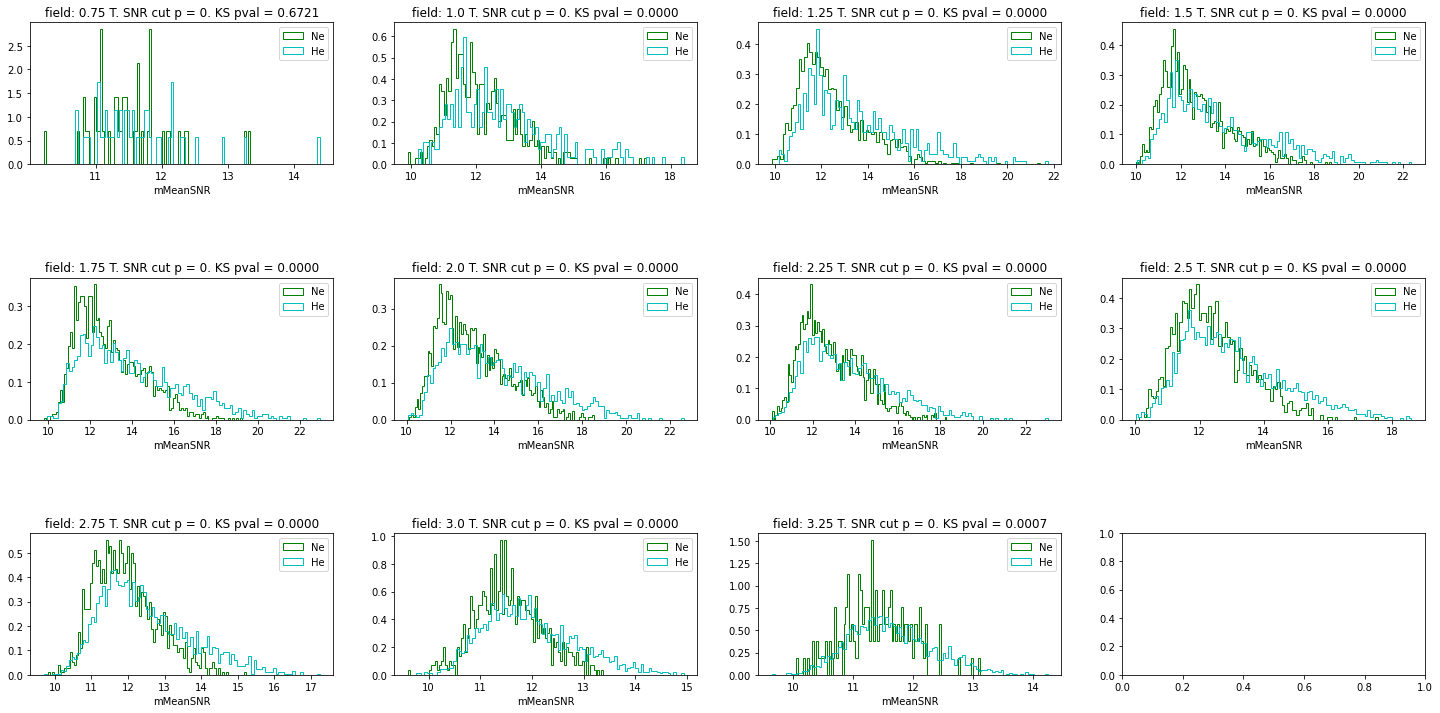

Building hist for mMeanSNR. cut = 0.4.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


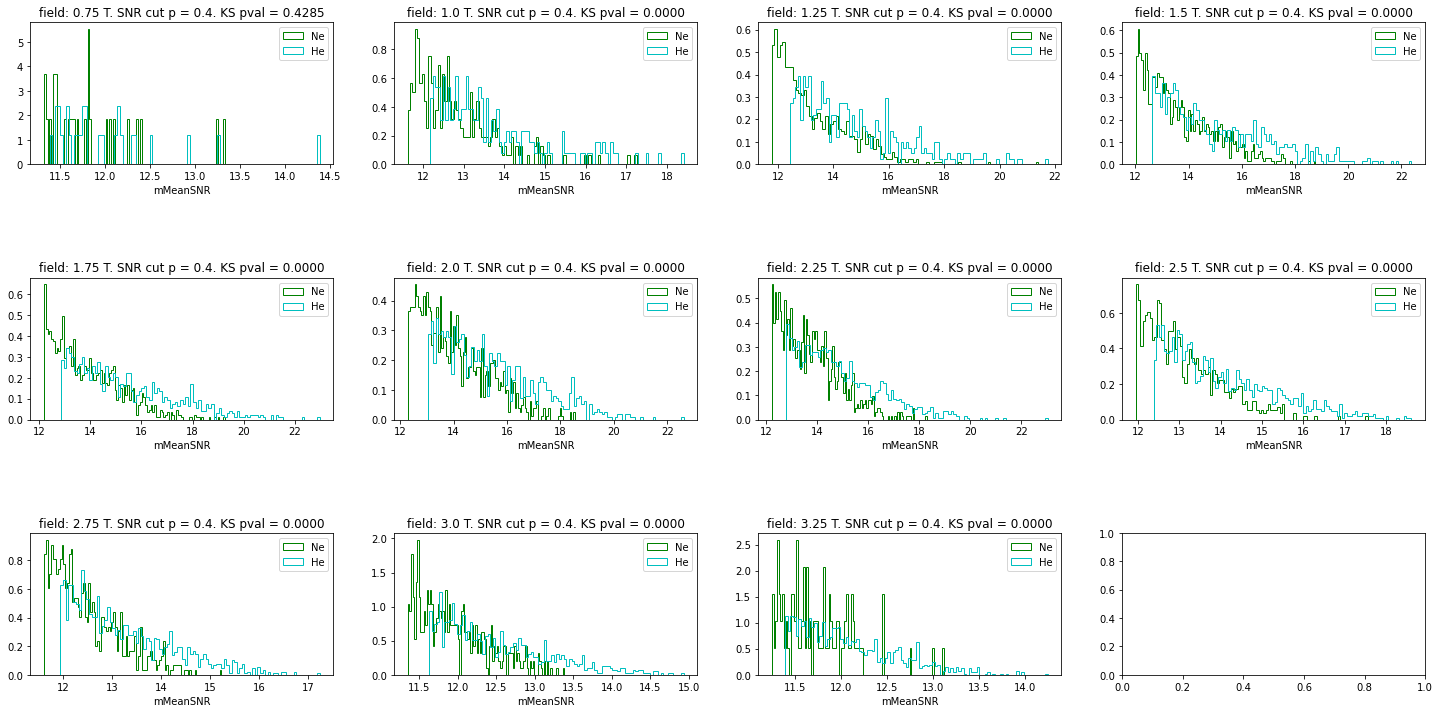

Building hist for mMeanSNR. cut = 0.6.


/home/drew/He6CRES/rocks_analysis_notebooks/analysis_functions/ratio_experiment.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: (x - 1) / sz)


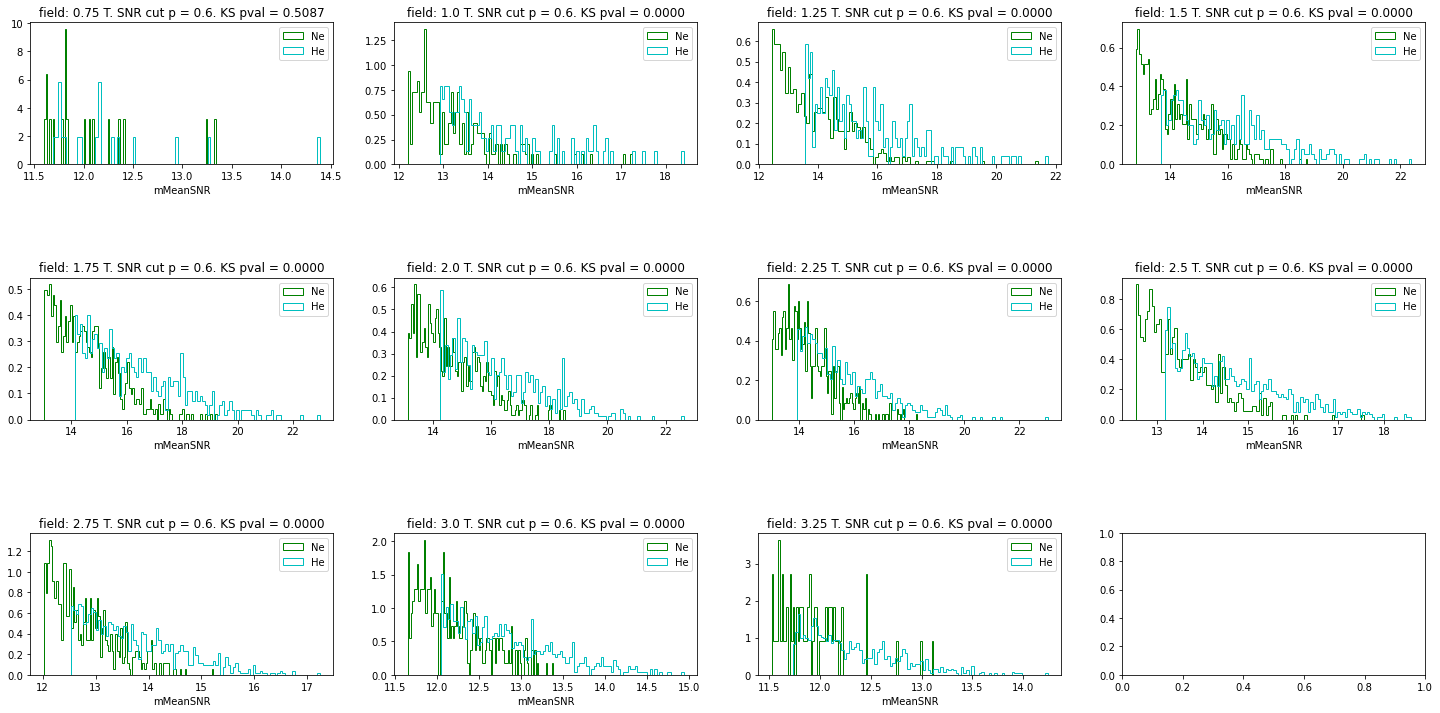

In [129]:
%matplotlib inline


# ------ Set Plot Parameters -----------

params = {'axes.titlesize': 12,
          'legend.fontsize': 10,
          'axes.labelsize': 10,
          'xtick.labelsize':10,
          'ytick.labelsize':10}
plt.rcParams.update(params)


from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def track_len_pdf_field(field, slew_cycle = 35e-3, freq_BW = 1.1e9):
    
    freq = 18.55e9
    power_larmor = sc.power_larmor(field, freq)
    energy = sc.freq_to_energy(freq, field)
    slope = sc.df_dt(energy, field, power_larmor)
    
    return track_len_pdf(slope, slew_cycle, freq_BW)


def track_len_pdf(slope, slew_cycle, freq_BW):
    
    T1 = slew_cycle
    T2 = freq_BW/slope

    Tmax = np.minimum(T1, T2)
    ls = np.linspace(0,Tmax,200)
    
    pdf = (T1 + T2 - 2*ls)/(T1*T2)
    pdf[np.logical_or(ls <0, ls > np.minimum(T1, T2))] = 0
    
    return ls, pdf

def hist_grid_by_field(ne, he, feature, nrows, yscale, bins, p_cut = 0, fig_path = ""): 
    
    events_ne = snr_study["ne"][cut].events
    events_he = snr_study["he"][cut].events

    events_ne = re.cut_df(events_ne, initial_cuts)
    events_he = re.cut_df(events_he, initial_cuts)
    
    mMeanSNR_p_cuts = {
            "mMeanSNR_p": (p_cut,1),
            }
    
    events_cut_ne = re.add_field_wise_percentage(events_ne, cols=["mMeanSNR"])
    events_cut_he = re.add_field_wise_percentage(events_he, cols=["mMeanSNR"])

    ne = re.cut_df(events_cut_ne, mMeanSNR_p_cuts)
    he = re.cut_df(events_cut_he, mMeanSNR_p_cuts)

    grouped_ne = ne.groupby('set_field')
    grouped_he = he.groupby('set_field')
    rowlength = int(np.ceil(grouped_ne.ngroups/3))                    
    fig, axs = plt.subplots(figsize=(25,12), 
                            nrows=3, ncols=rowlength,     # fix as above
                            gridspec_kw=dict(hspace=0.8)) # Much control of gridspec

    targets = zip(grouped_ne.groups.keys(),  axs.flatten())

    for i, (key, ax) in enumerate(targets):
        
        
        
        ne_field = grouped_ne.get_group(key)[feature]
        he_field = grouped_he.get_group(key)[feature]
        
        if feature == 'EventTimeLength':
            freq_BW = initial_cuts["EventStartFreq"][1] - initial_cuts["EventStartFreq"][0]
            ls, pdf = track_len_pdf_field(field = key, slew_cycle = 35e-3, freq_BW = freq_BW)
            ax.plot(ls, pdf, color = str(0), label = "pdf")
            
        # Calculate KS test for similarity of samples.
        ks = stats.kstest(ne_field, he_field)
        
        ax.hist(ne_field, bins=bins, 
                       histtype=u'step', density=True, label = "Ne", color = "g")
        ax.hist(he_field, bins=bins, 
                       histtype=u'step', density=True, label = "He", color = "c")
        ax.set_title(f"field: {key} T. SNR cut p = {p_cut}. KS pval = {ks.pvalue:.4f}")
        ax.set_yscale(yscale)
        ax.set_xlabel(feature)
        ax.legend()
    plt.show()
    # fig.suptitle(f"{feature}. Cuts = {cuts}.", fontsize = 25)
    # plt.savefig(fig_path, bbox_inches='tight', dpi = 200)

    return None


# ----- Loop through all features and make a hist plot with and without cuts ---- 

# Set parameters of plot. 

nrows = 3
bins = 100
yscale = "log"
yscale = "linear"
base_path = "/media/drew/T7 Shield/rocks_analysis/paper_02_figures/hist_grids_snr_test/"


features = ['EventTimeLength', 'EventStartFreq','mMeanSNR']

for feature in features: 
    for p_cut in [0,.4,.6]: 

        print(f"Building hist for {feature}. cut = {p_cut}.")

        fig_path = base_path + f"events_hist_{feature}_cuts_{cuts}.png"

        hist_grid_by_field(events_ne, events_he, feature, nrows, yscale, bins, p_cut = p_cut, fig_path = fig_path)



#### Now build a ratio only with the things that do well with the above cuts

In [46]:
def quantile(x, q = .4 ):
        return x.quantile(q)

initial_cuts = {
            "field_wise":{
                    "mMeanSNR":[quantile, (1,np.inf)],
                    "EventTimeLength":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (300e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
            }

In [47]:
# Set start and stop freqs for cuts. 
freq1s = np.arange(100,1000,100)
freq2s = np.arange(300,1200,100)
freq2s = np.ones_like(freq1s)*1200
freq1s = np.array([400])
freq2s = np.array([1200])
print(f"veto start_freqs: {freq1s}\nveto end_freqs: {freq2s}")
set_fields = np.arange(1.75,3.25,.25)
print(set_fields)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

veto start_freqs: [400]
veto end_freqs: [1200]
[1.75 2.   2.25 2.5  2.75 3.  ]


Spectrum cut: [ 400. 1200.] MHz
BW used for predicted ratio:[1.83e+10 1.91e+10]
reduced chisq: 2.0515258542921675

[[Variables]]
    C:  0.34266992 +/- 0.01098019 (3.20%) (init = 1)
    b: -0.41047031 +/- 0.29708367 (72.38%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(C, b) = 0.351


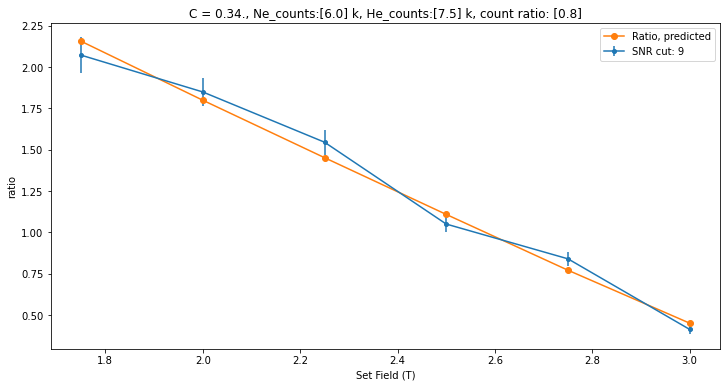

In [48]:
%matplotlib inline

plot_spectrum = False

for freq1, freq2 in zip(freq1s, freq2s):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }

    ne_cuts = {**initial_cuts, **spectrum_cuts}
    he_cuts = {**initial_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:
        diagnostics = False
        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts, diagnostics = diagnostics))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts, diagnostics = diagnostics))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]] )
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        # Only take the fields you want: 
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=0, min=-10, max = 10, vary =True)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp), method = 'least_squares')
        # report(out)
        # Fit report.
        print(f"reduced chisq: {result.redchi}\n")
        print(fit_report(result.params))
        
        C = result.params["C"].value
        b = result.params["b"].value
        
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = b, plot = False)
        
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        
        pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")
        
        # Plot predicted ratio
        pm.plot_predicted_ratio(ratio_pred, ax0)

        ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
        he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
        count_ratio = np.array(ne_counts)/np.array(he_counts)
    
    # ax0.set_yscale("log")
    ax0.set_ylabel('ratio')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
    ax0.legend()
    plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

# Work on the way (DELETE ONCE FINISHED)

In [19]:
def cut_df(events, cuts, plot_fw_cuts = False):
    
    # Make a copy of events to alter and return.
    events_cut = events.copy()
    
    # Note that the None prevents a key error if you have no field-wise cuts. 
    field_wise_cuts = cuts.pop("field_wise", None)
    
    if field_wise_cuts is not None: 
        for column, cut in field_wise_cuts.items():

            events_cut["cut_cond"] = events.groupby(["set_field"])[column].transform(cut[0])
            if plot_fw_cuts: 
                events_cut["cut_cond"].plot()
                plt.show()

            cond = ((events_cut[column] >= cut[1][0]*events_cut["cut_cond"]) & 
                    (events_cut[column] <= cut[1][1]*events_cut["cut_cond"]))

            events_cut = events_cut[cond]

    for column, cut in cuts.items():

        events_cut = events_cut[
            (events_cut[column] >= cut[0]) & (events_cut[column] <= cut[1])
        ]

    return events_cut

In [20]:
cuts = {
            "field_wise":{
                "mMeanSNR":["median", (.9,np.inf)],
                "EventTimeLength":["median", (1,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            }
cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            }
events = snr_study["ne"][9].events
print(events.columns)
display(events.groupby("set_field").EventID.count())
events_cut = cut_df(events, cuts)
display(events_cut.groupby("set_field").EventID.count())

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventSlope', 'EventNBins', 'EventTrackTot',
       'EventFreqIntc', 'EventTimeIntc', 'mMeanSNR', 'sMeanSNR', 'mTotalSNR',
       'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
       'mTotalPower', 'sTotalPower', 'field', 'set_field', 'monitor_rate'],
      dtype='object')


set_field
0.75      56
1.00     731
1.25    1517
1.50    1955
1.75    3106
2.00    3804
2.25    3378
2.50    3746
2.75    2989
3.00    1420
3.25     226
Name: EventID, dtype: int64

set_field
0.75      56
1.00     731
1.25    1517
1.50    1955
1.75    3106
2.00    3804
2.25    3378
2.50    3746
2.75    2989
3.00    1420
3.25     226
Name: EventID, dtype: int64

set_field
0.75      56
1.00     731
1.25    1517
1.50    1955
1.75    3106
2.00    3804
2.25    3378
2.50    3746
2.75    2989
3.00    1420
3.25     226
Name: EventID, dtype: int64

<AxesSubplot:>

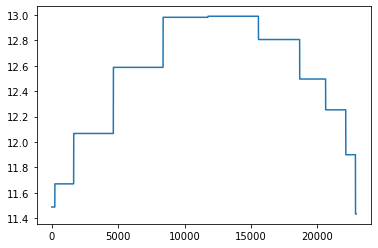

set_field
0.75      28
1.00     365
1.25     758
1.50     977
1.75    1553
2.00    1902
2.25    1689
2.50    1873
2.75    1494
3.00     710
3.25     113
Name: EventID, dtype: int64

set_field
0.75    0.500000
1.00    0.499316
1.25    0.499670
1.50    0.499744
1.75    0.500000
2.00    0.500000
2.25    0.500000
2.50    0.500000
2.75    0.499833
3.00    0.500000
3.25    0.500000
Name: EventID, dtype: float64

In [21]:
# display(events)

display(events.groupby("set_field").EventID.count())
events["stuff"] = events.groupby(["set_field"])[
            "mMeanSNR"
        ].transform("median")
display(events.stuff.plot())
plt.show()
events_cut = events[events["mMeanSNR"] > events["stuff"]]

display(events_cut.groupby("set_field").EventID.count())
display(events_cut.groupby("set_field").EventID.count()/events.groupby("set_field").EventID.count())
# df.groupby('column').filter(lambda group: group.size > X)